# Gaussian fitting loop for S I Lines
With the new and revised version on fitting the COS data, we can create a loop that will semi-automatically return the parameters and brightness for the given wavelength.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
import scipy as scipy
from scipy import optimize
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
hdulist = fits.open('../data/composite_Io_eclipsed.fits')
evt_data = Table(hdulist[1].data)
image_data = hdulist[1].data
df = pd.read_csv('../data/Io_Master_Line_List (1).csv') #spaces in csv file will make df object type and not float64
line = "S I"
target_mask = df.Species.str.endswith(line) #probably a better function but idk it right now
df = df[target_mask]
df_wavelength = df['Wavelength']
df_species = df['Species']

In [3]:
df_results = pd.DataFrame()
problem_files = {}

In [4]:
wavelength_list = df_wavelength.values.tolist()

In [5]:
def _1gaussian(x, amp1,cen1,sigma1):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((wl_array-cen1)/sigma1)**2)))

In [6]:
def _2gaussian(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((wl_array-cen1)/sigma1)**2))) + \
            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((wl_array-cen2)/sigma2)**2)))

  2%|█▌                                                                                 | 1/52 [00:04<03:26,  4.06s/it]C:\Users\jojoa\.conda\envs\io_env\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
  4%|███▏                                                                               | 2/52 [00:07<02:59,  3.60s/it]C:\Users\jojoa\.conda\envs\io_env\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 10%|███████▉                                                                           | 5/52 [00:17<02:45,  3.51s/it]C:\Users\jojoa\.conda\envs\io_env\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 12%|█████████▌                                                                         | 6/52 [00:21<0

Fail: 1262.86 1269.209


 38%|███████████████████████████████▌                                                  | 20/52 [01:06<01:33,  2.93s/it]C:\Users\jojoa\.conda\envs\io_env\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 42%|██████████████████████████████████▋                                               | 22/52 [01:09<01:06,  2.23s/it]C:\Users\jojoa\.conda\envs\io_env\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Fail: 1277.212 1280.099


 65%|█████████████████████████████████████████████████████▌                            | 34/52 [01:54<01:07,  3.74s/it]C:\Users\jojoa\.conda\envs\io_env\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 98%|████████████████████████████████████████████████████████████████████████████████▍ | 51/52 [02:53<00:03,  3.40s/it]


IndexError: list index out of range

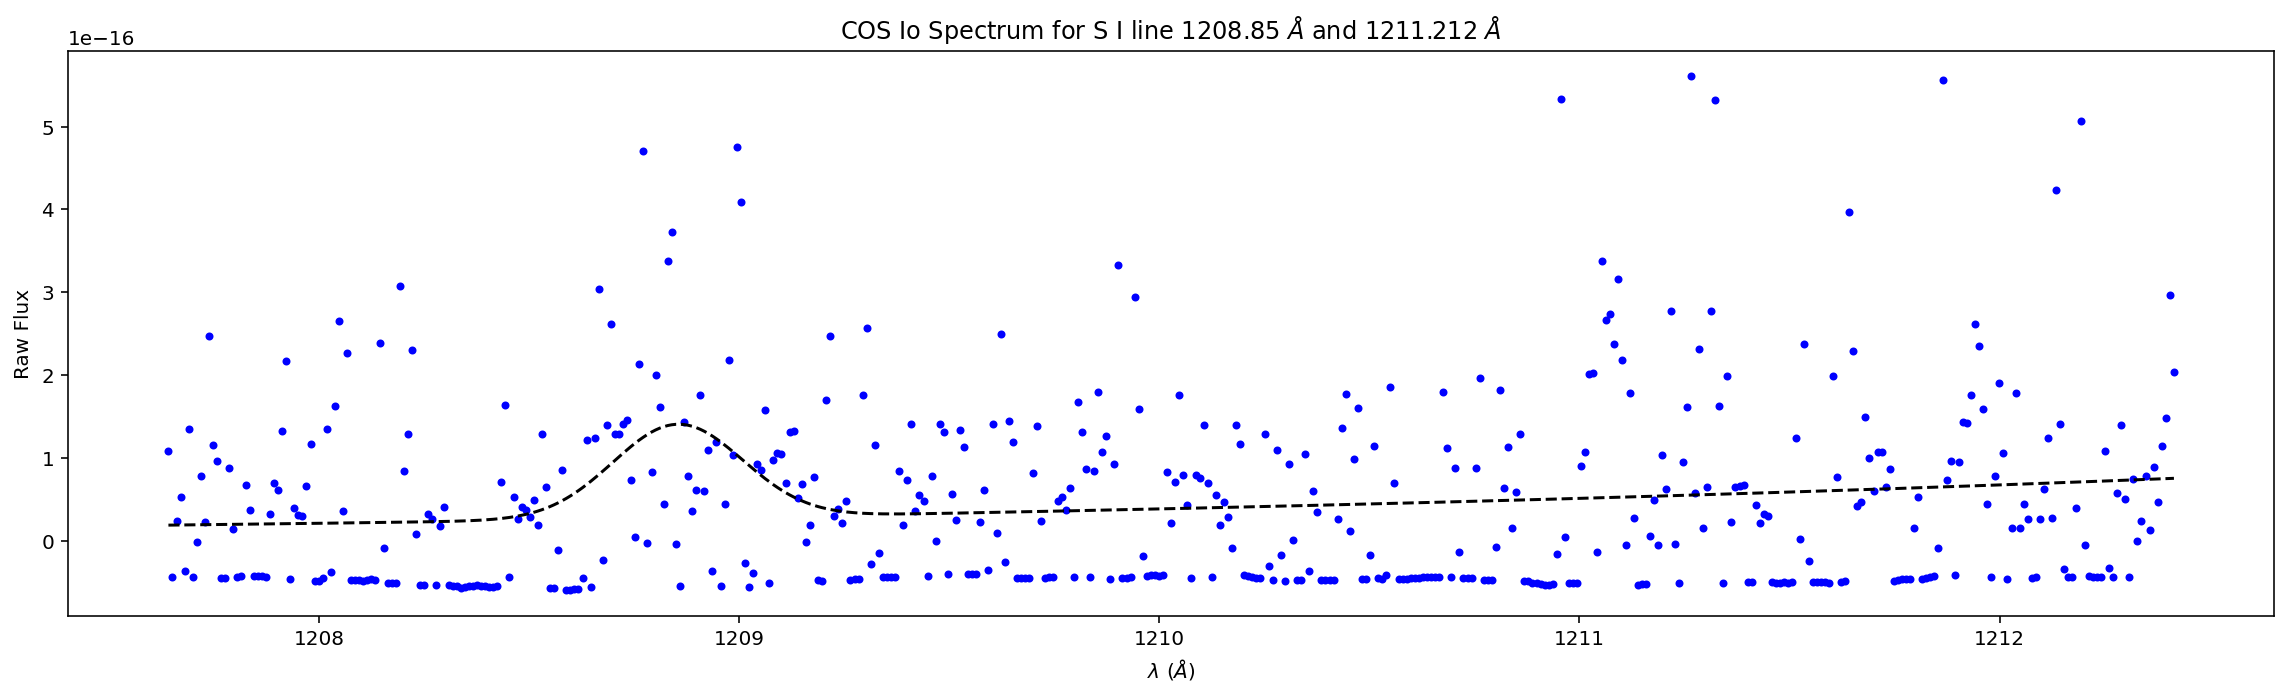

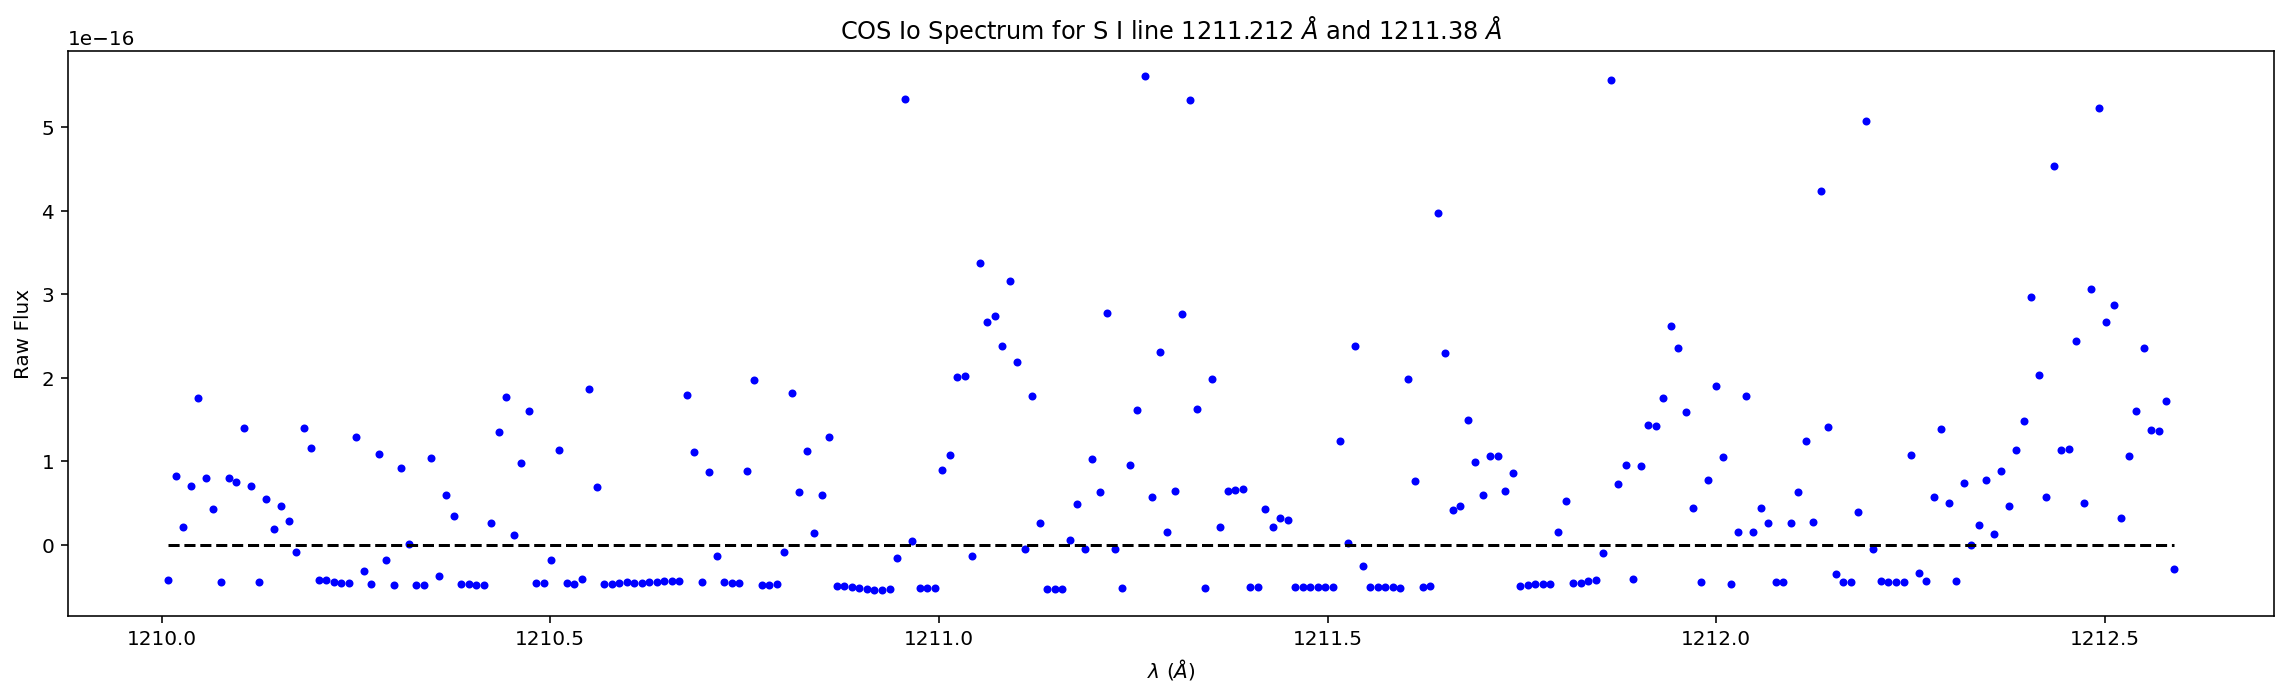

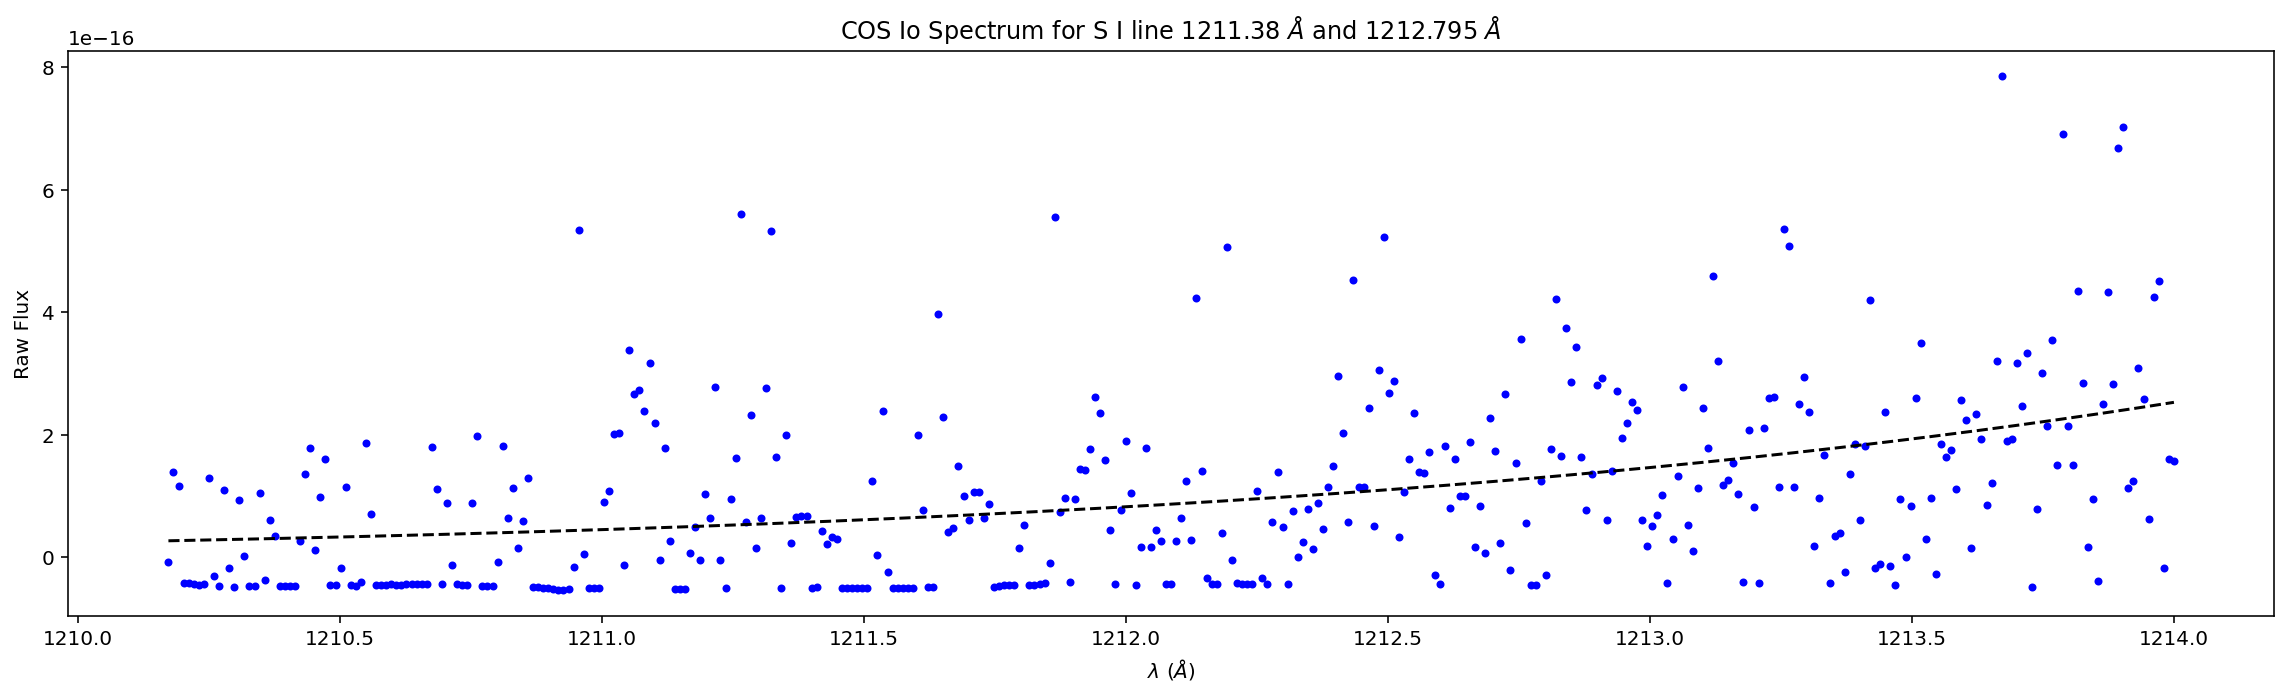

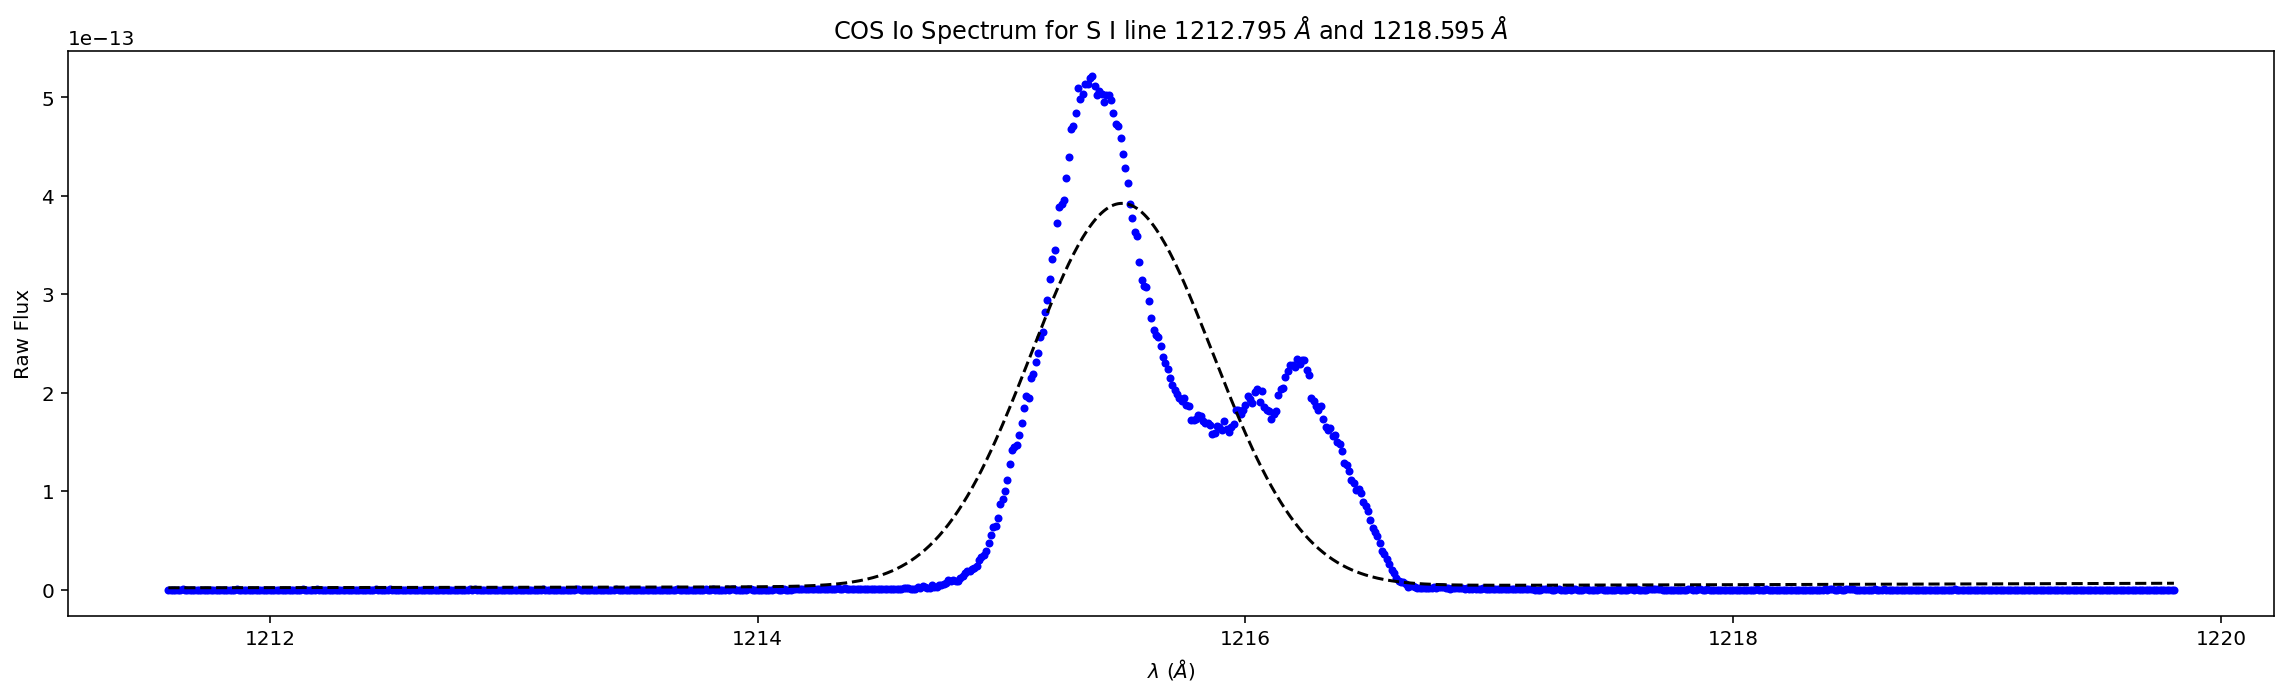

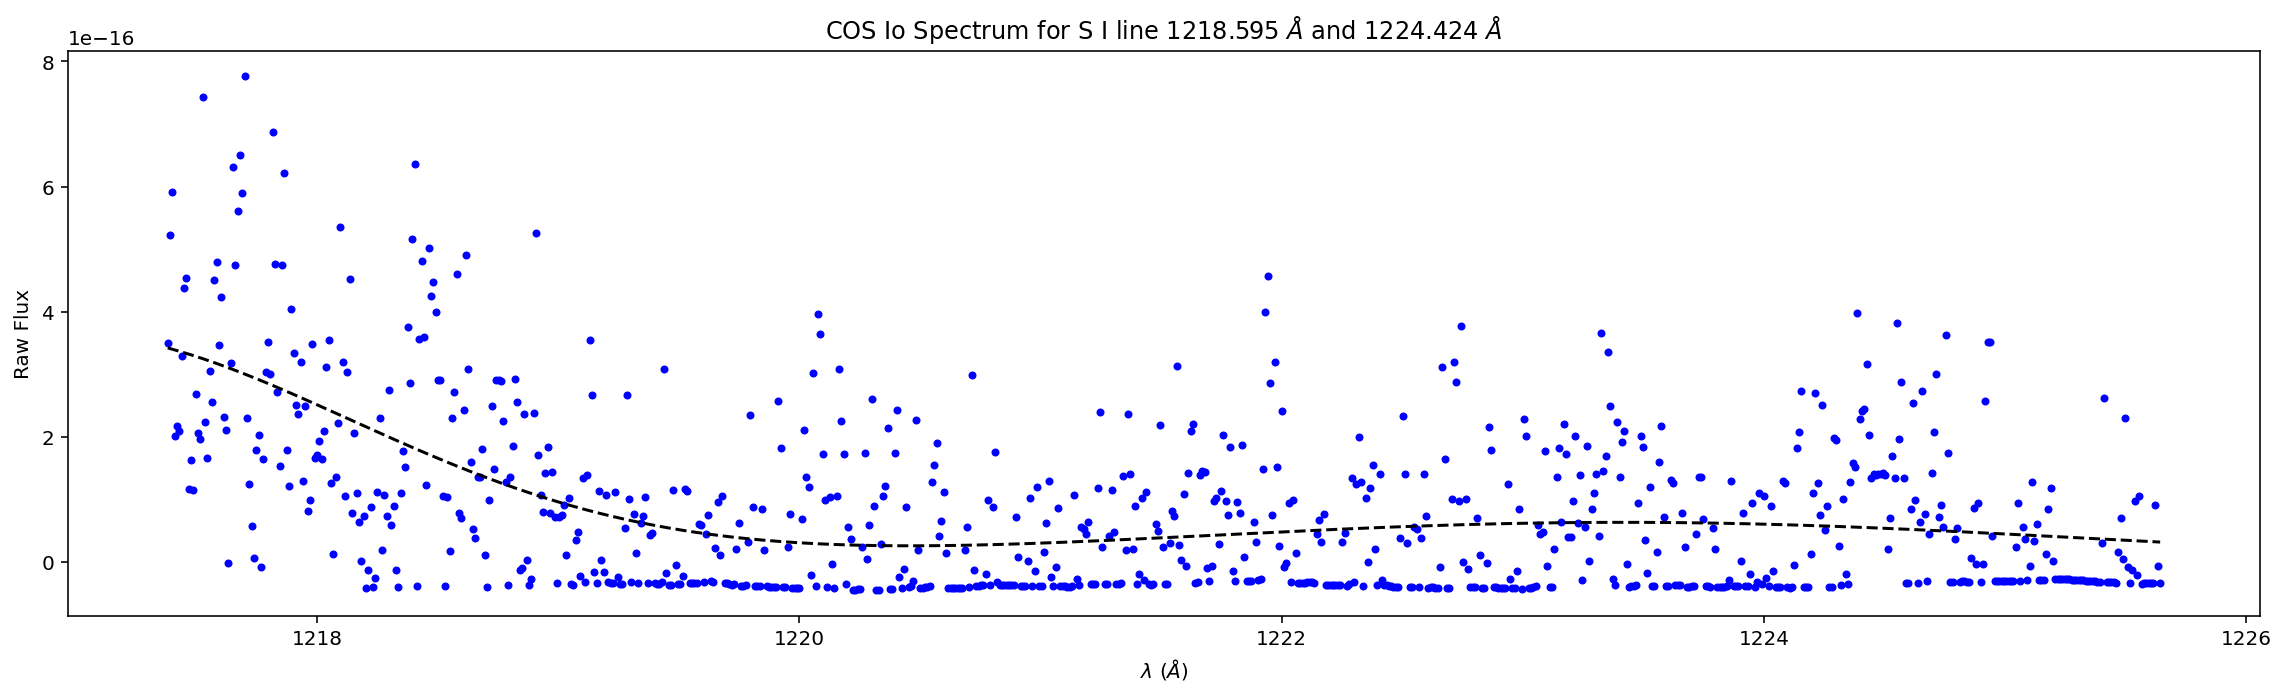

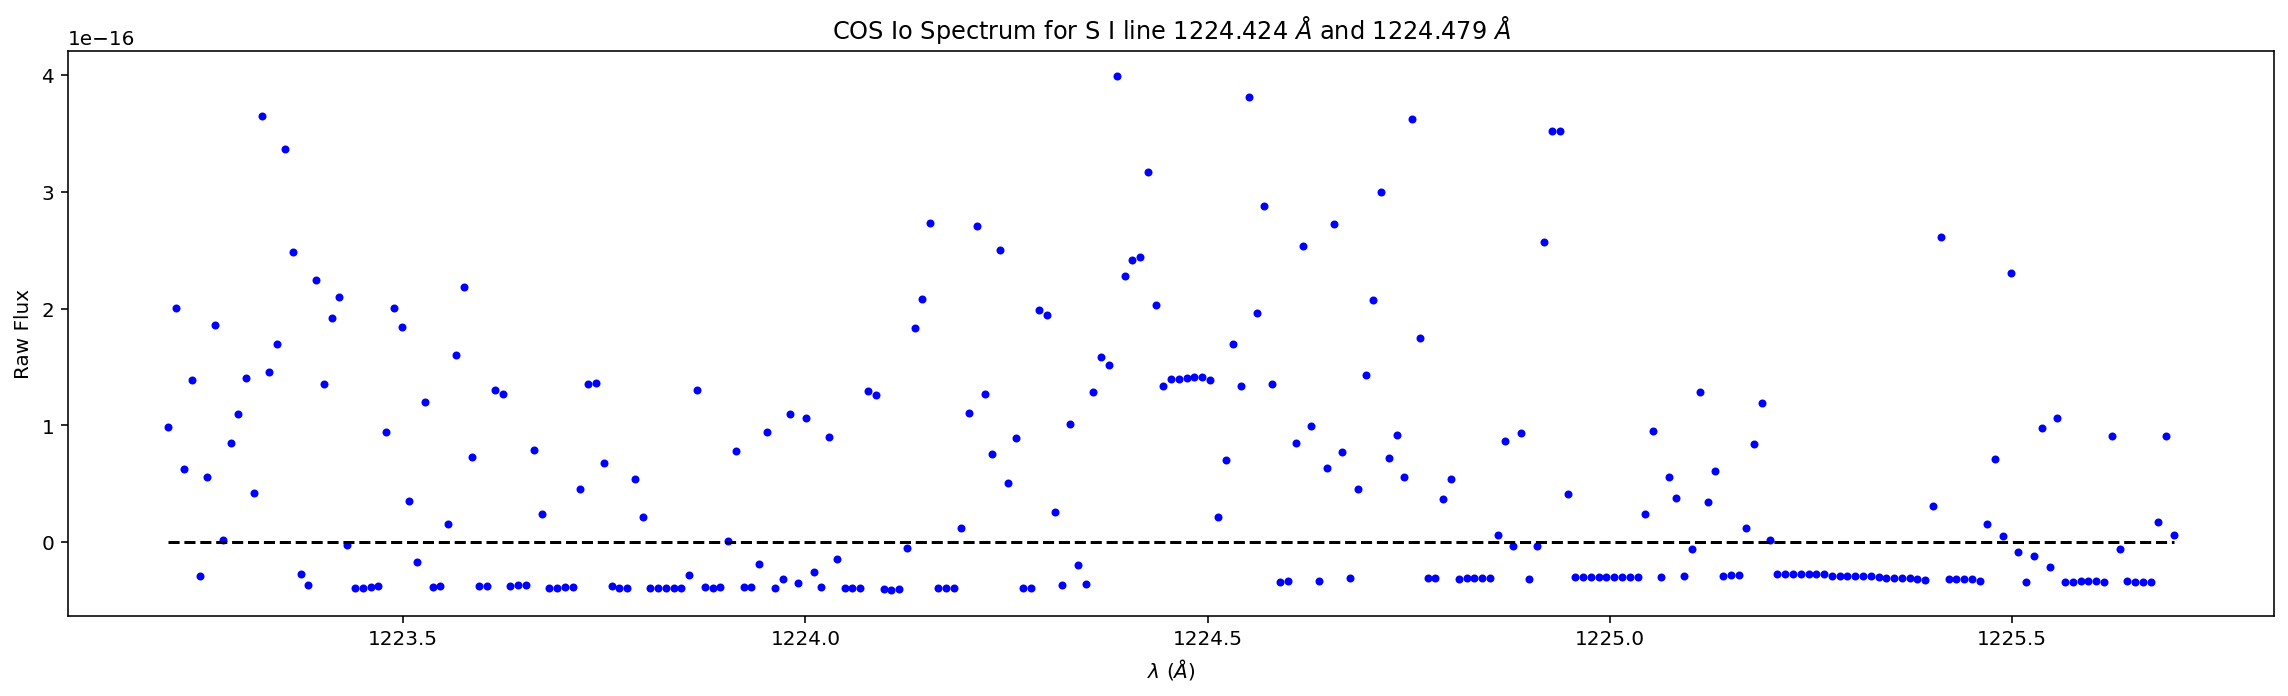

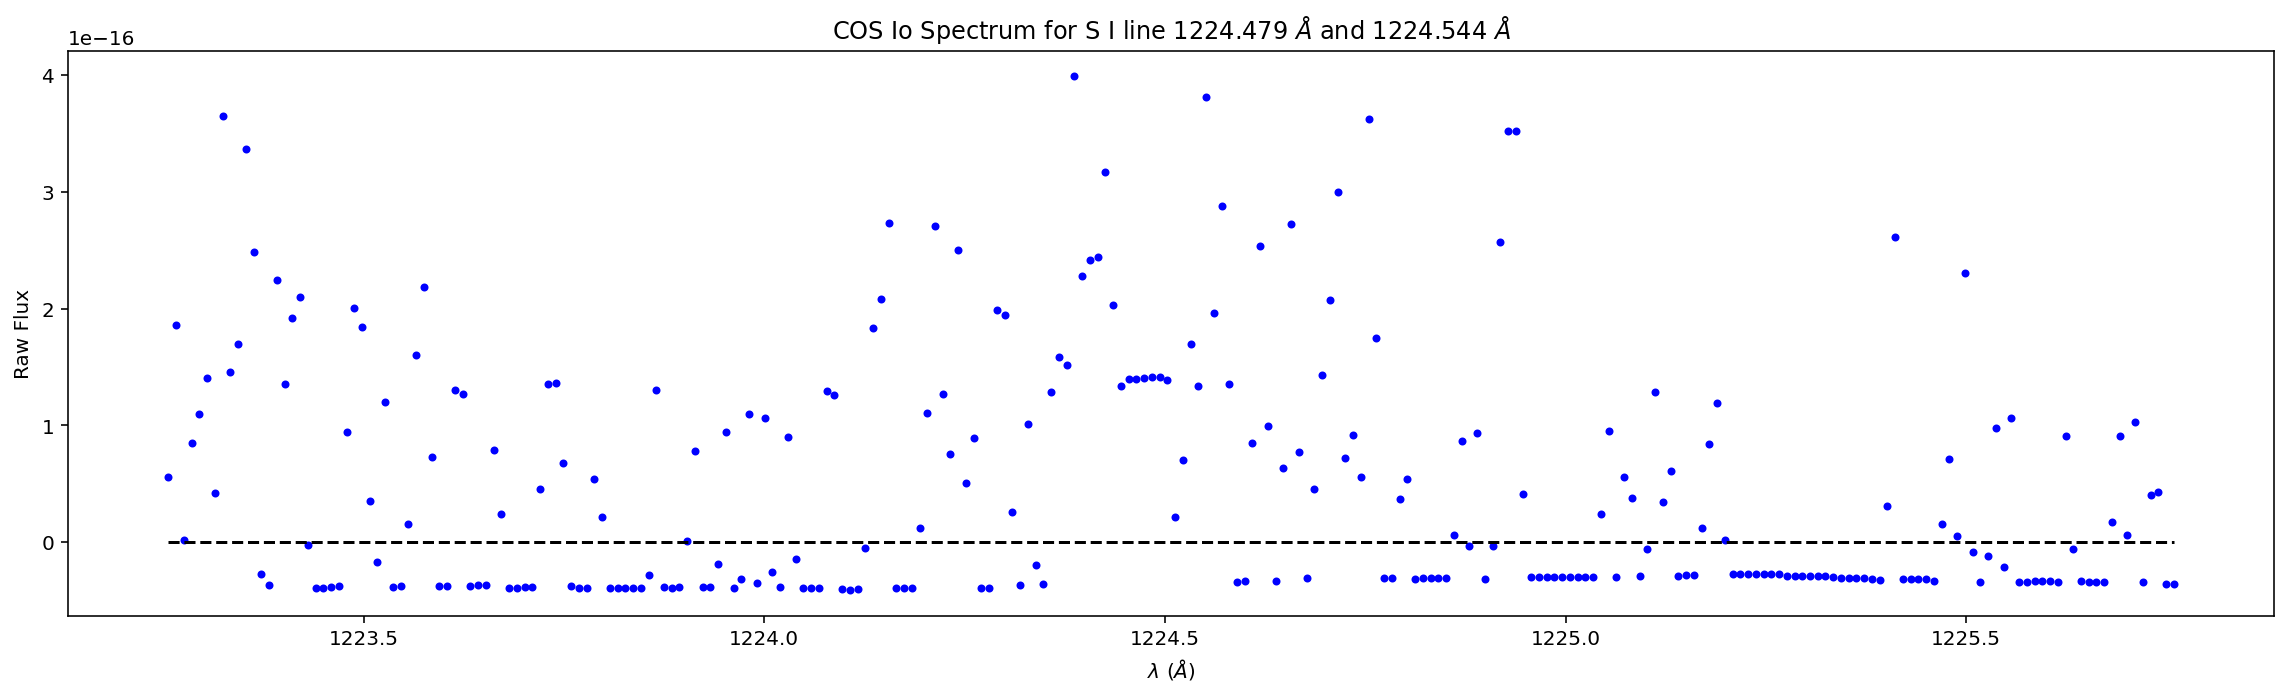

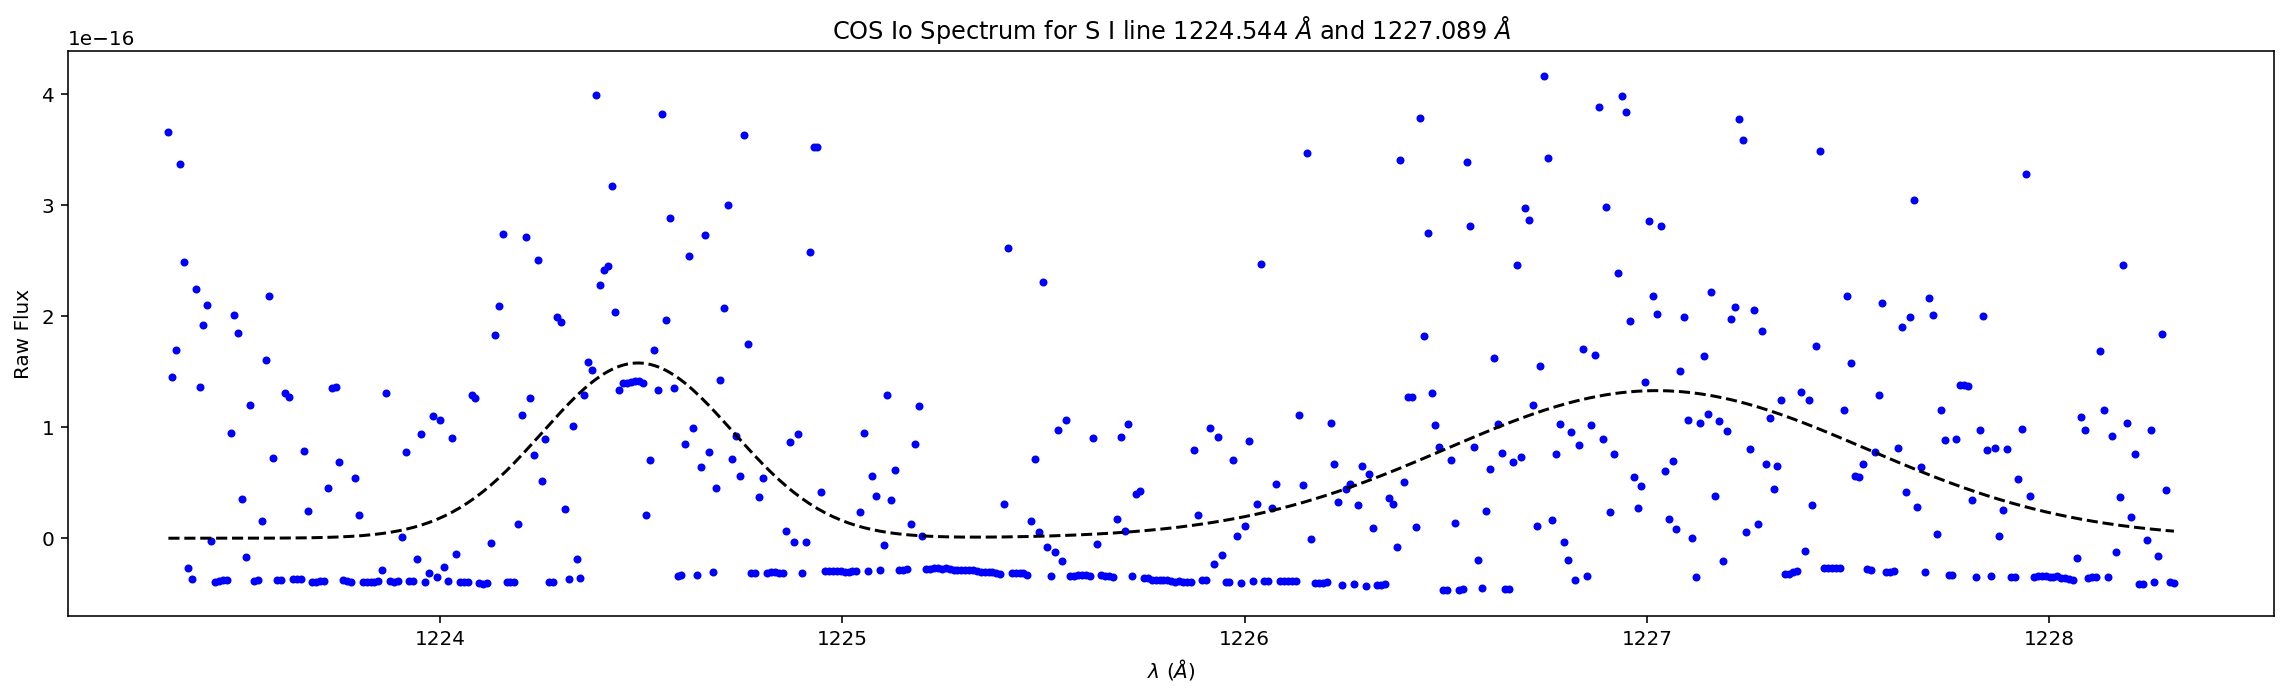

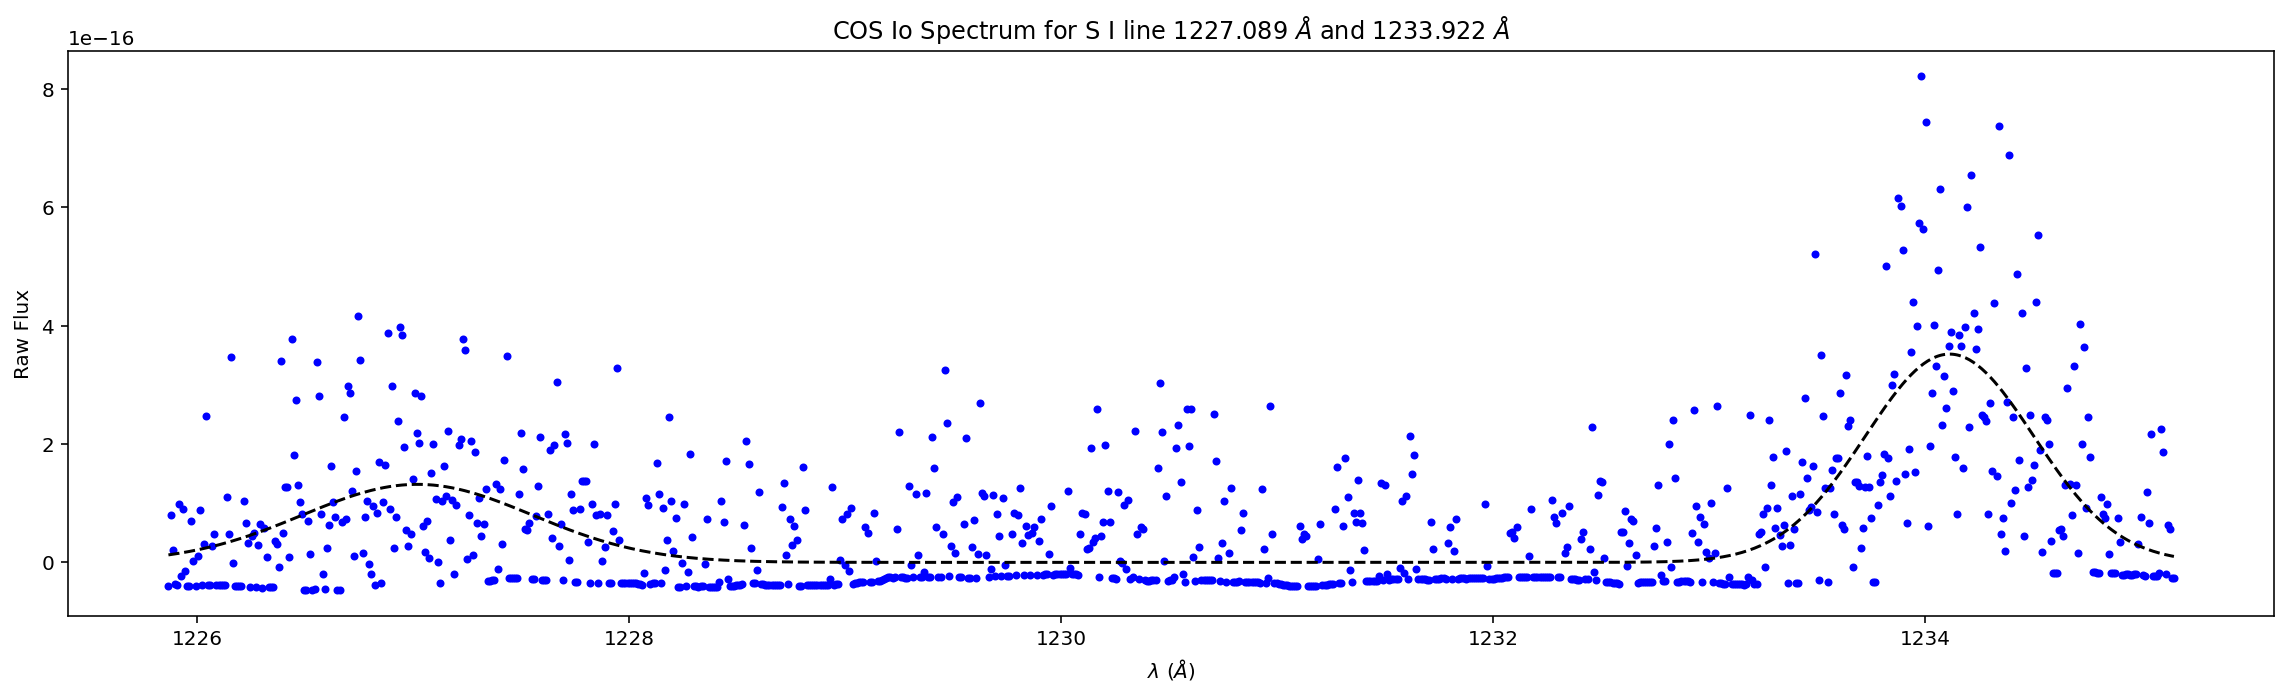

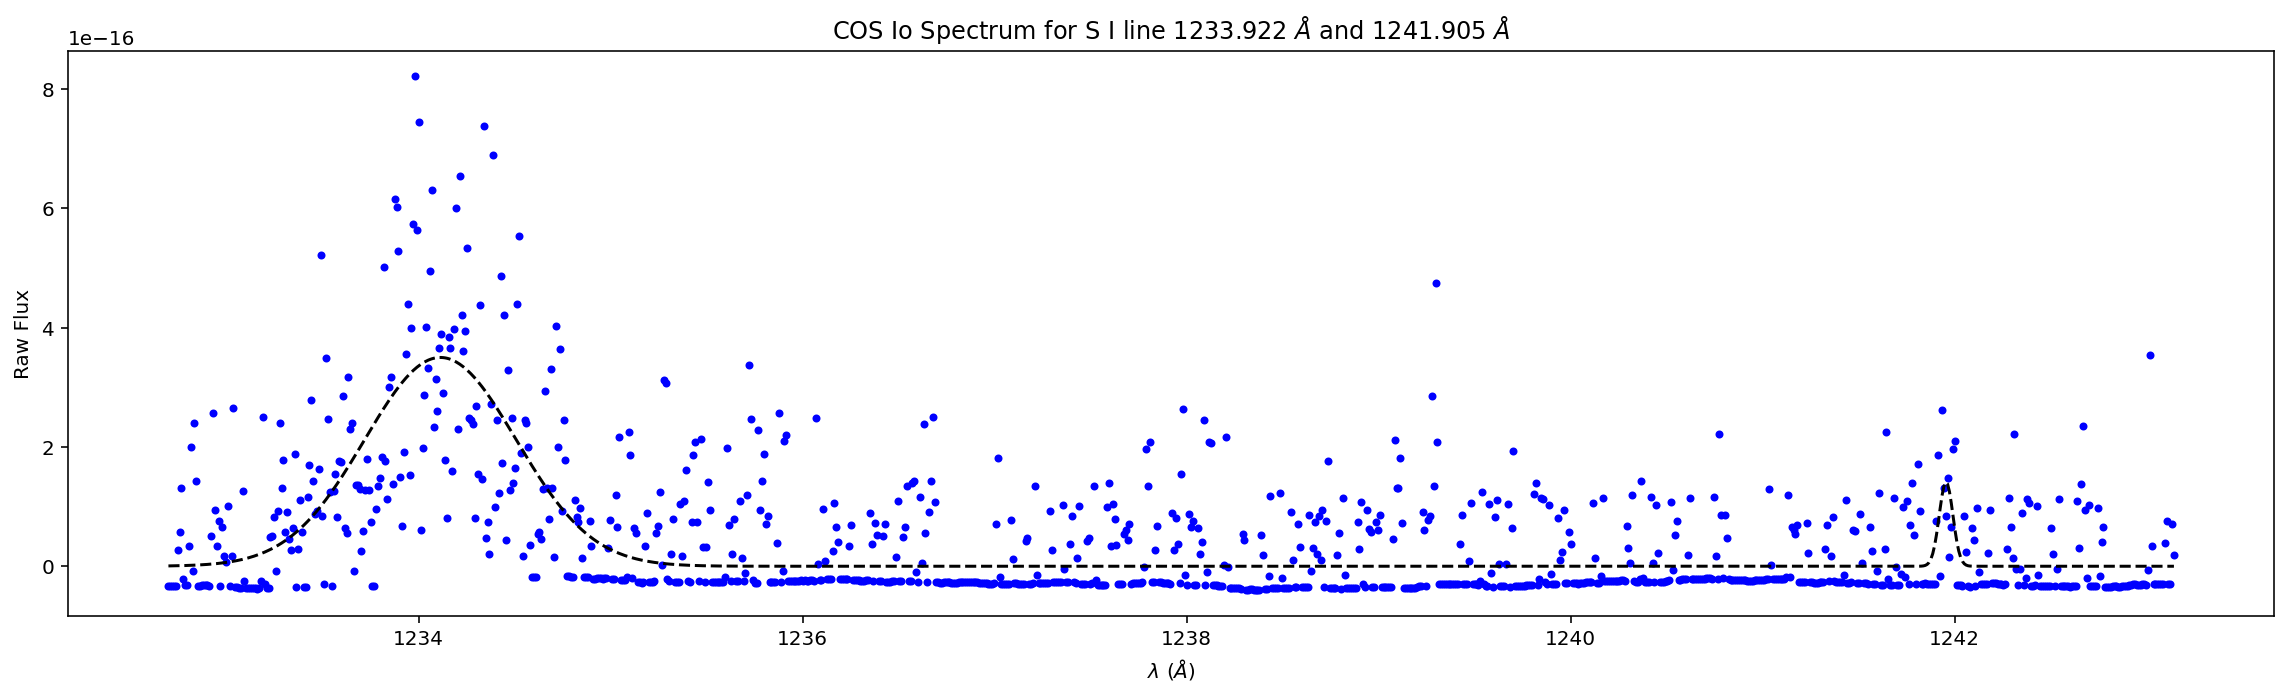

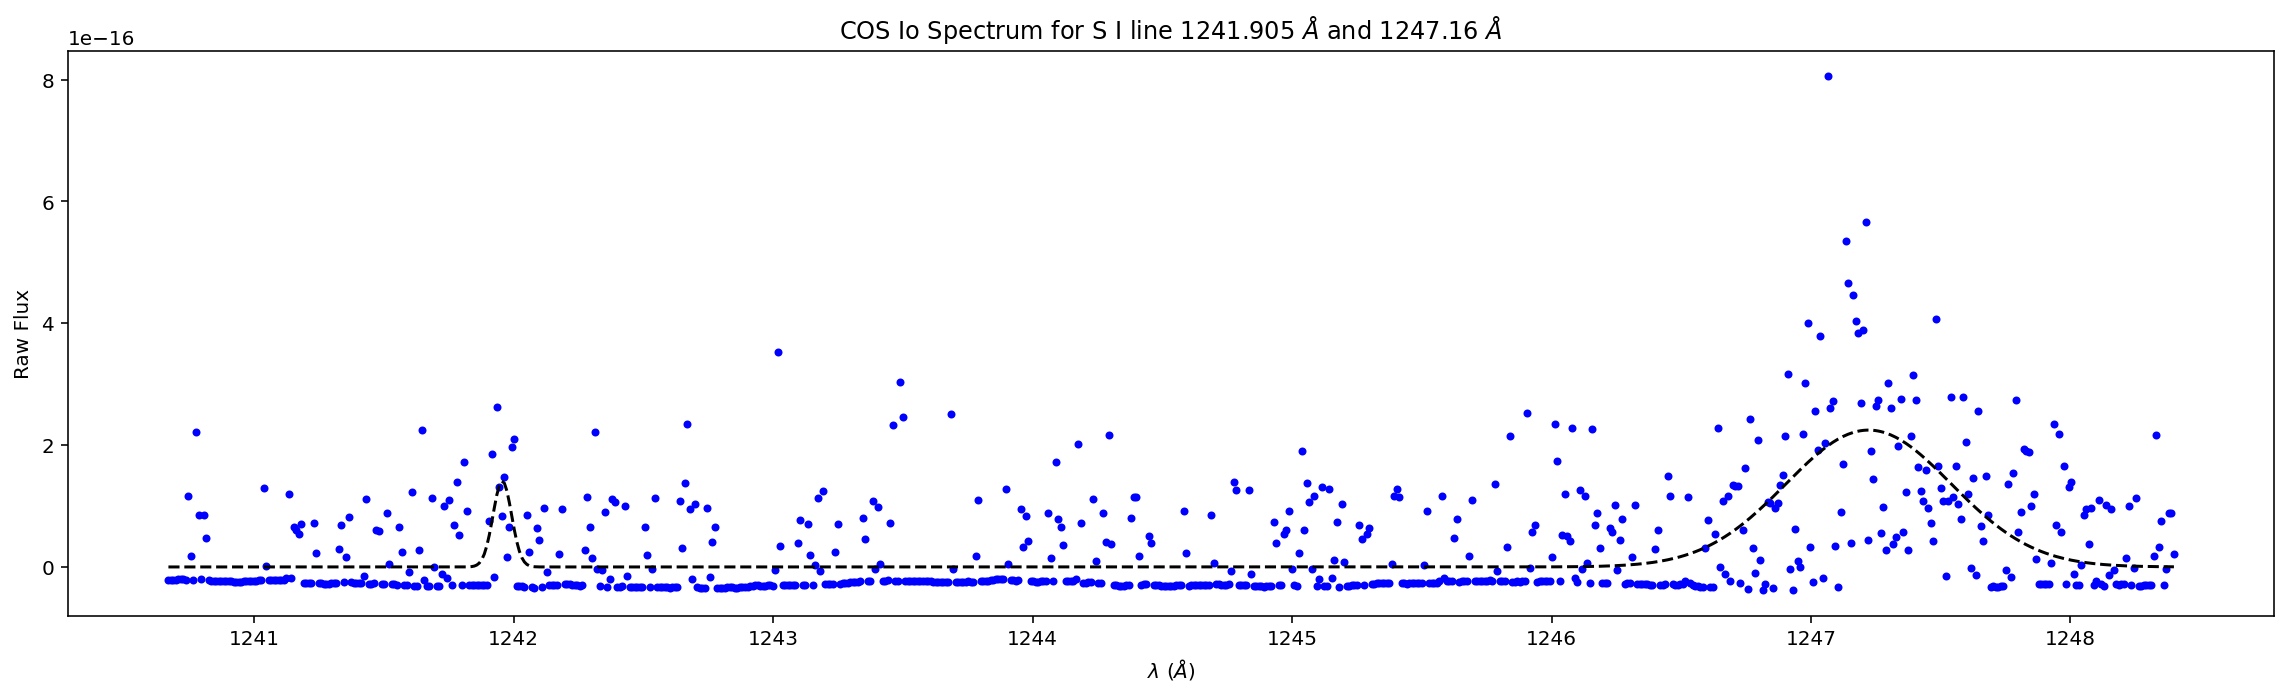

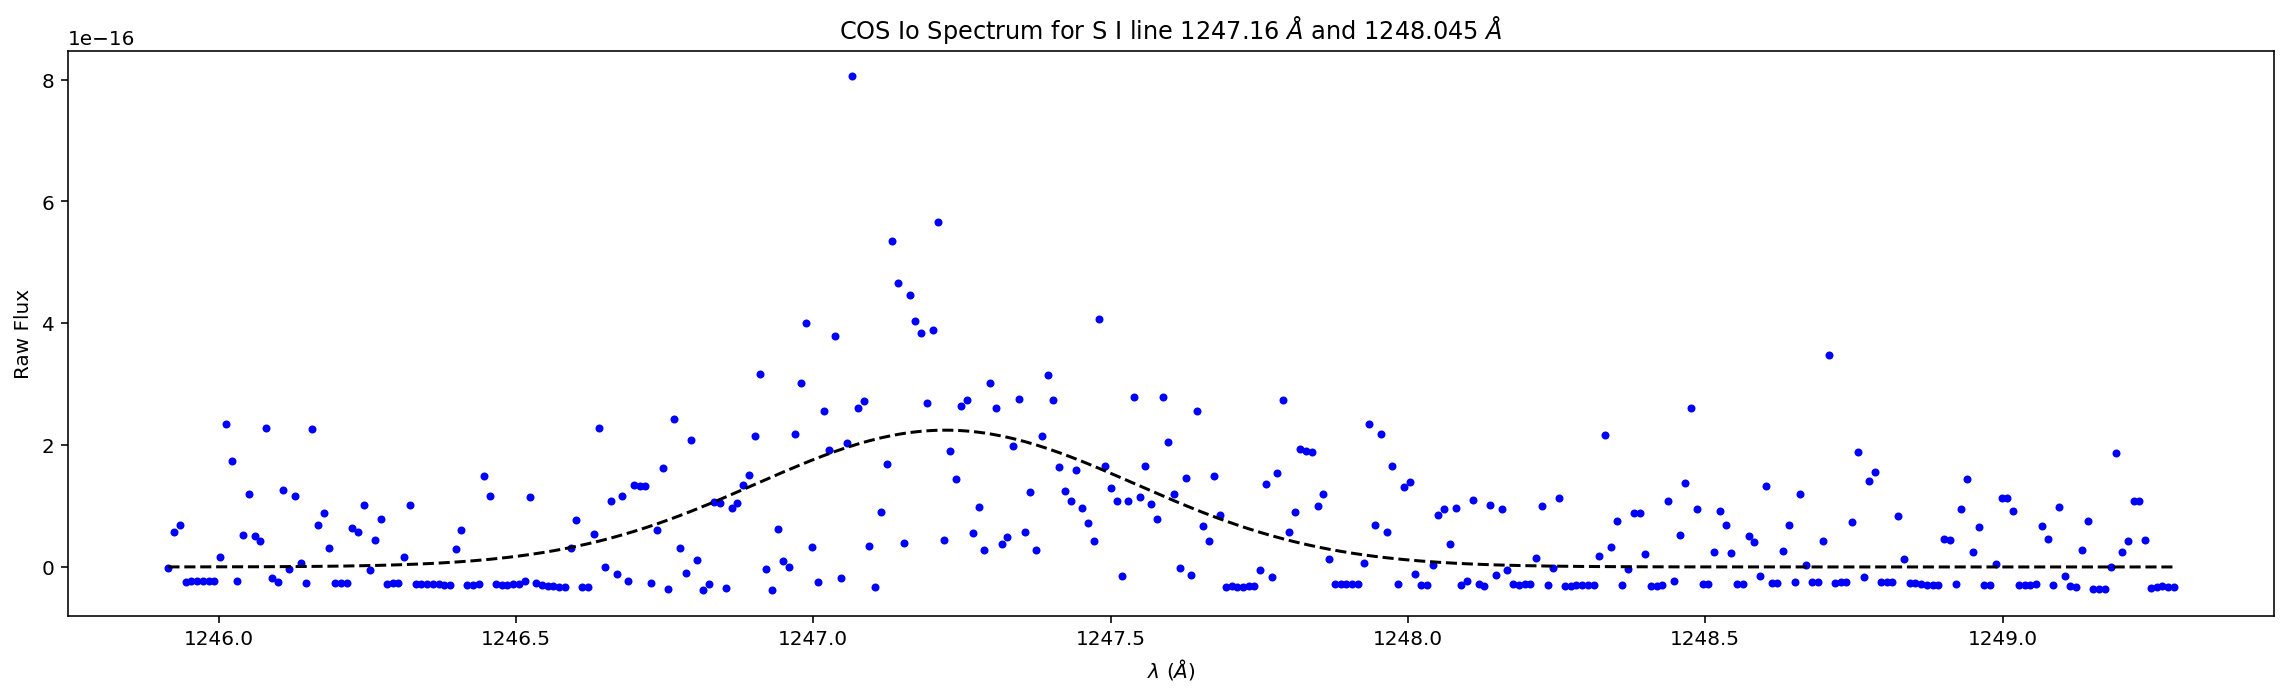

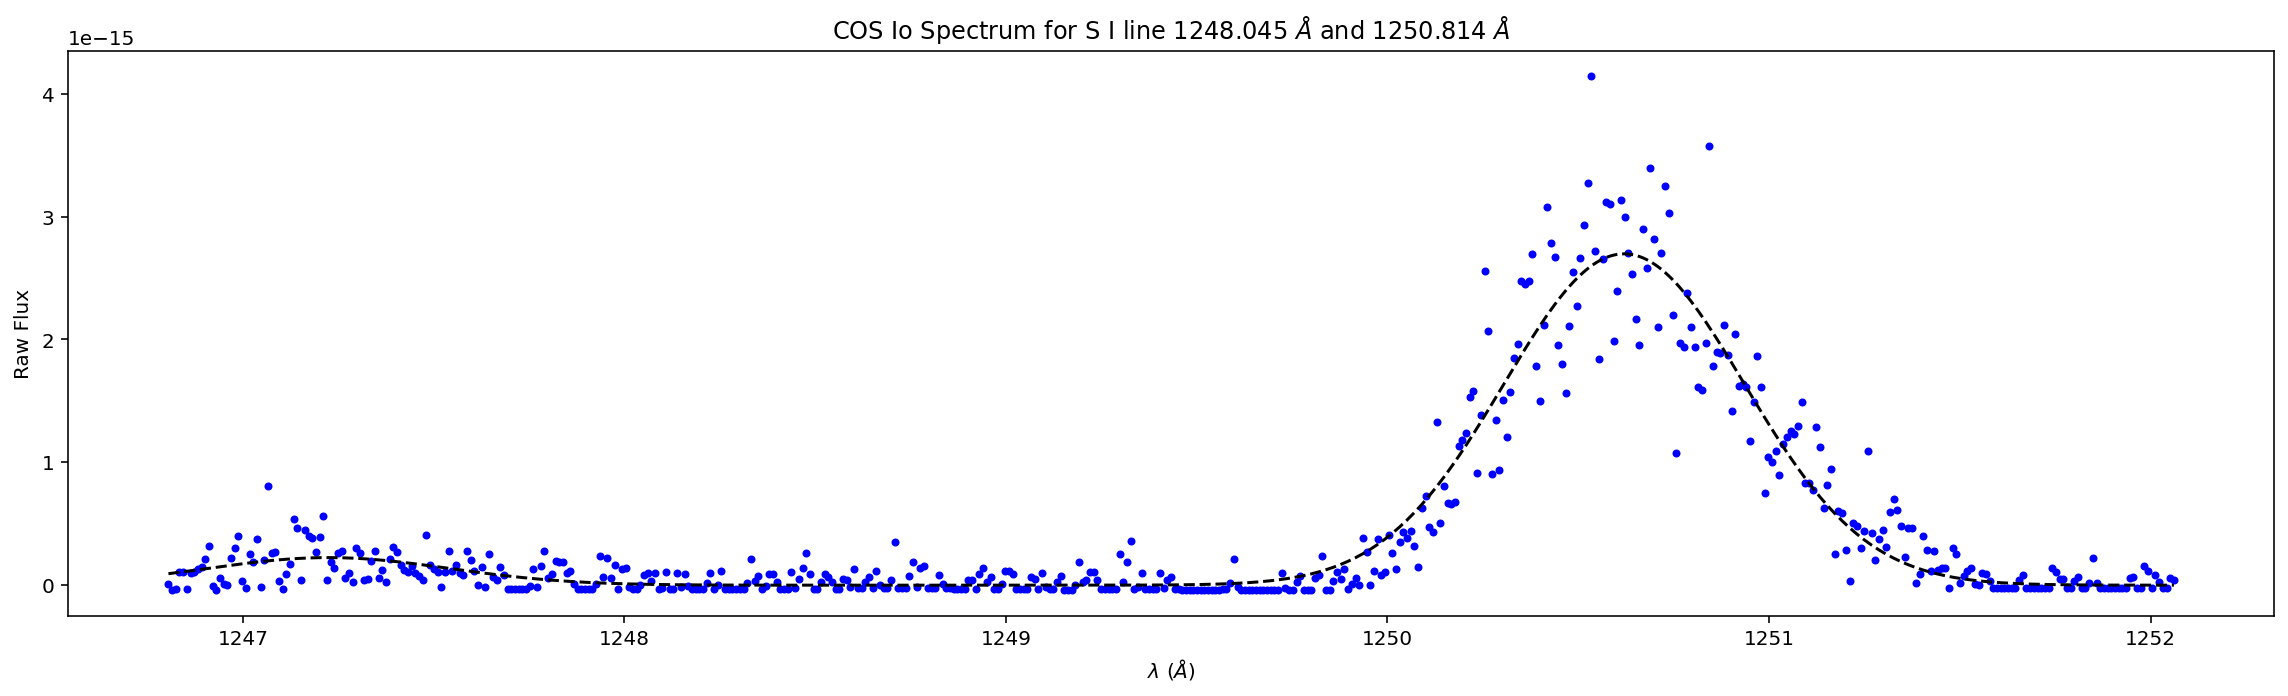

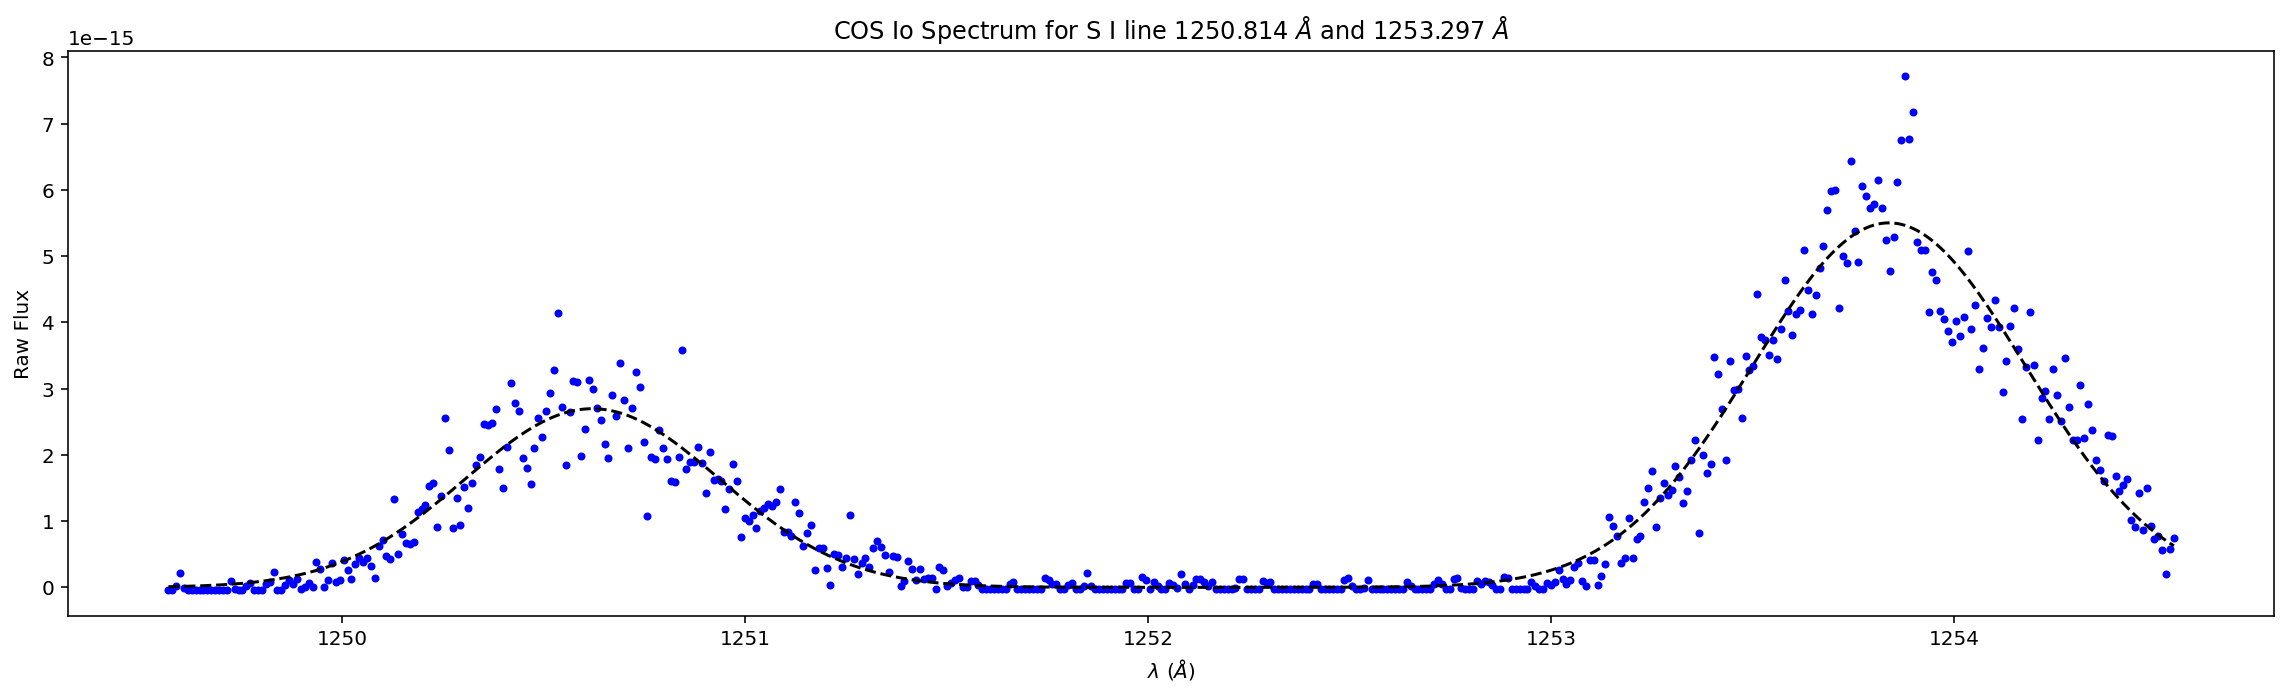

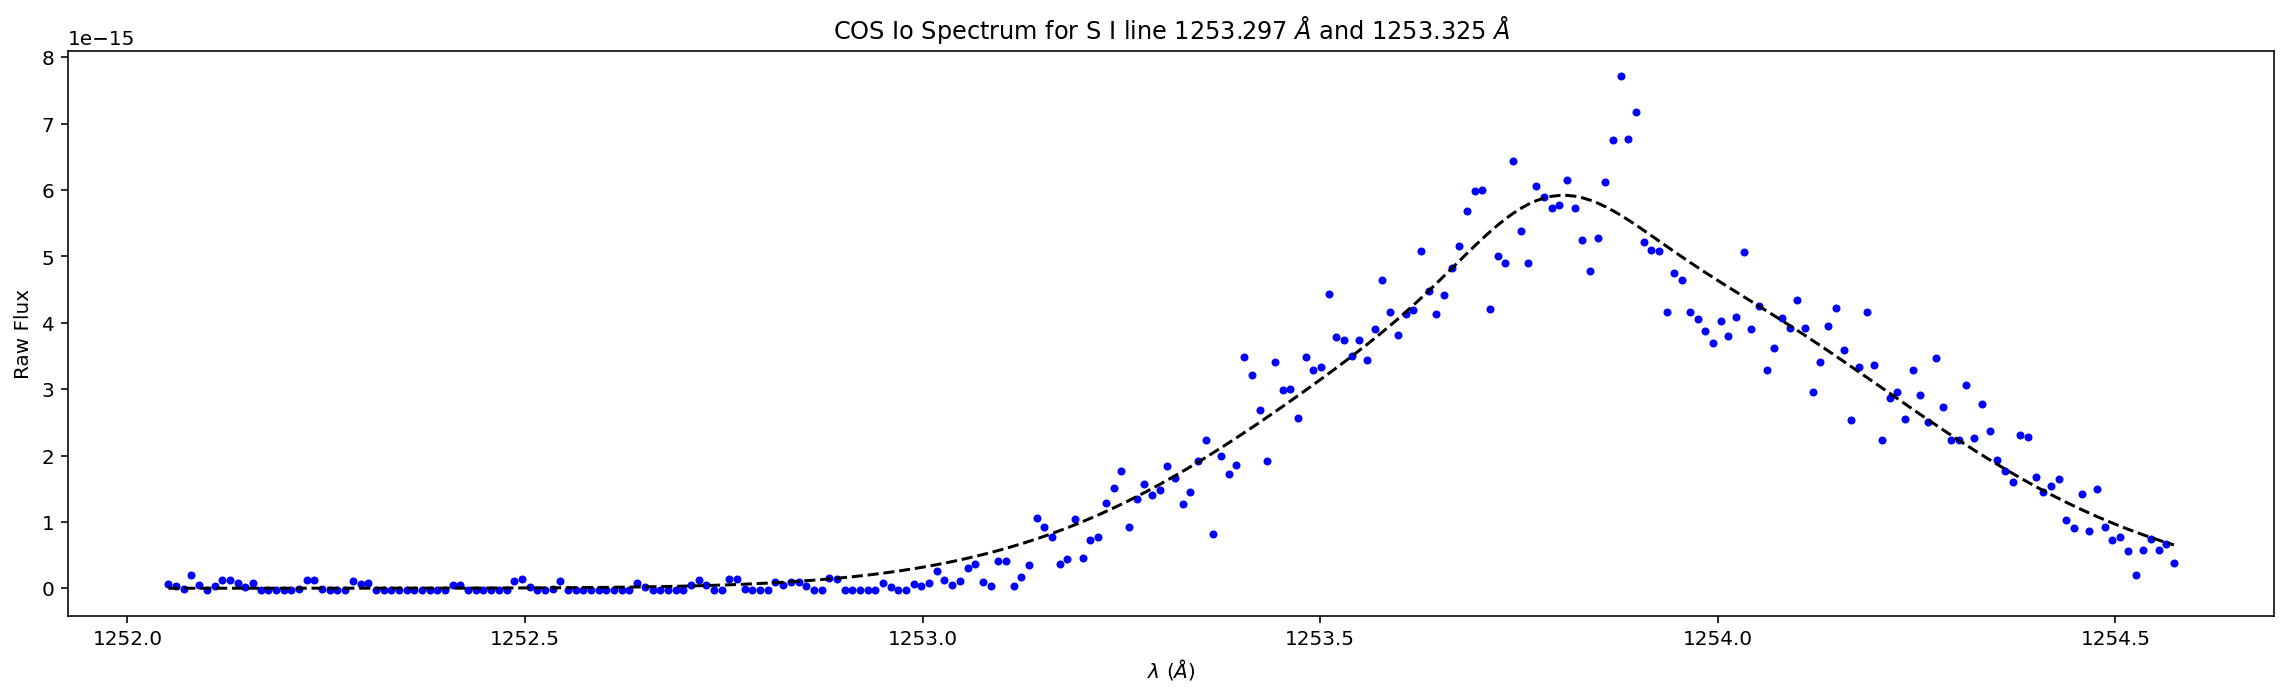

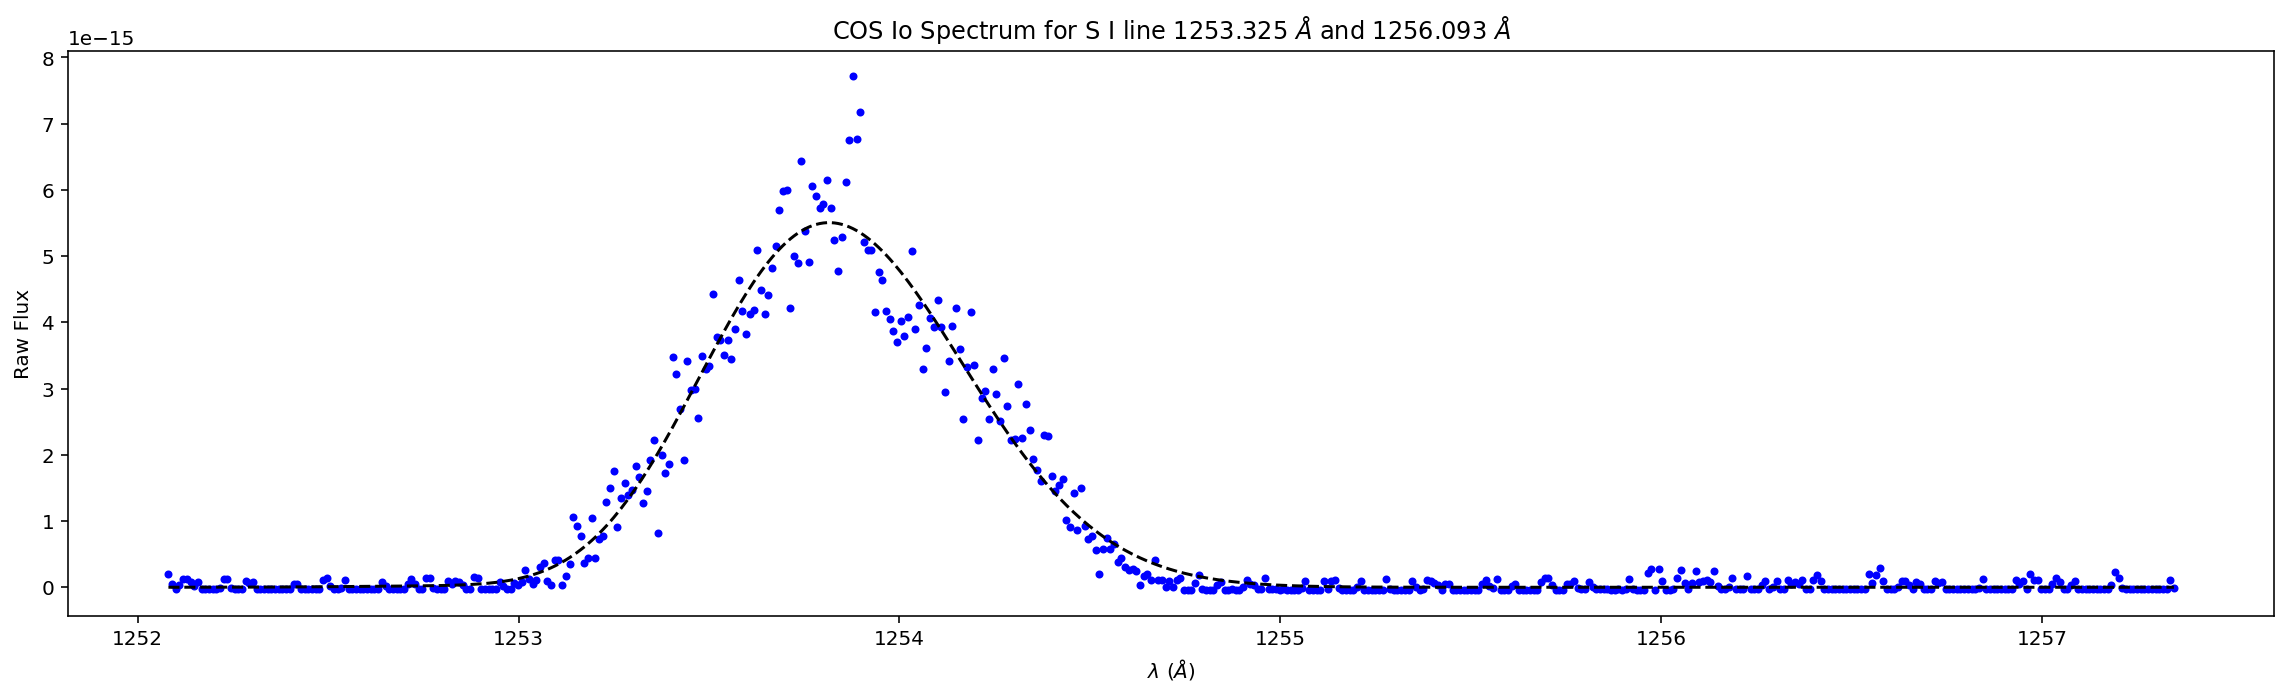

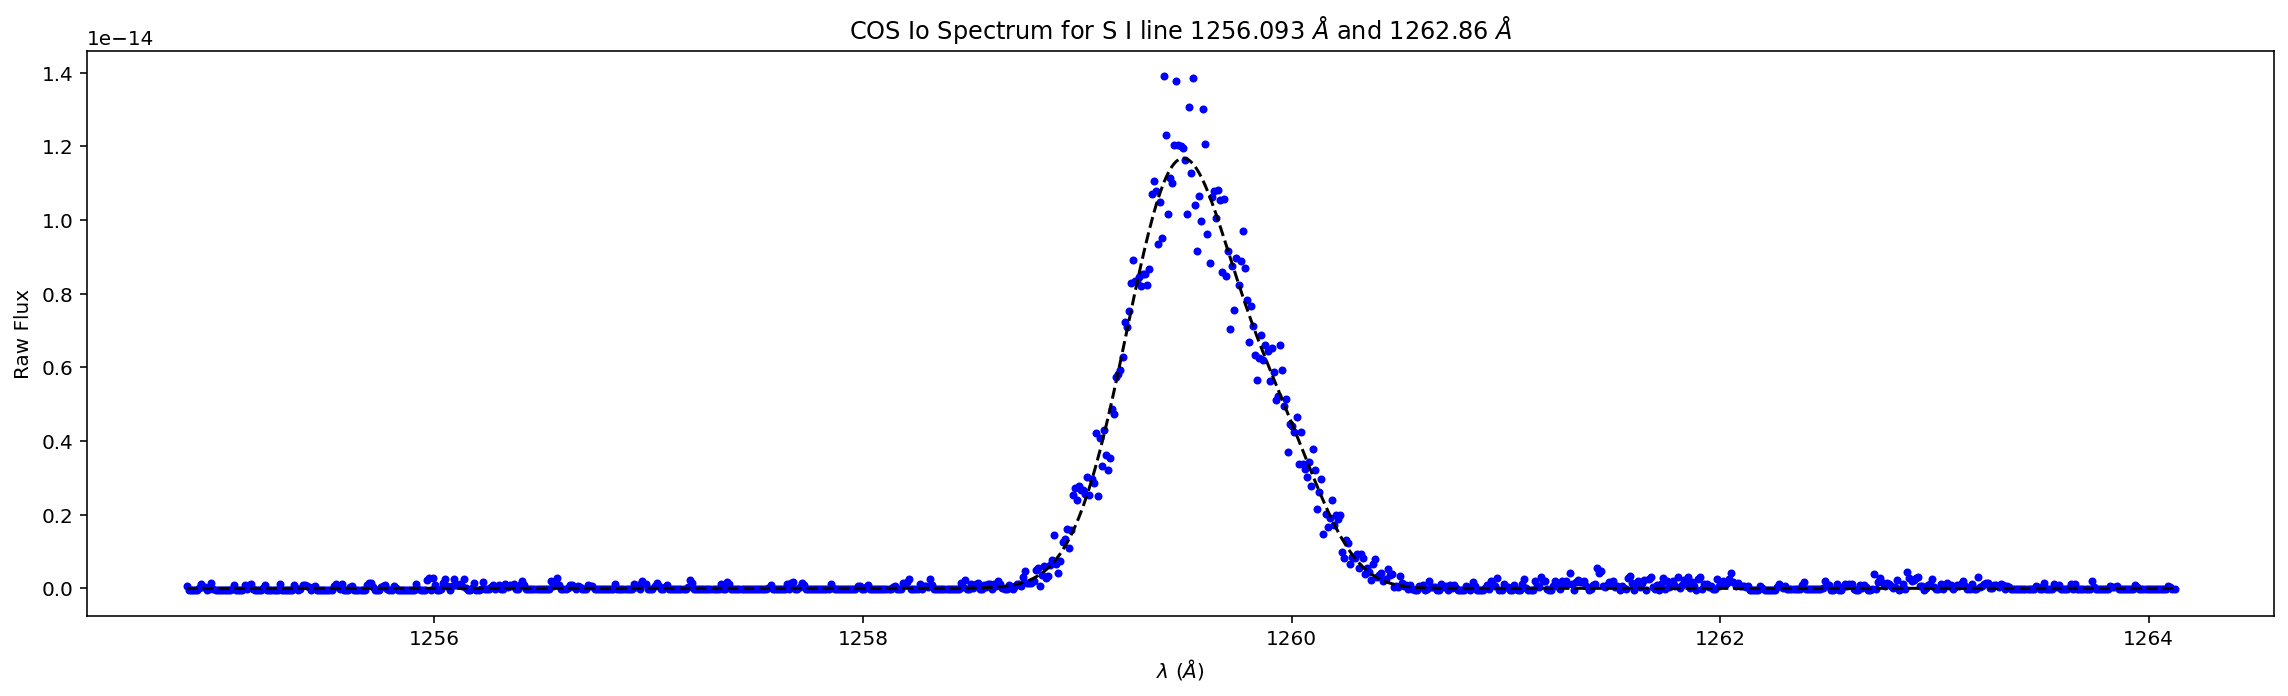

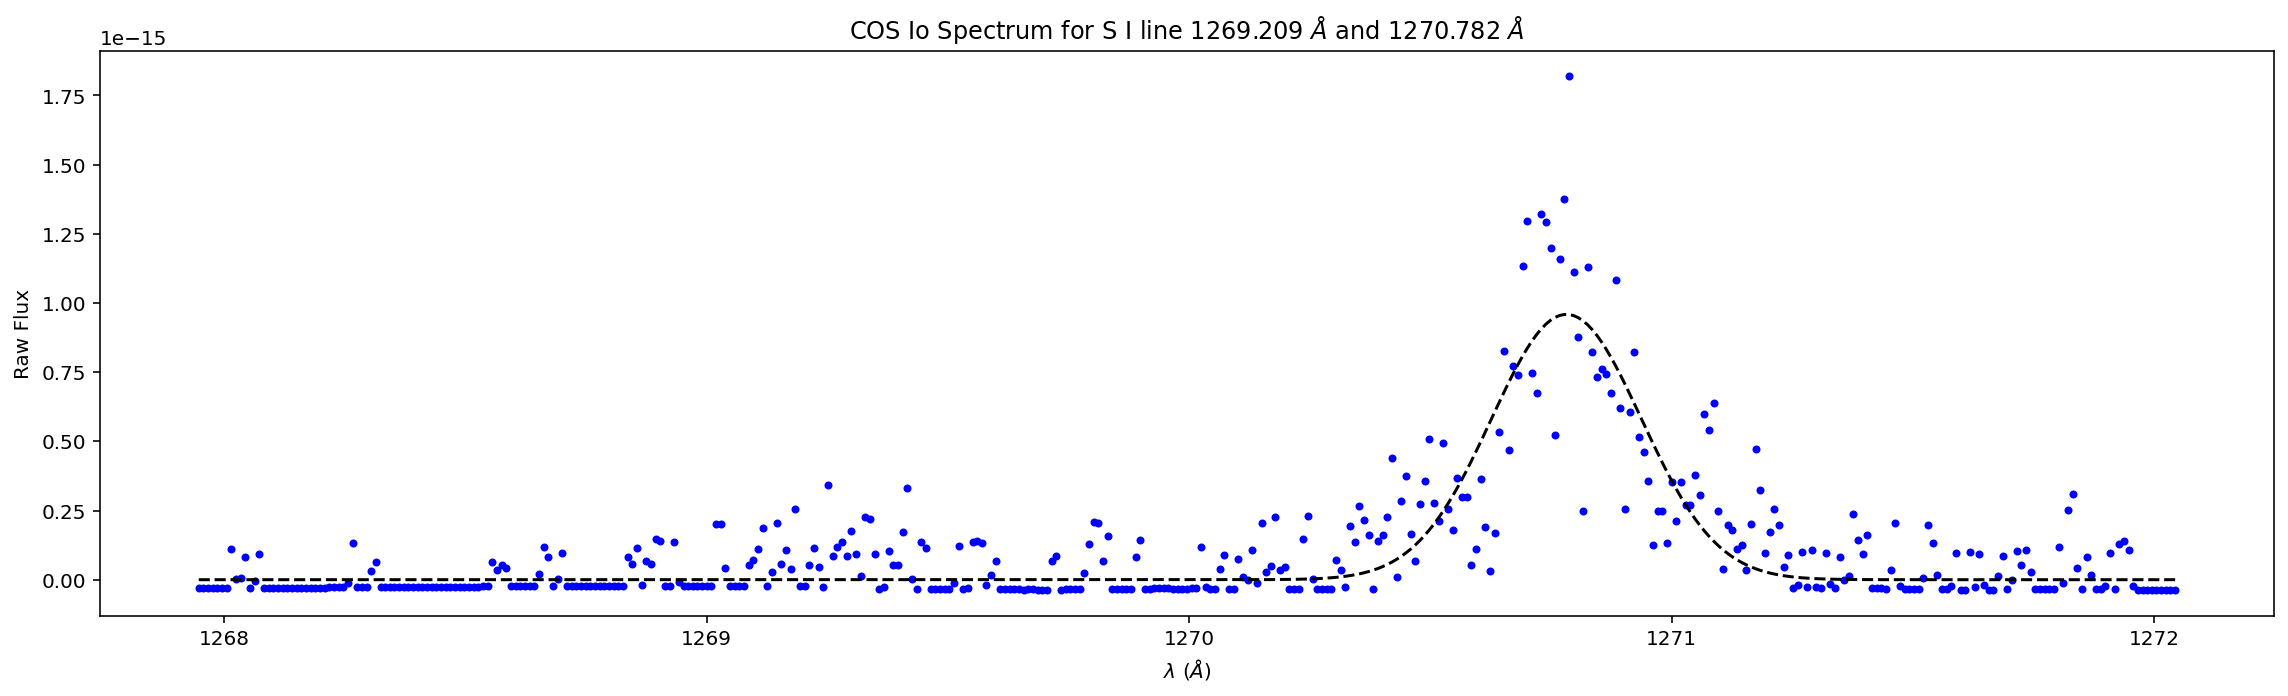

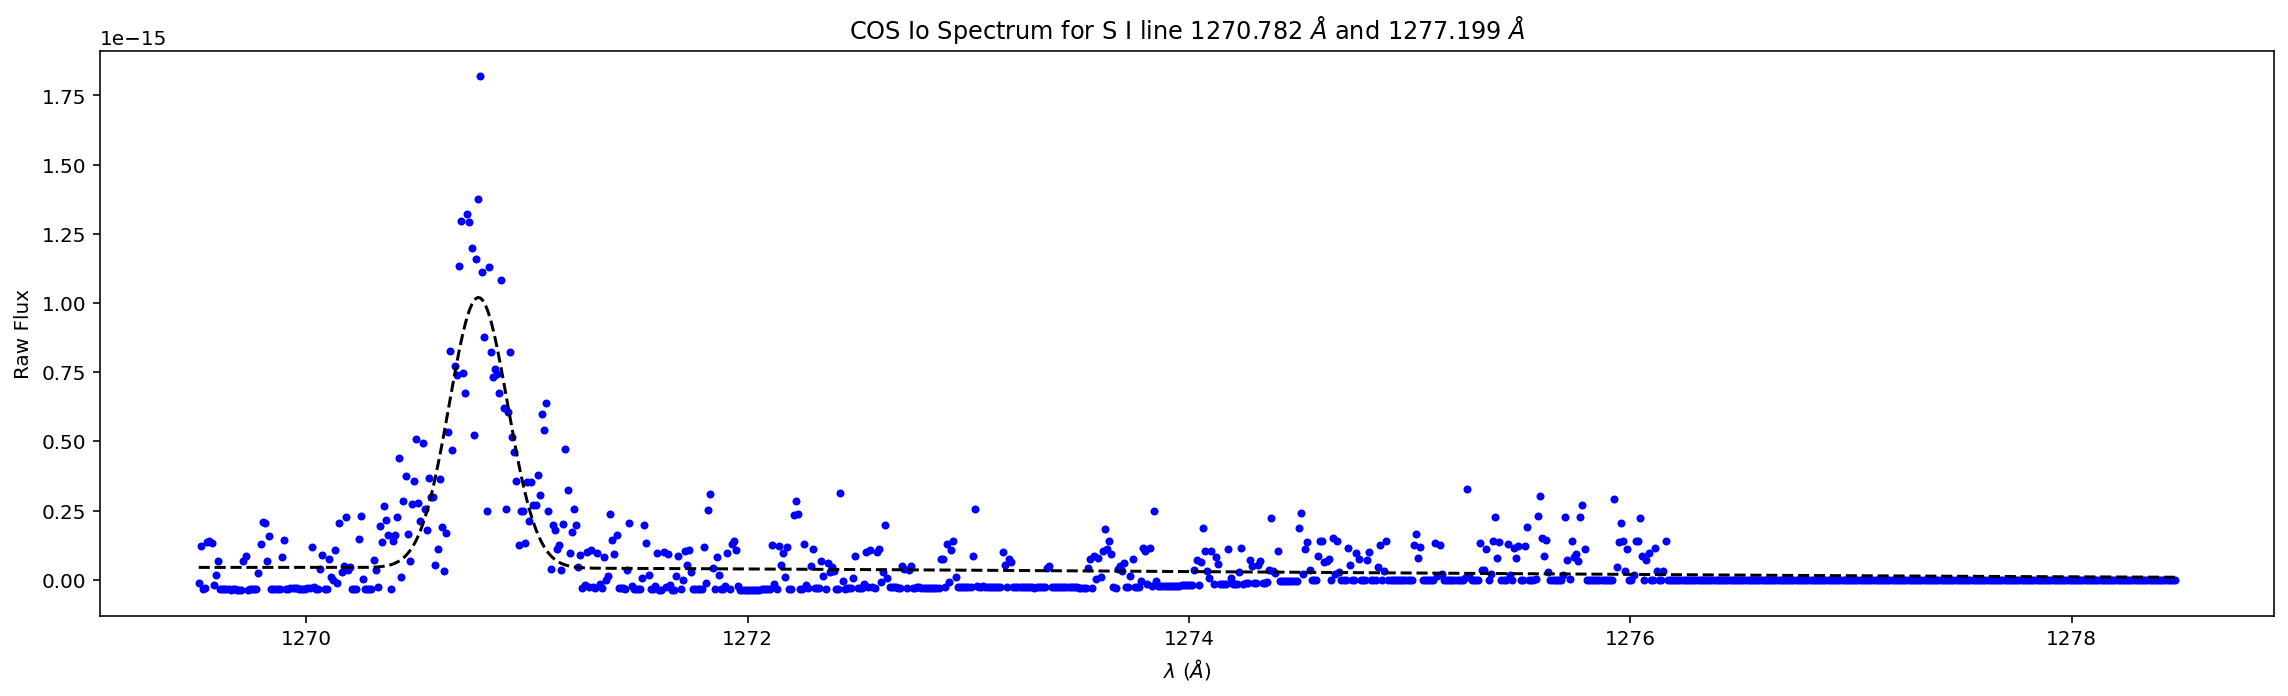

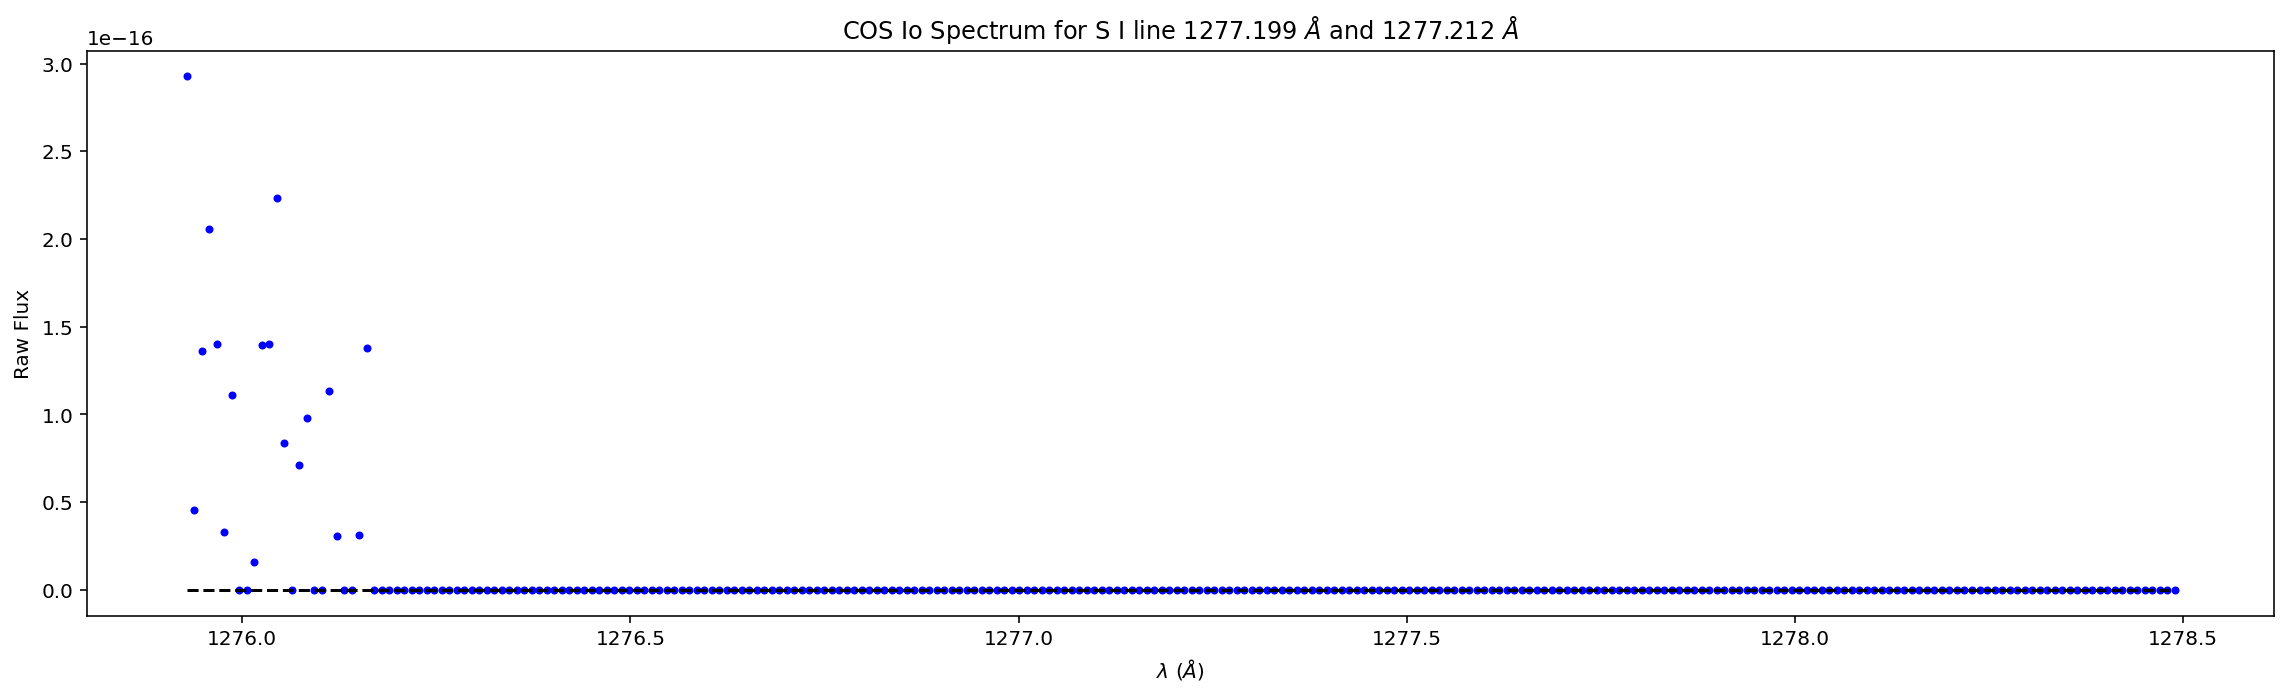

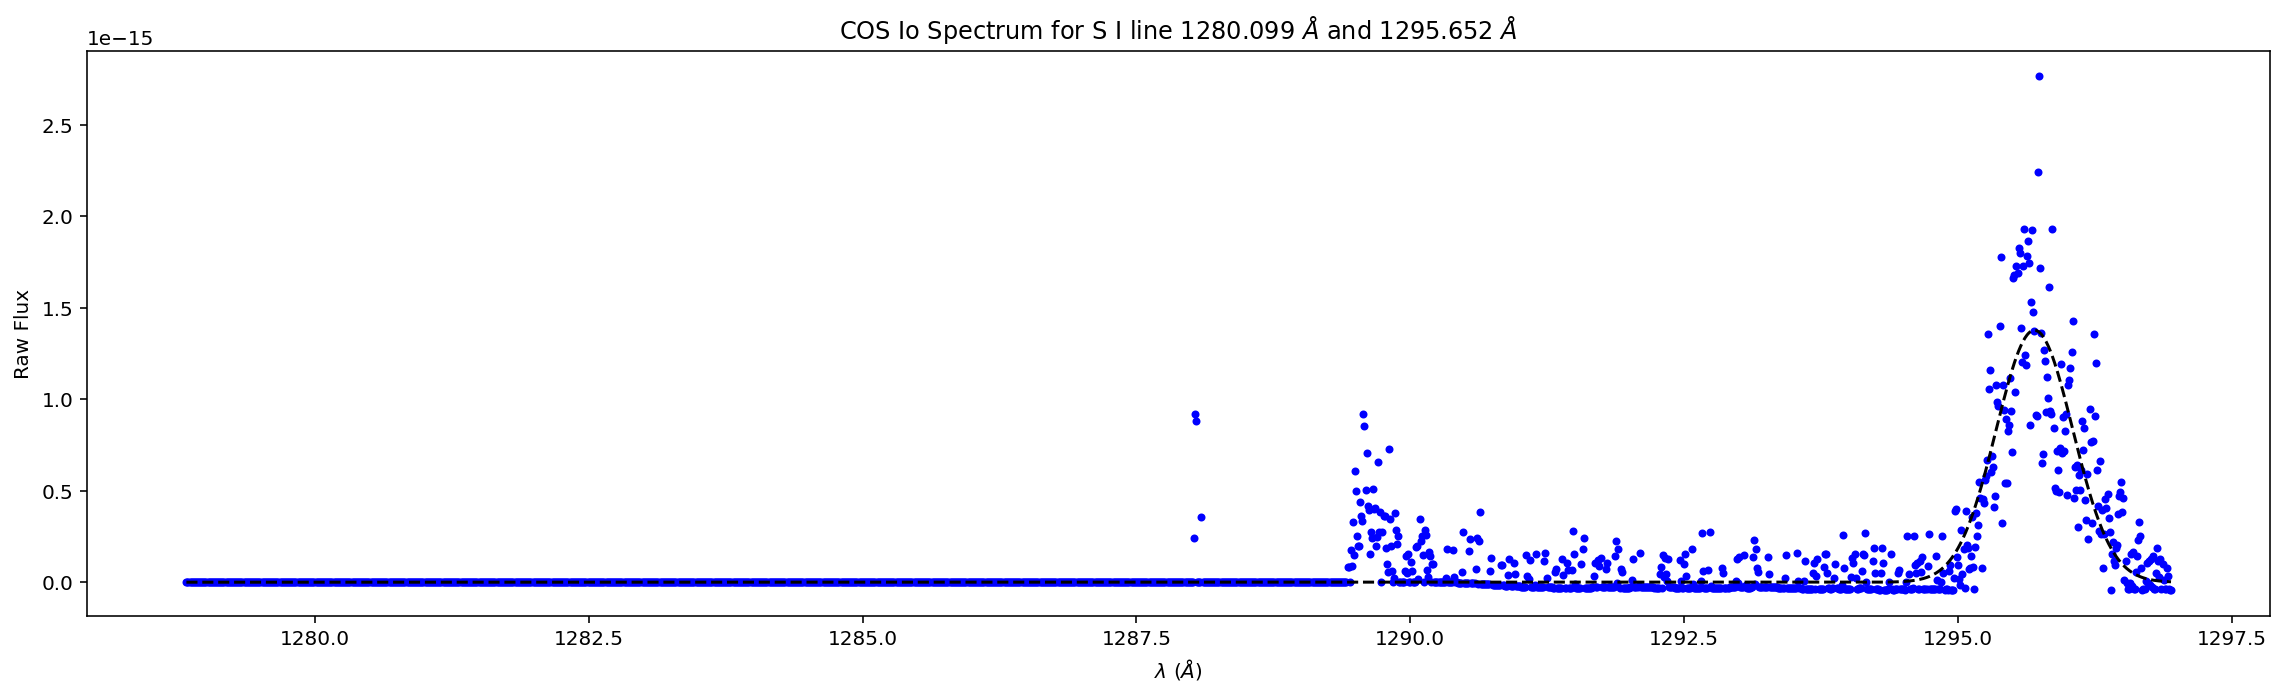

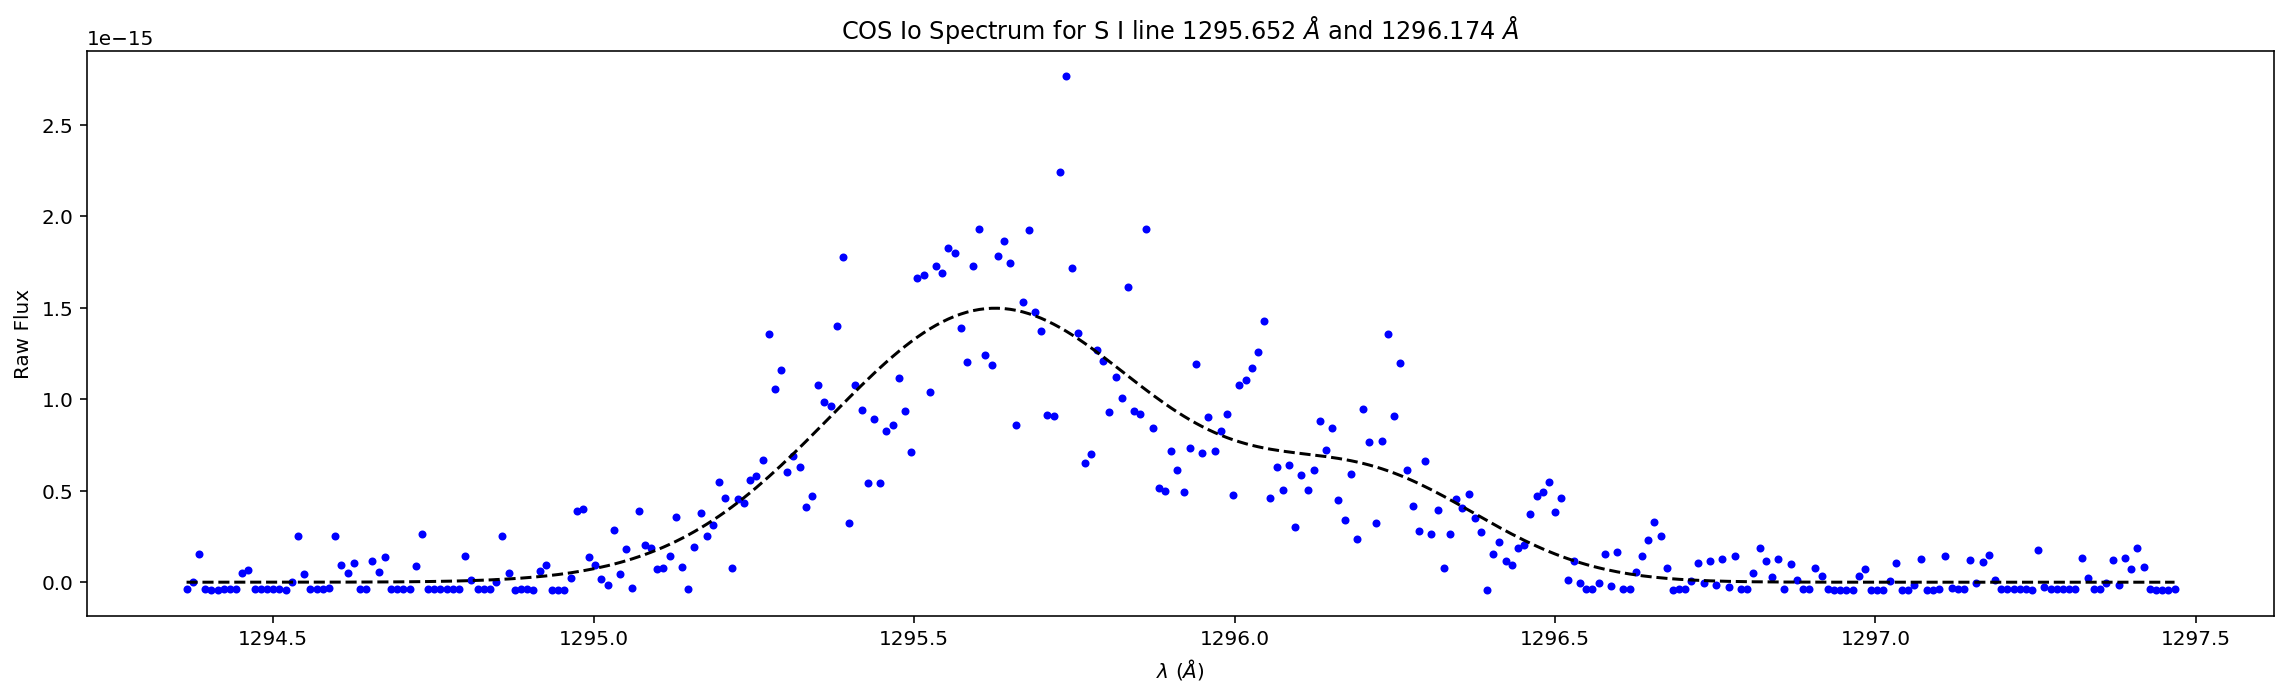

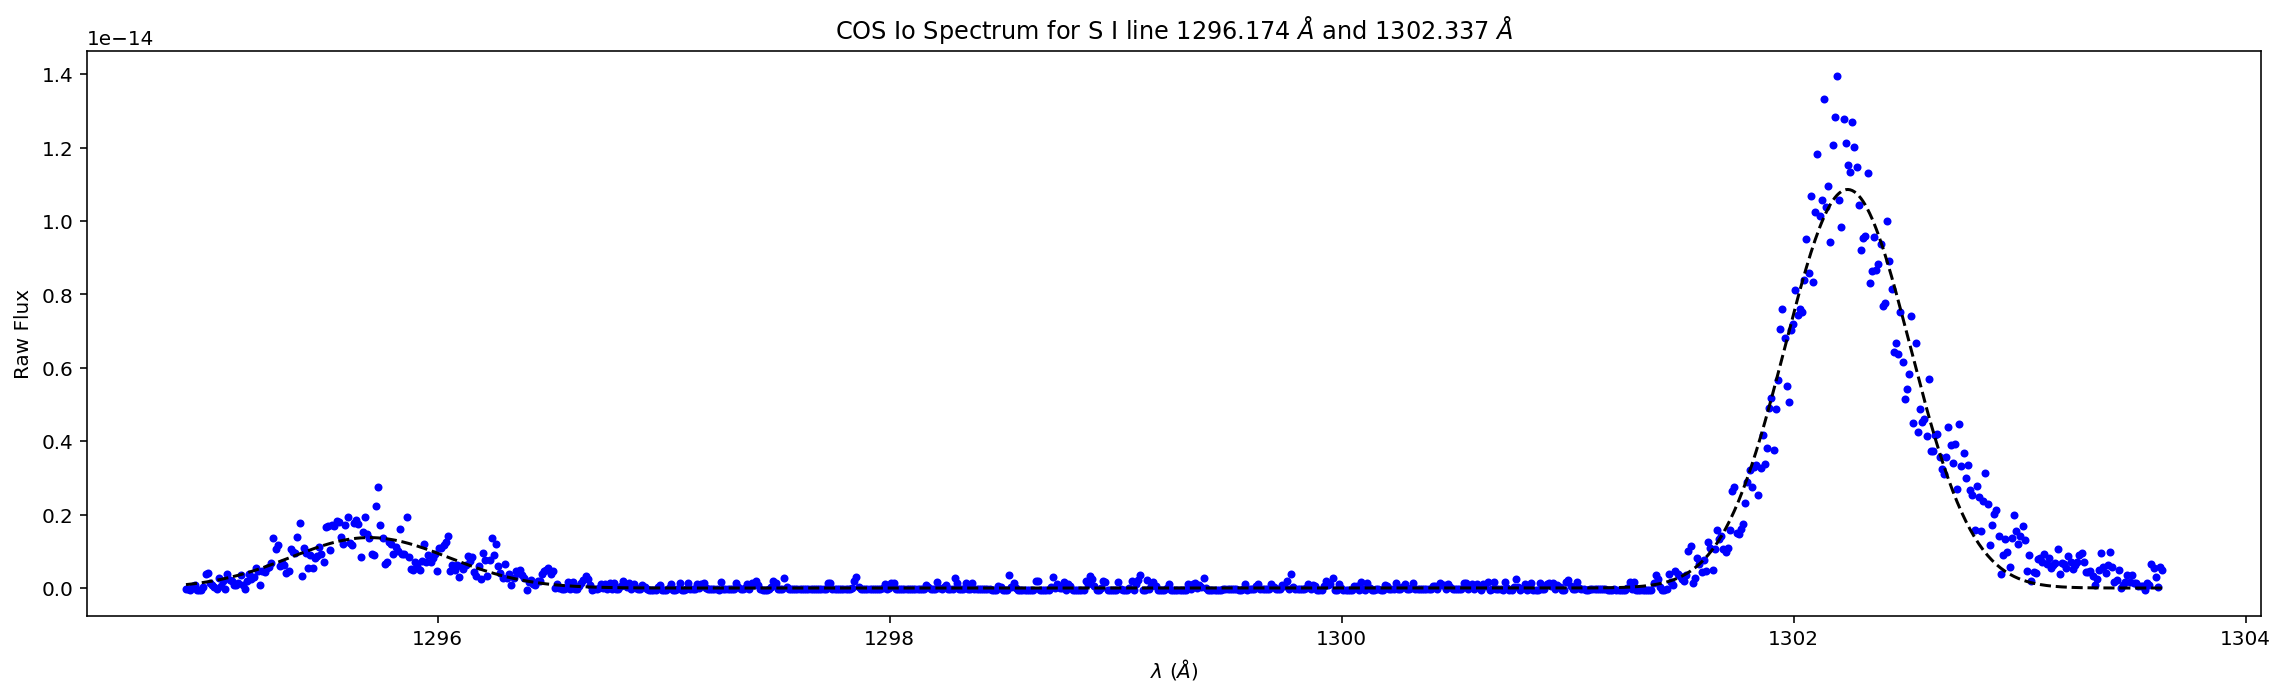

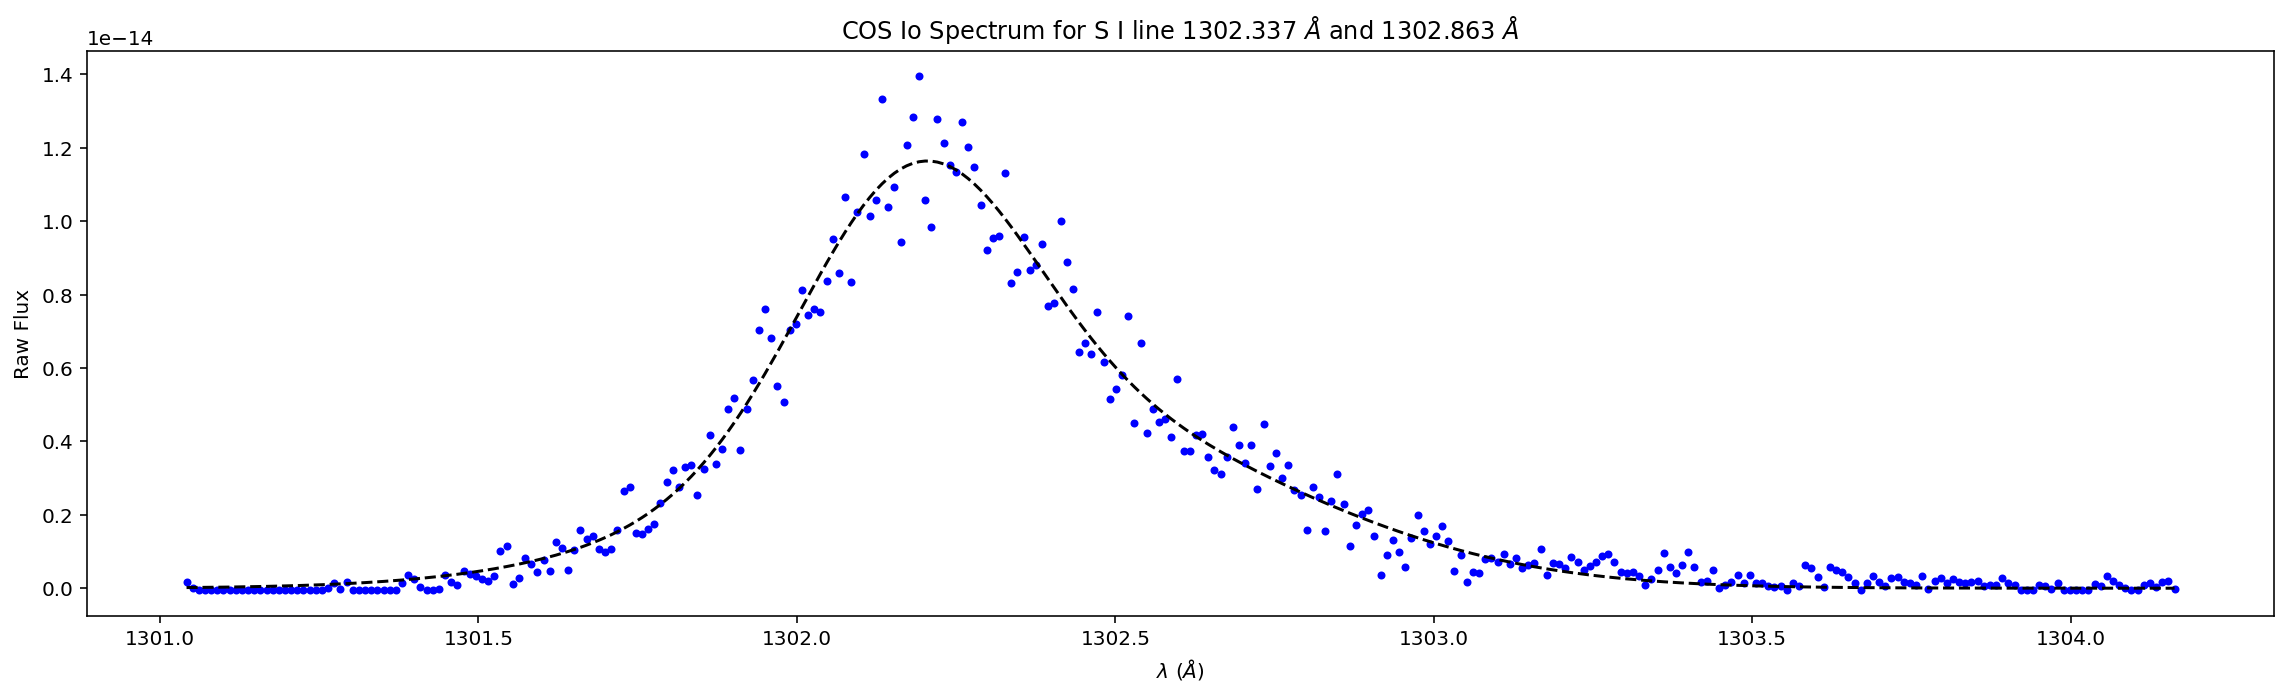

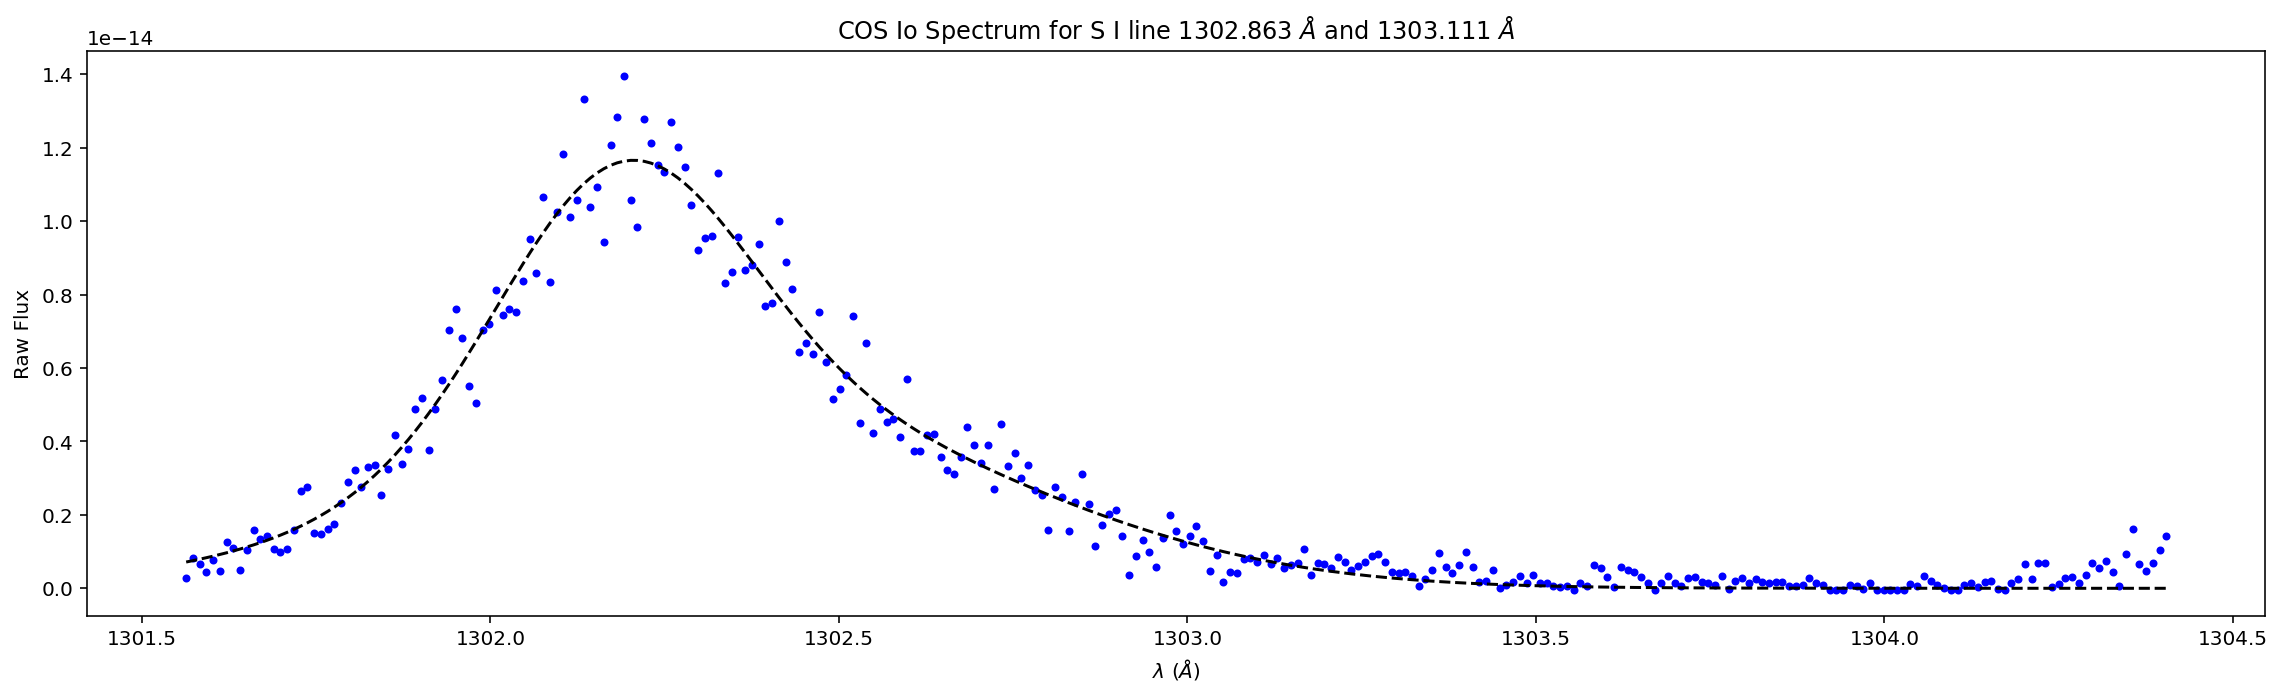

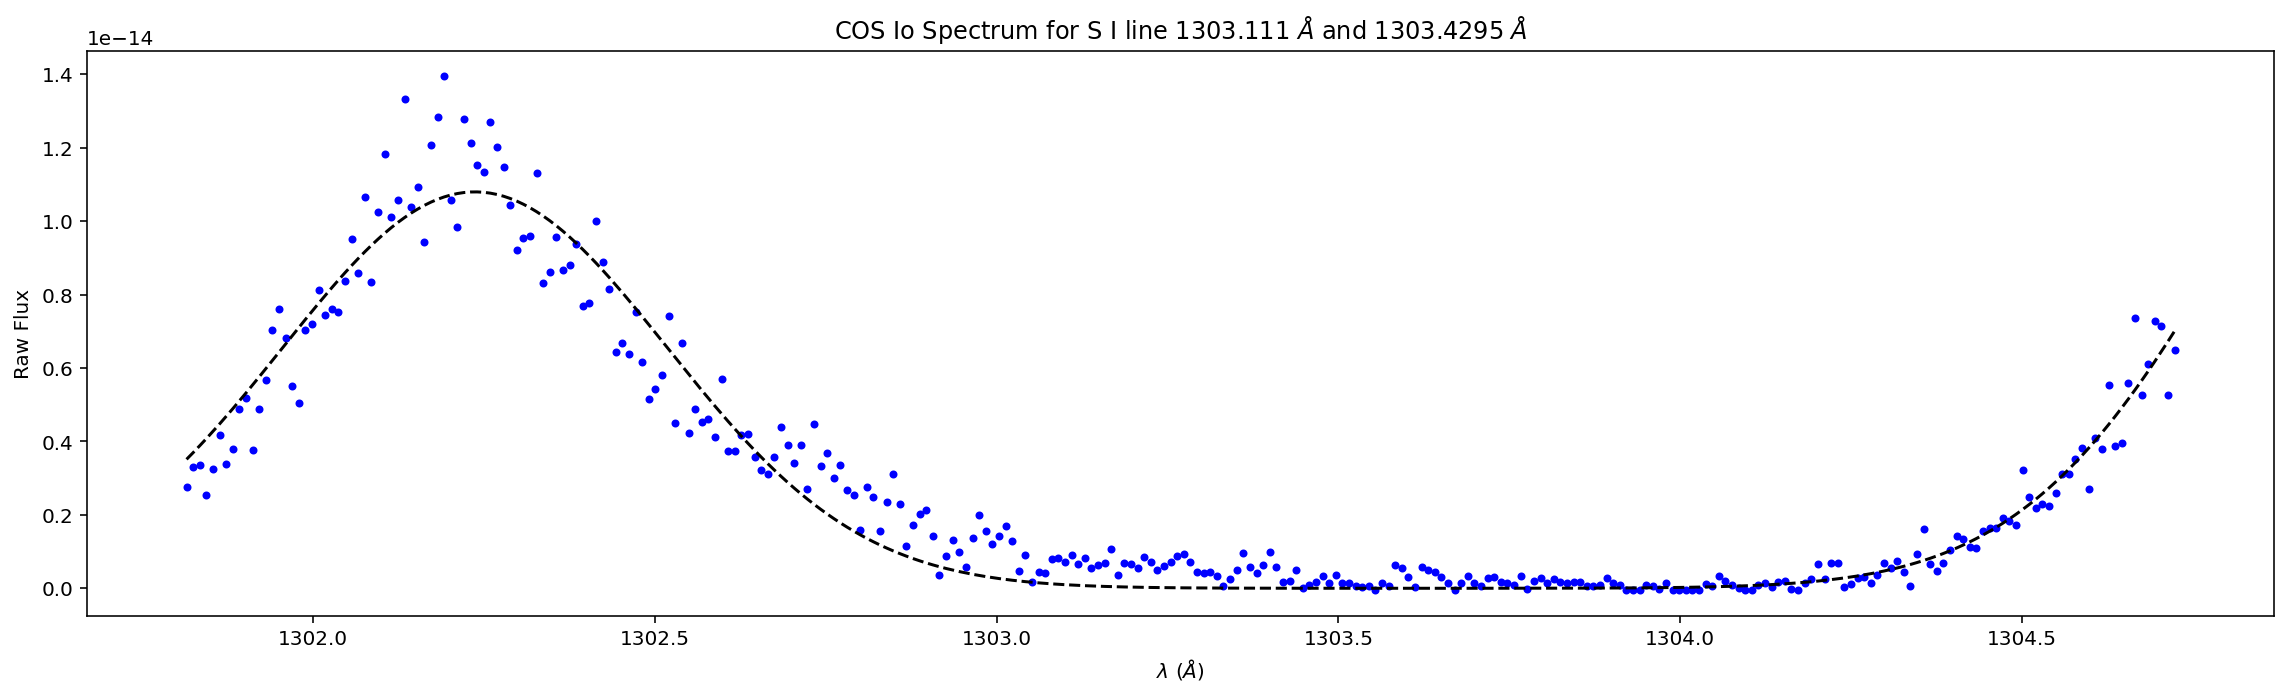

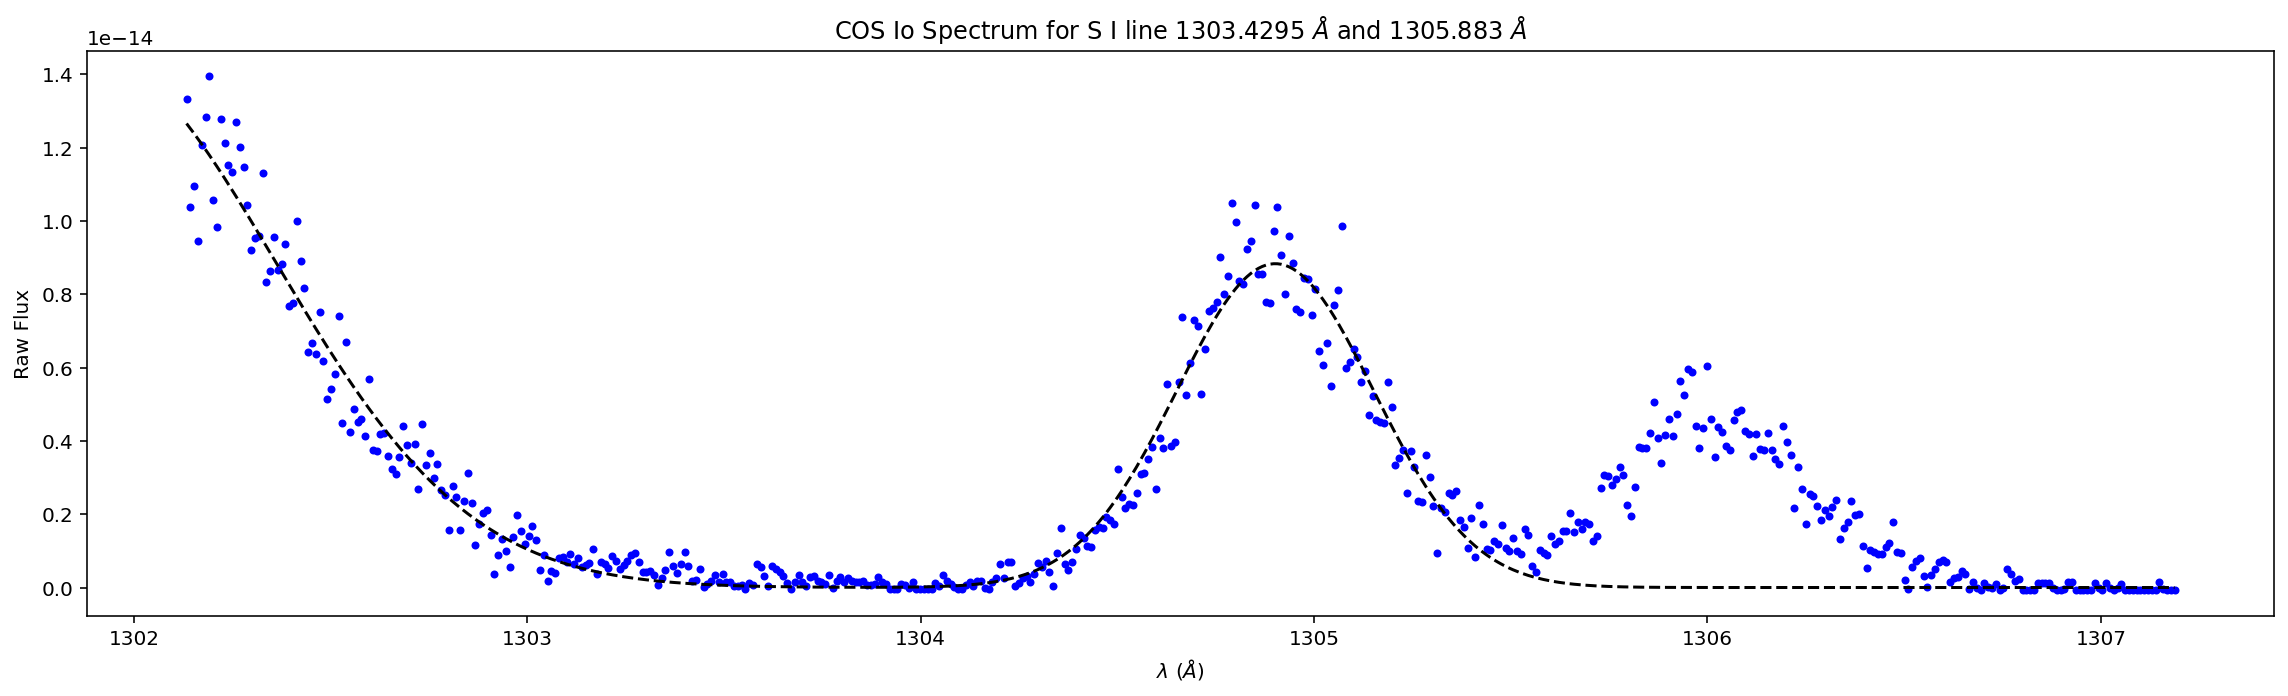

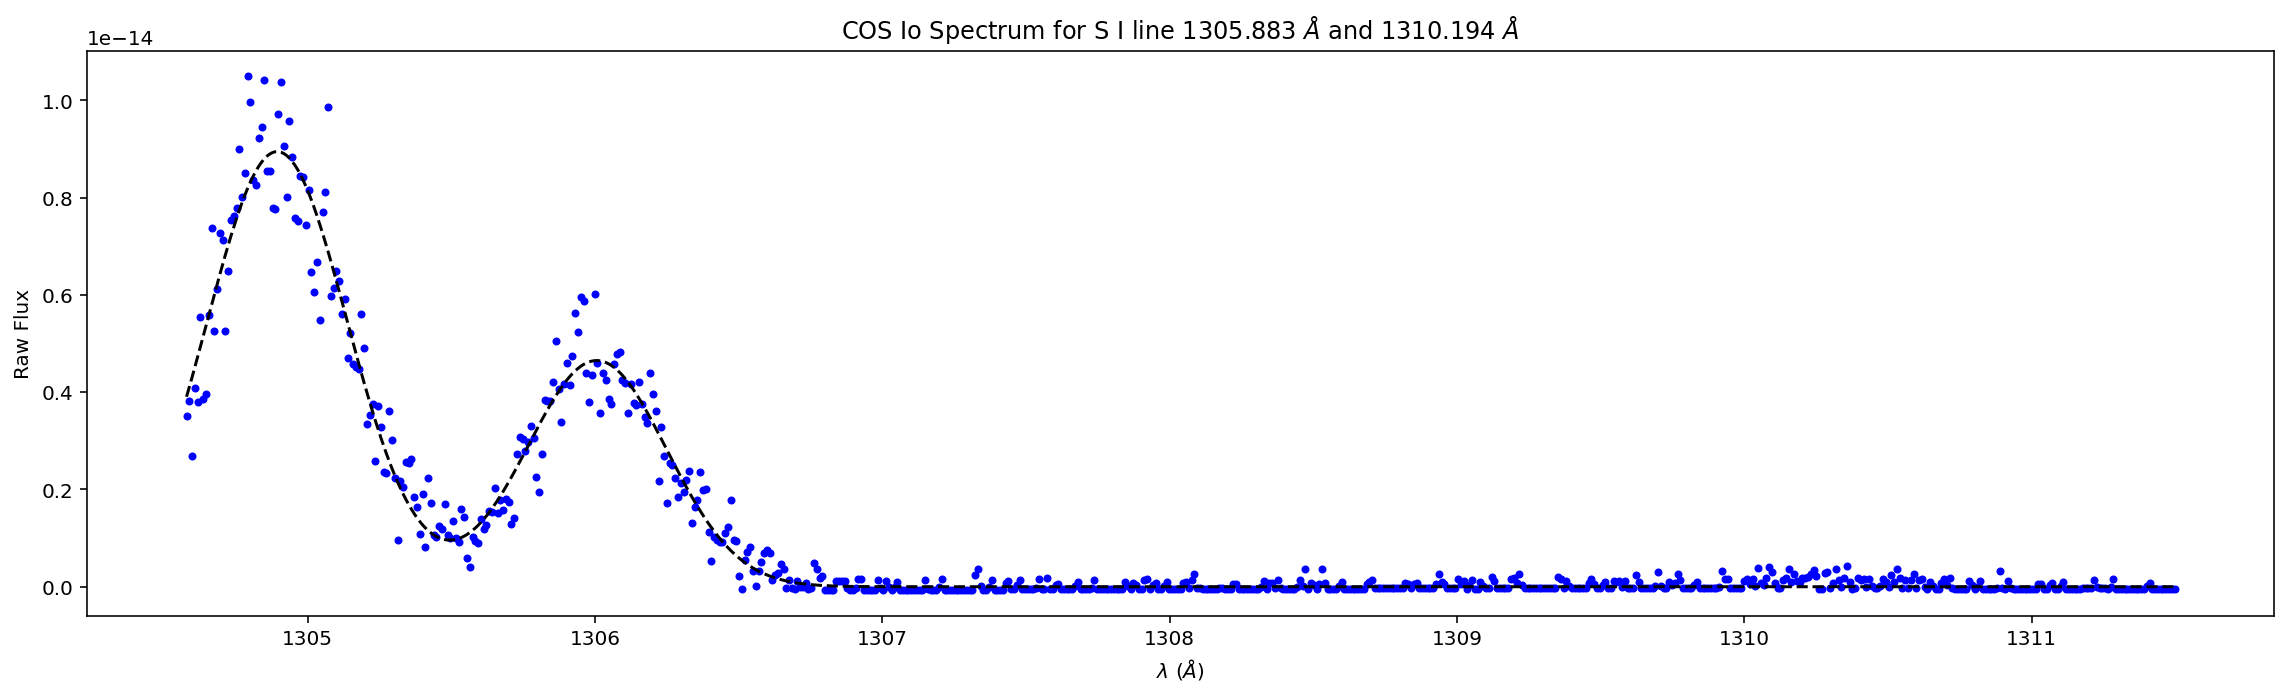

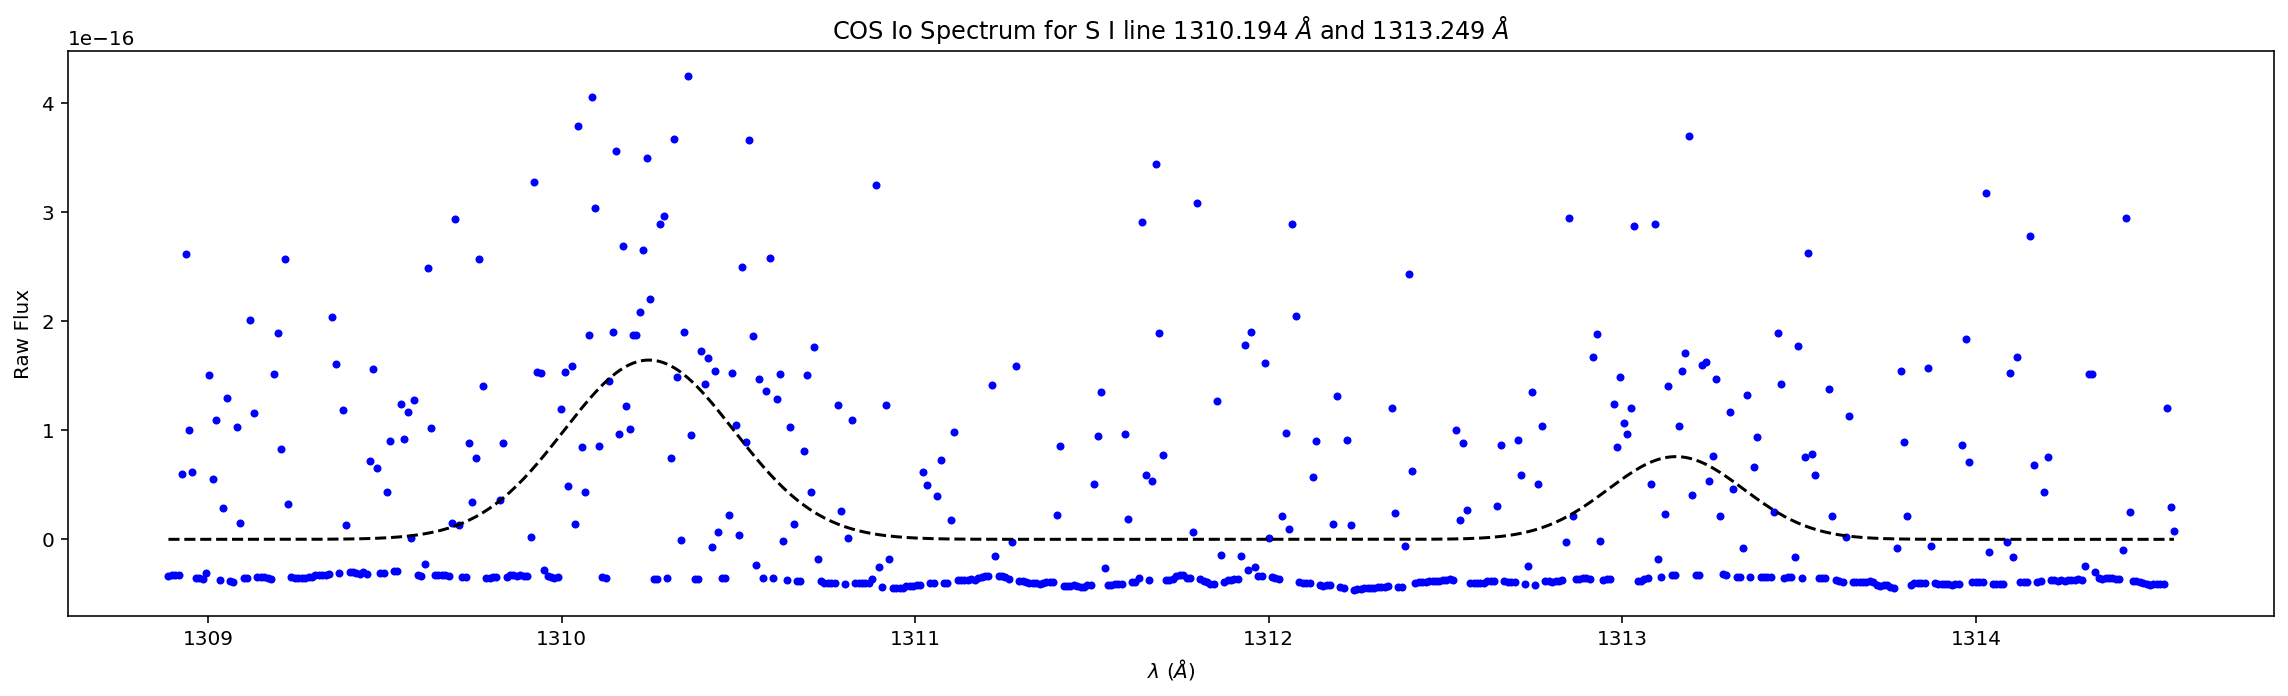

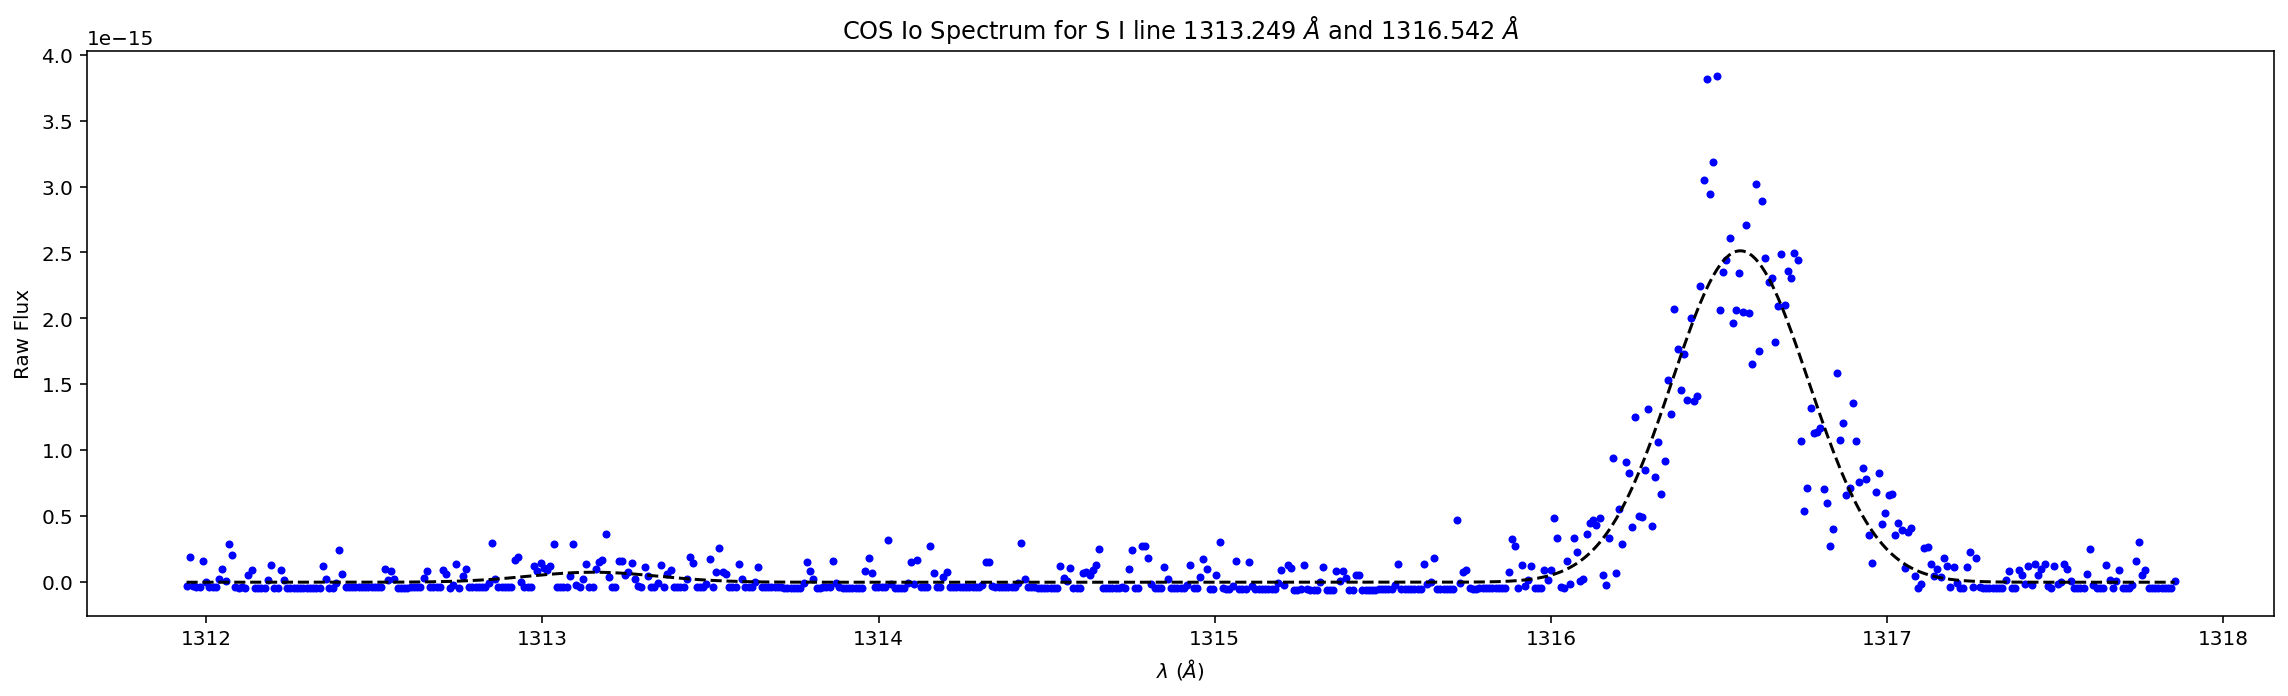

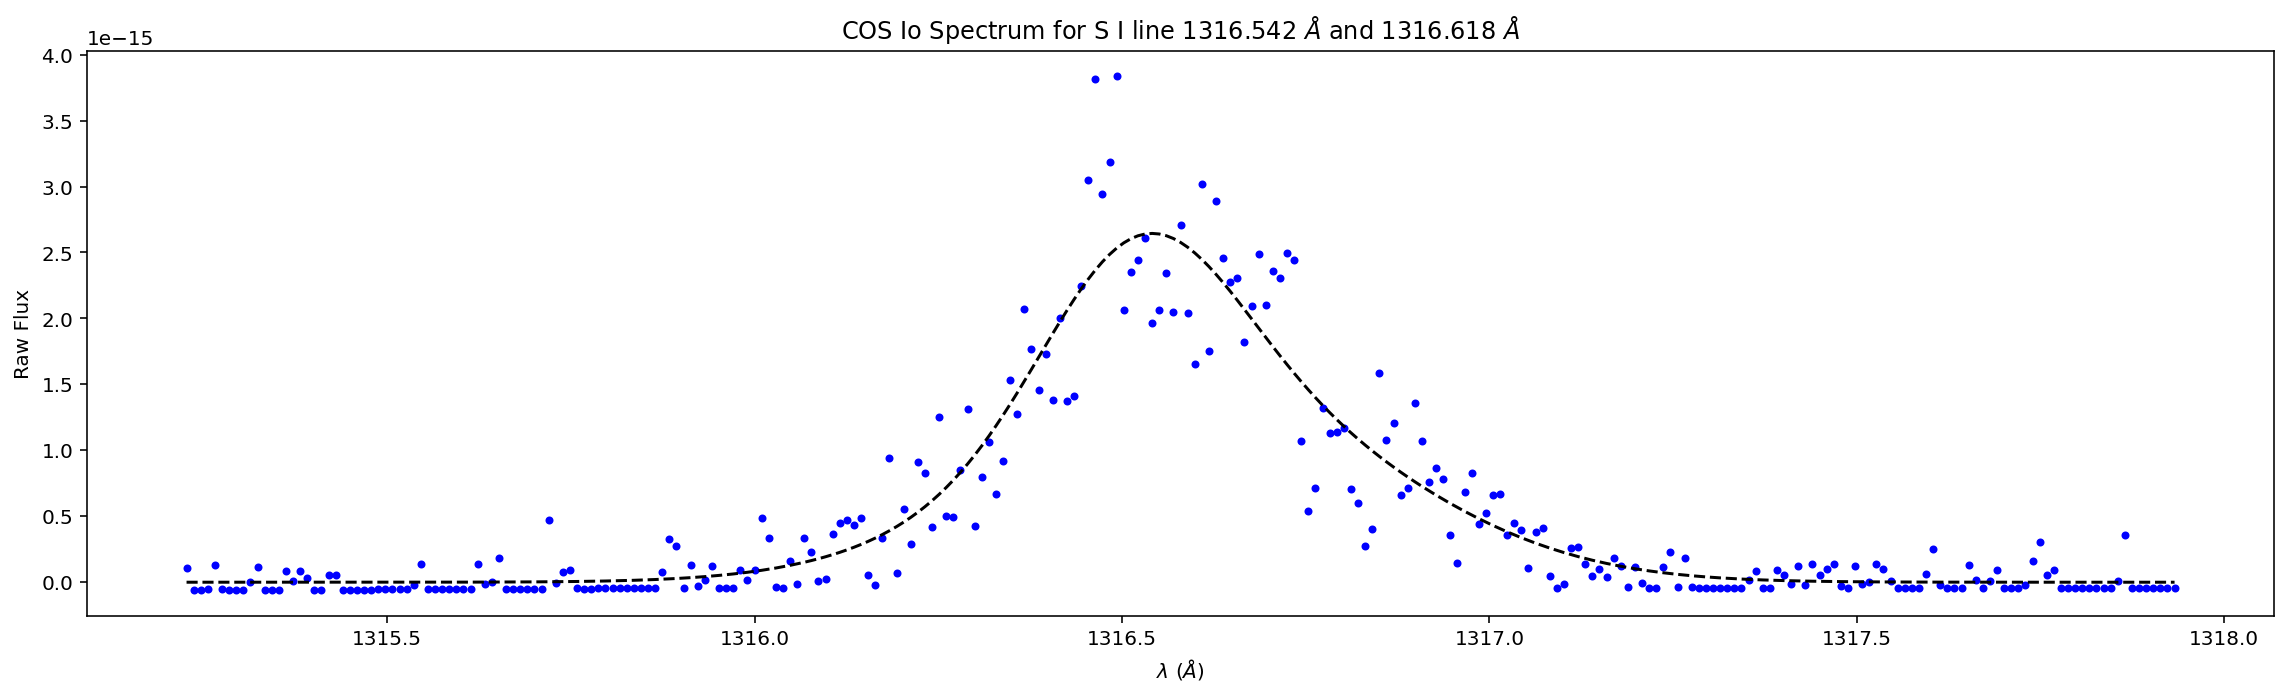

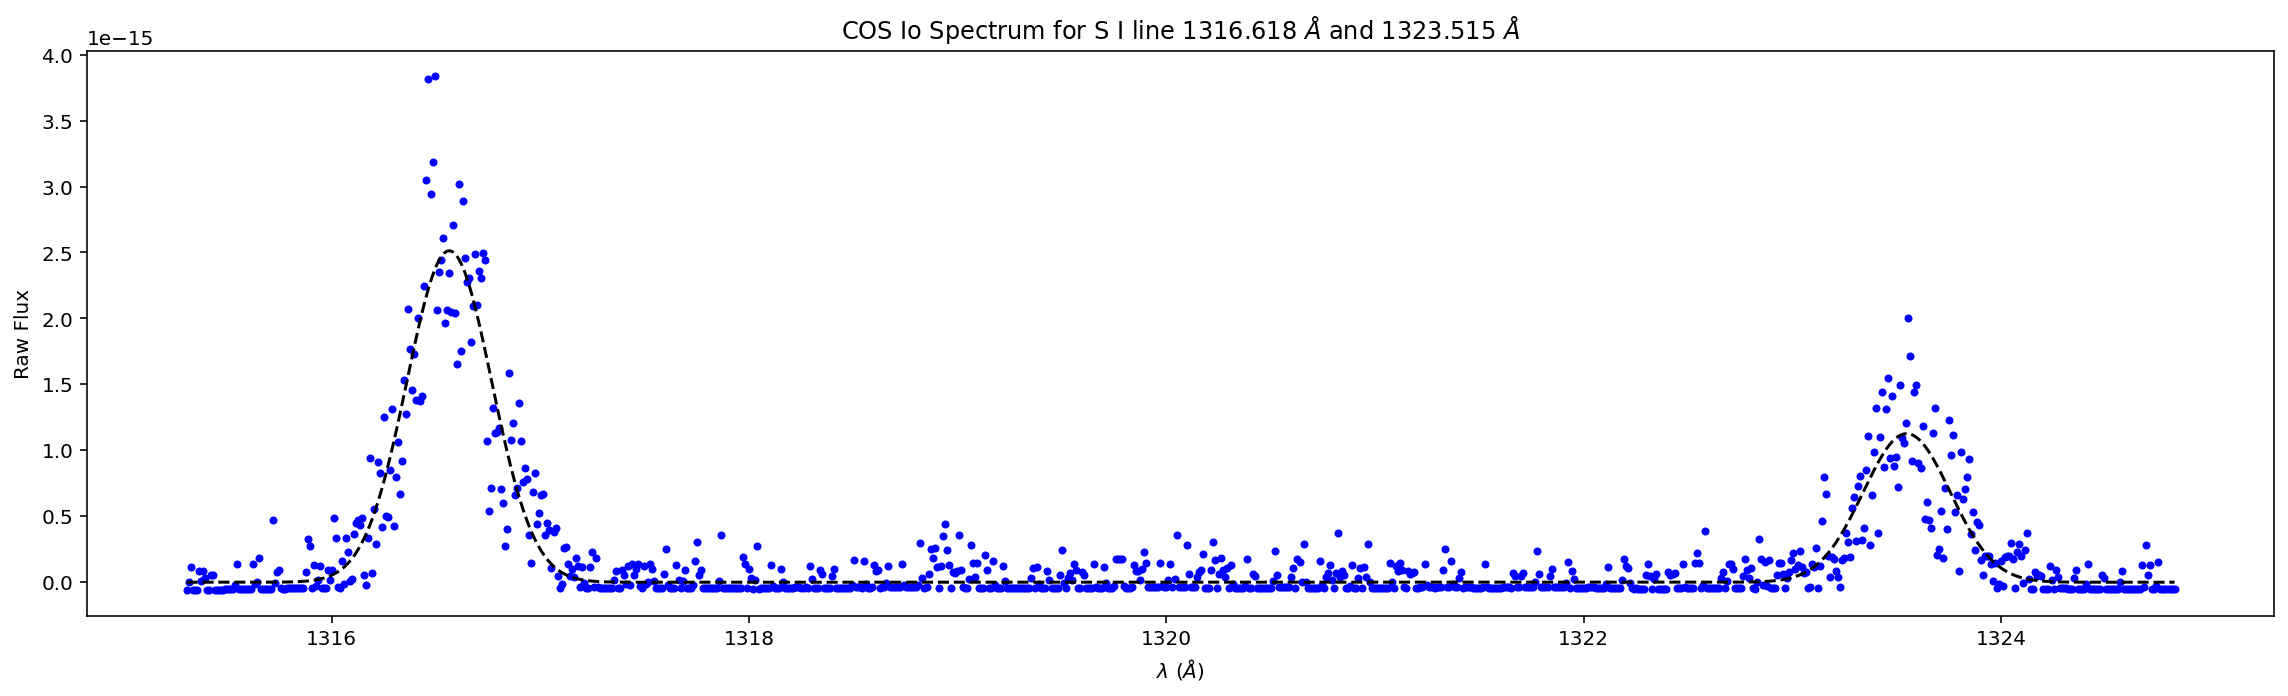

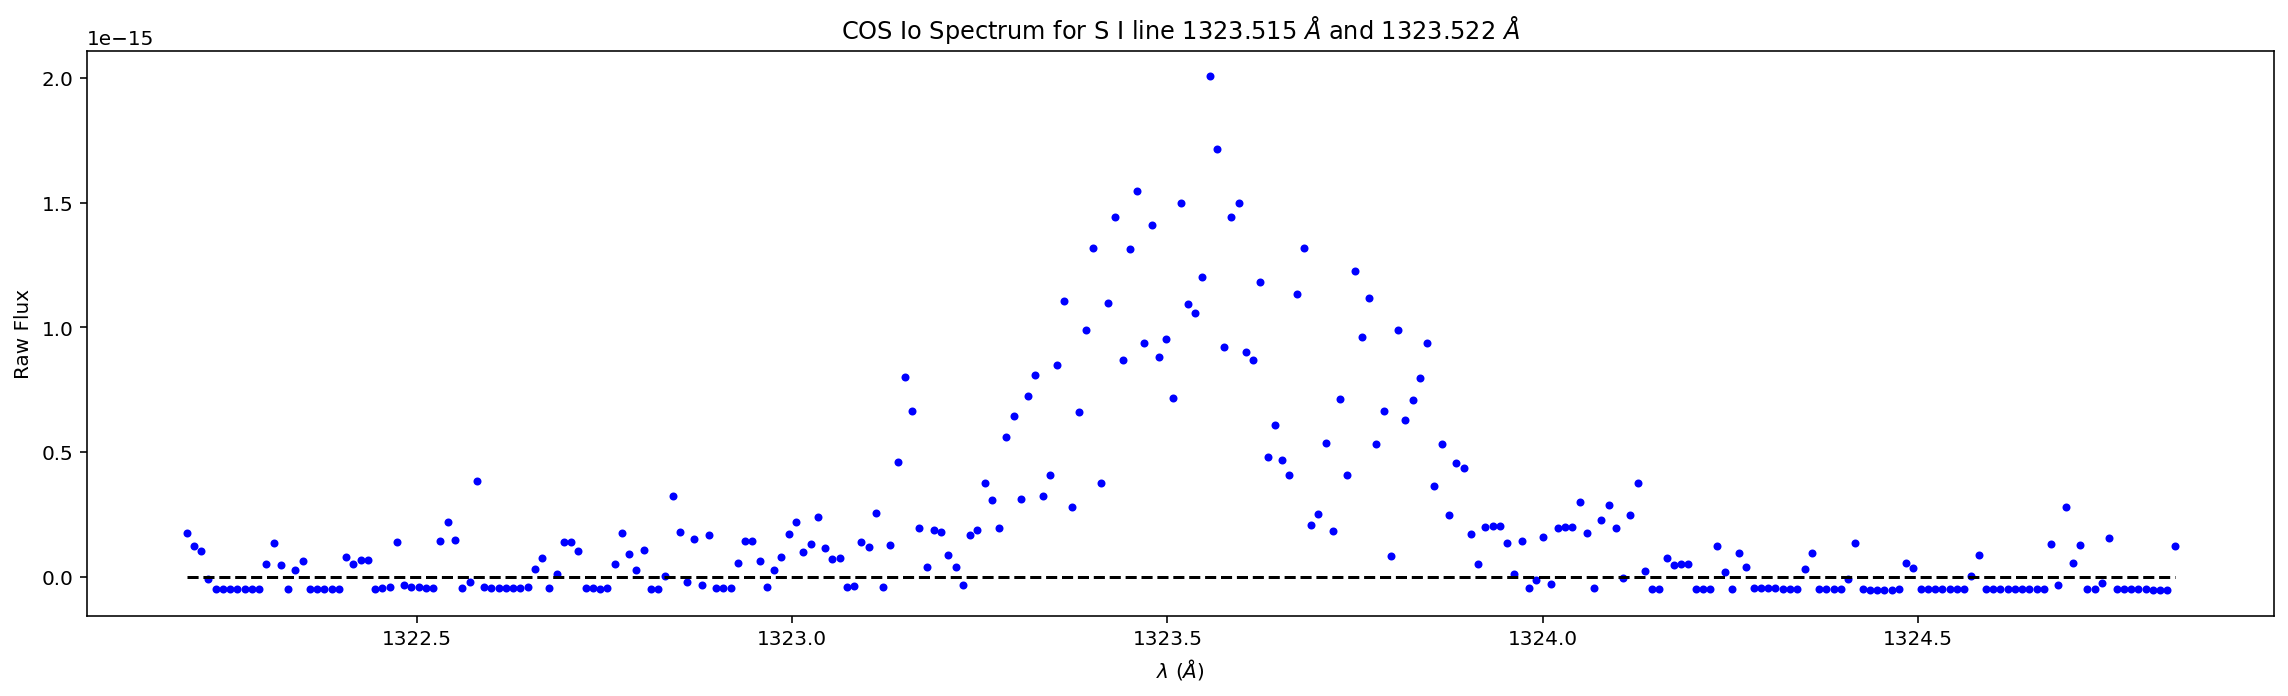

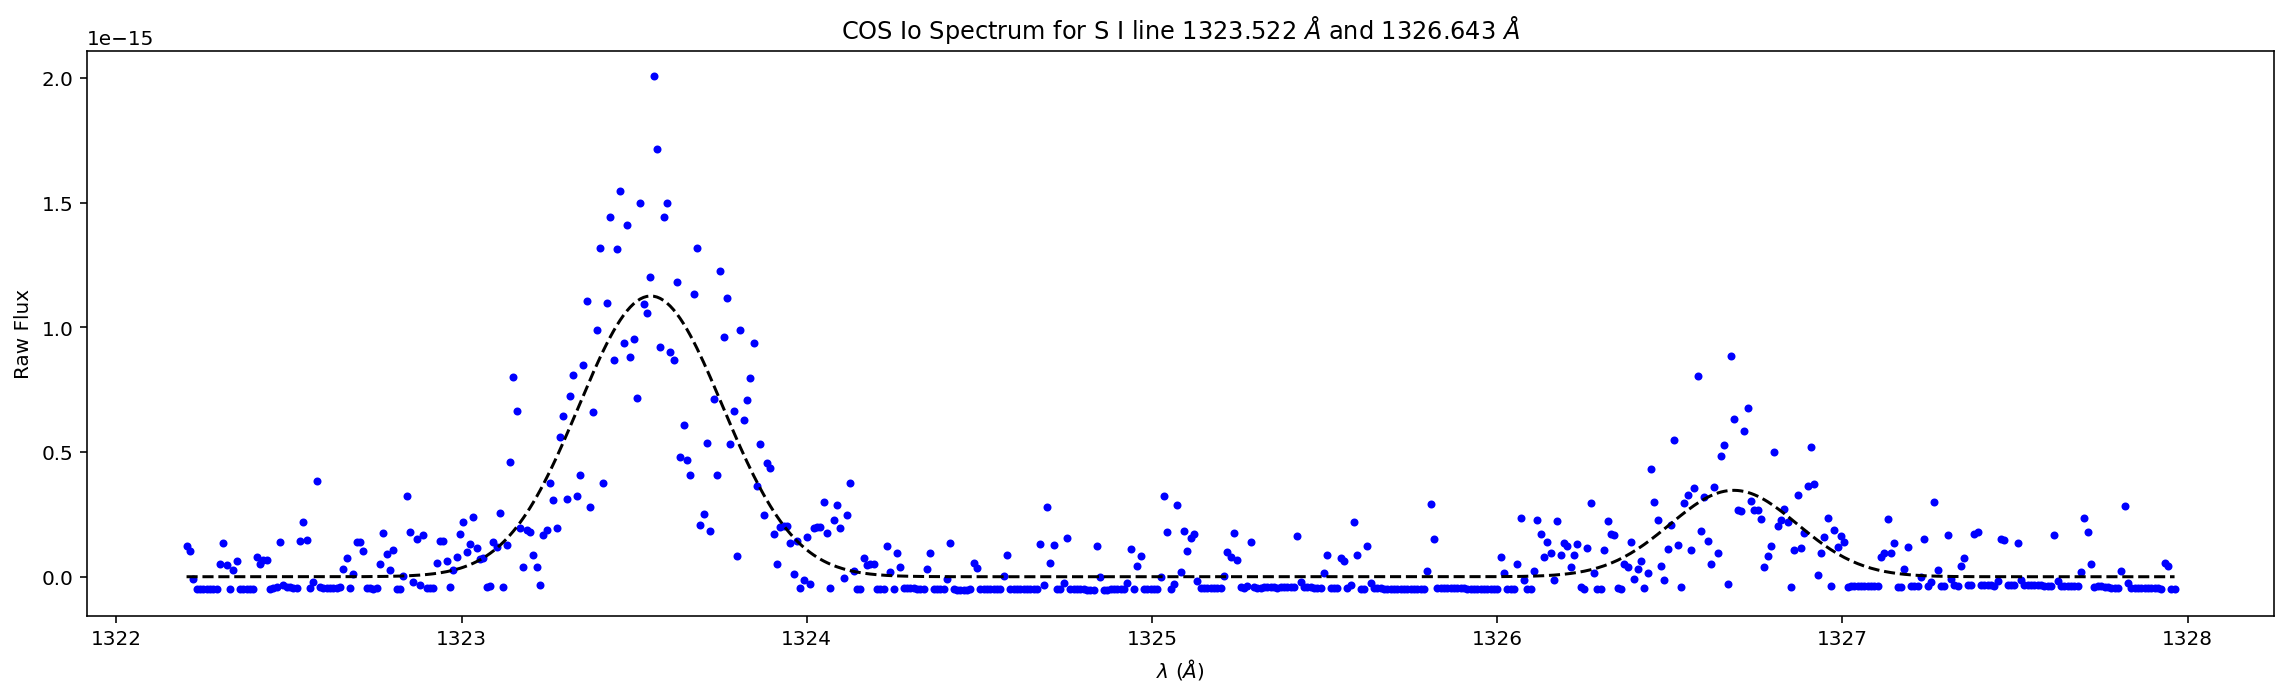

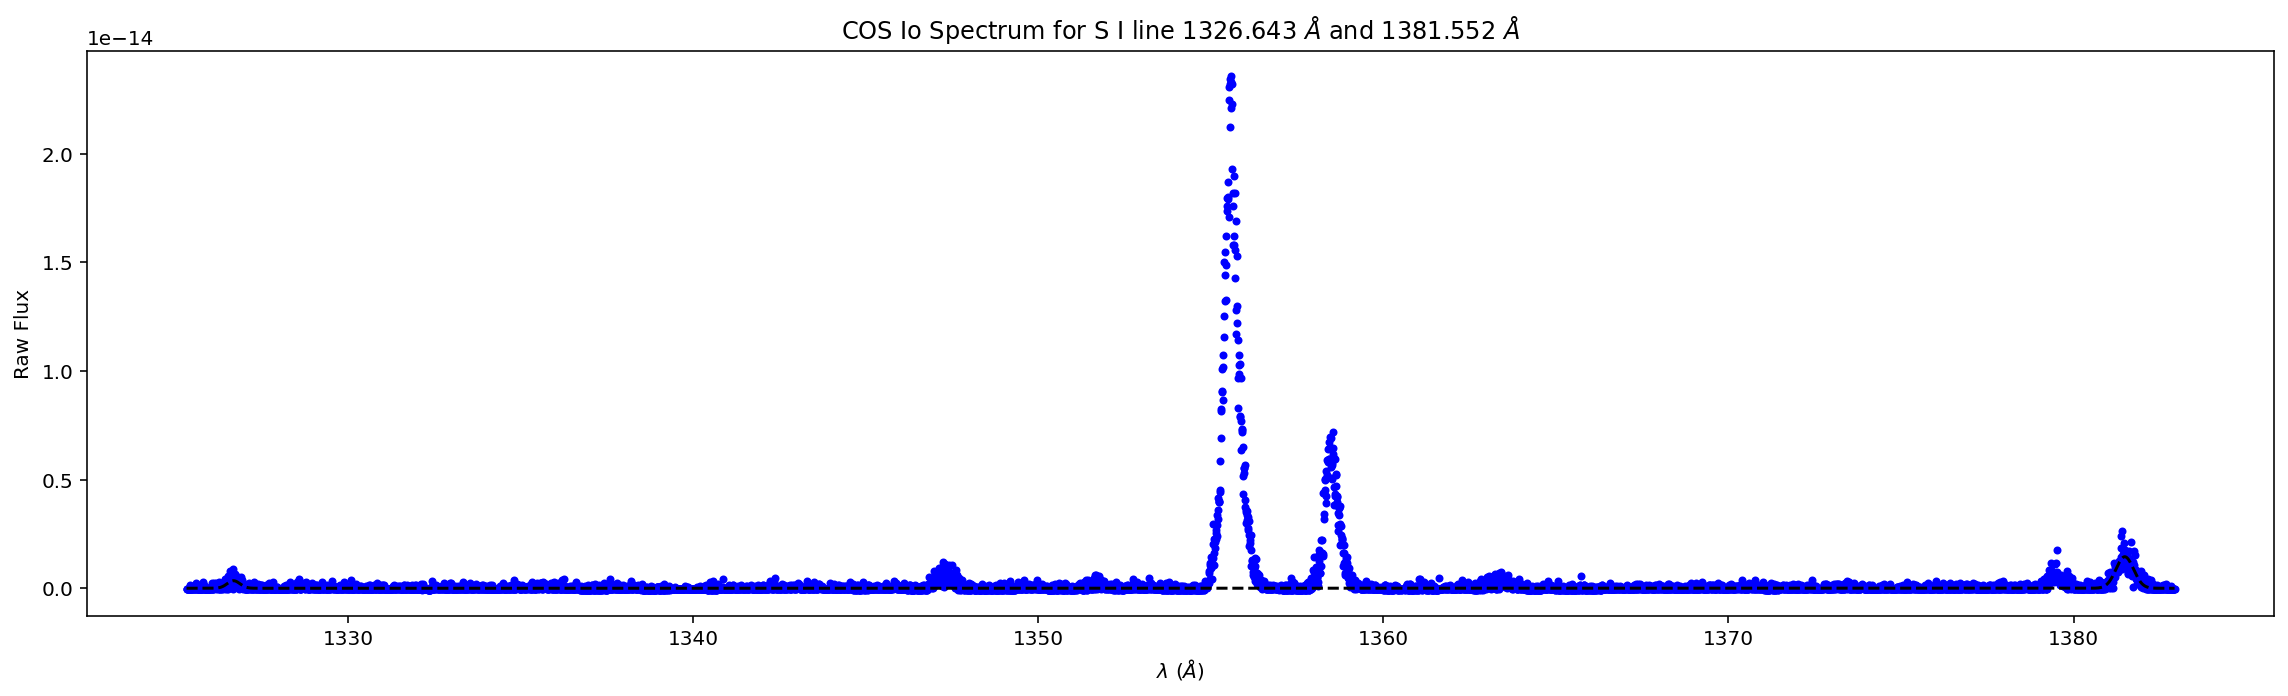

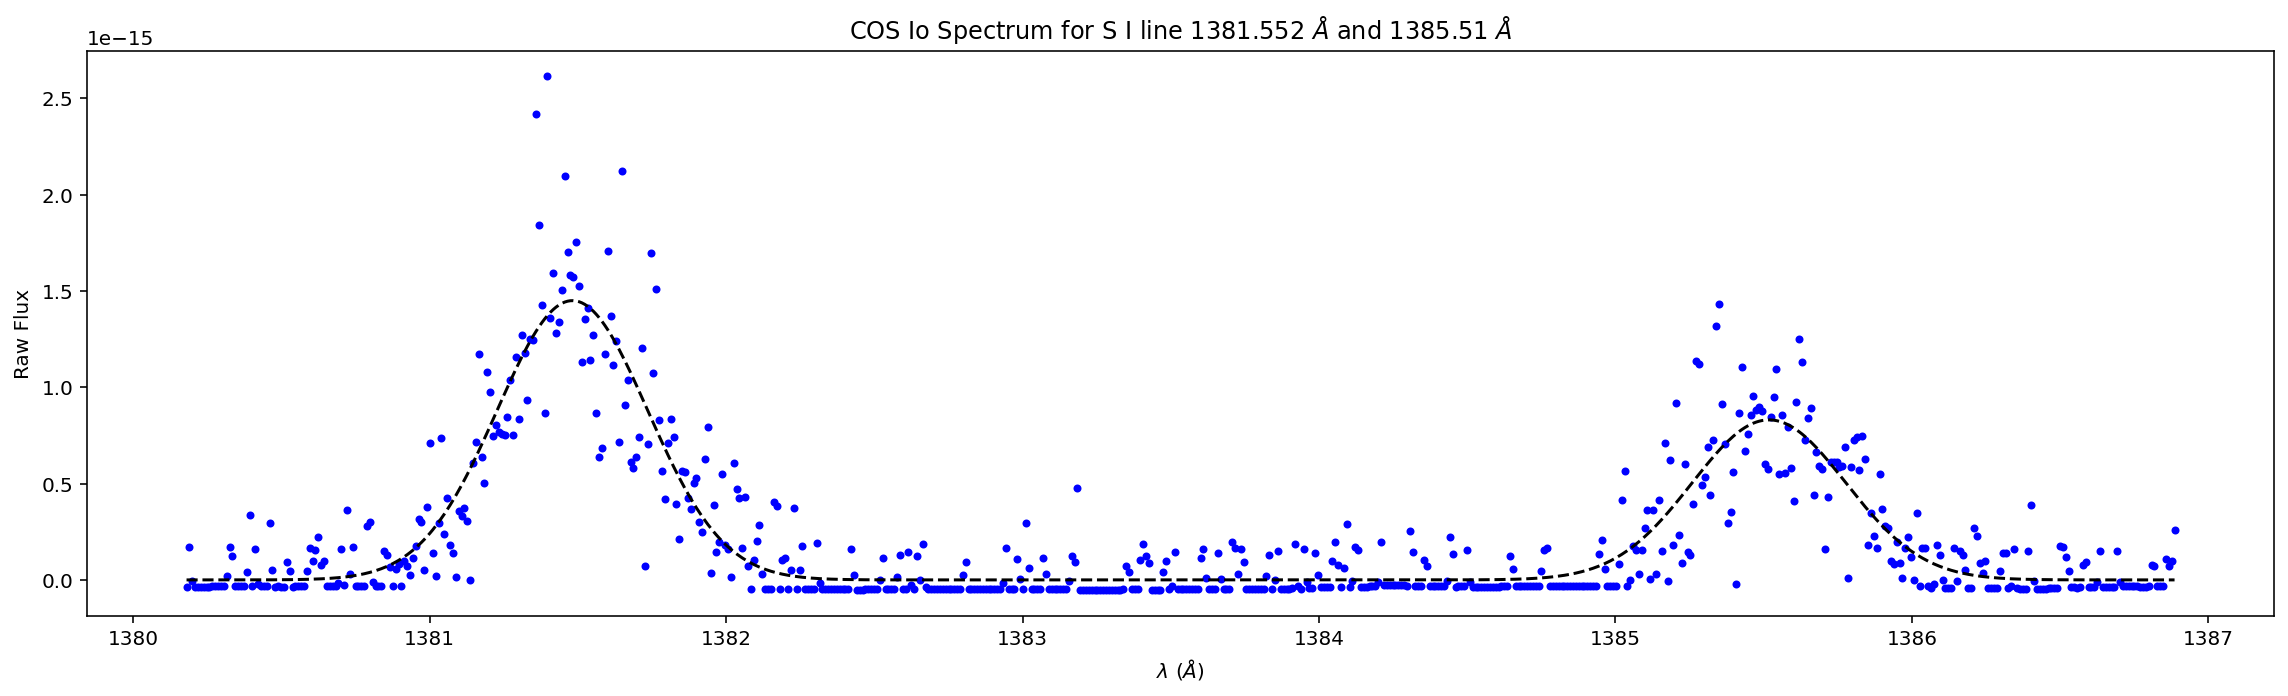

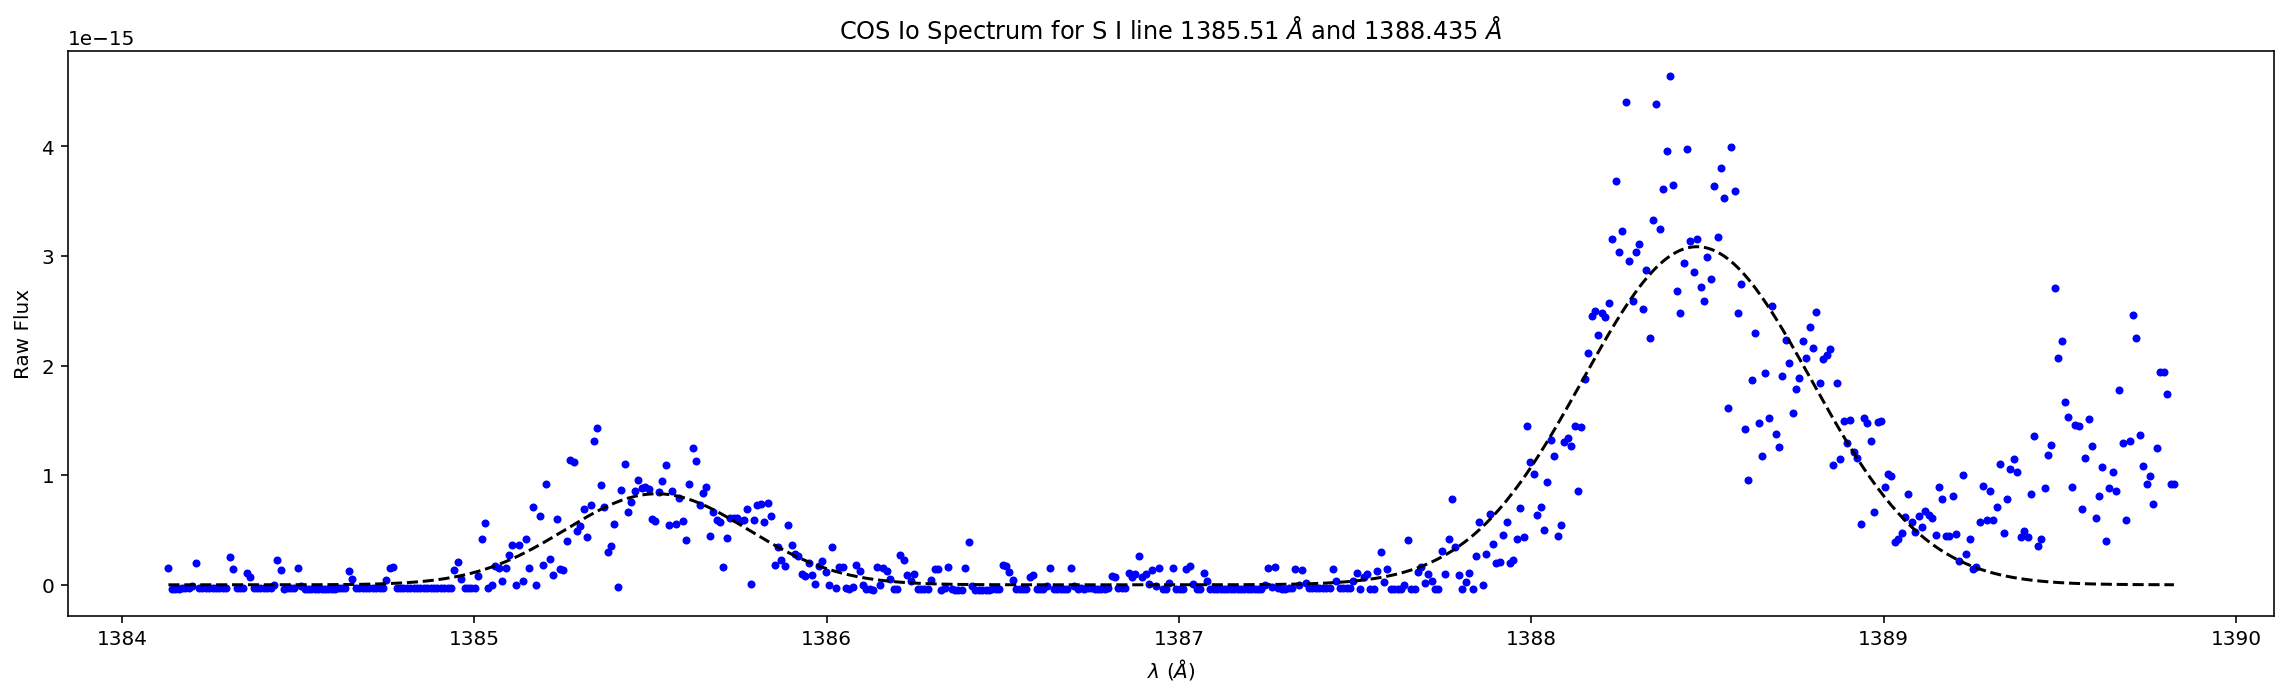

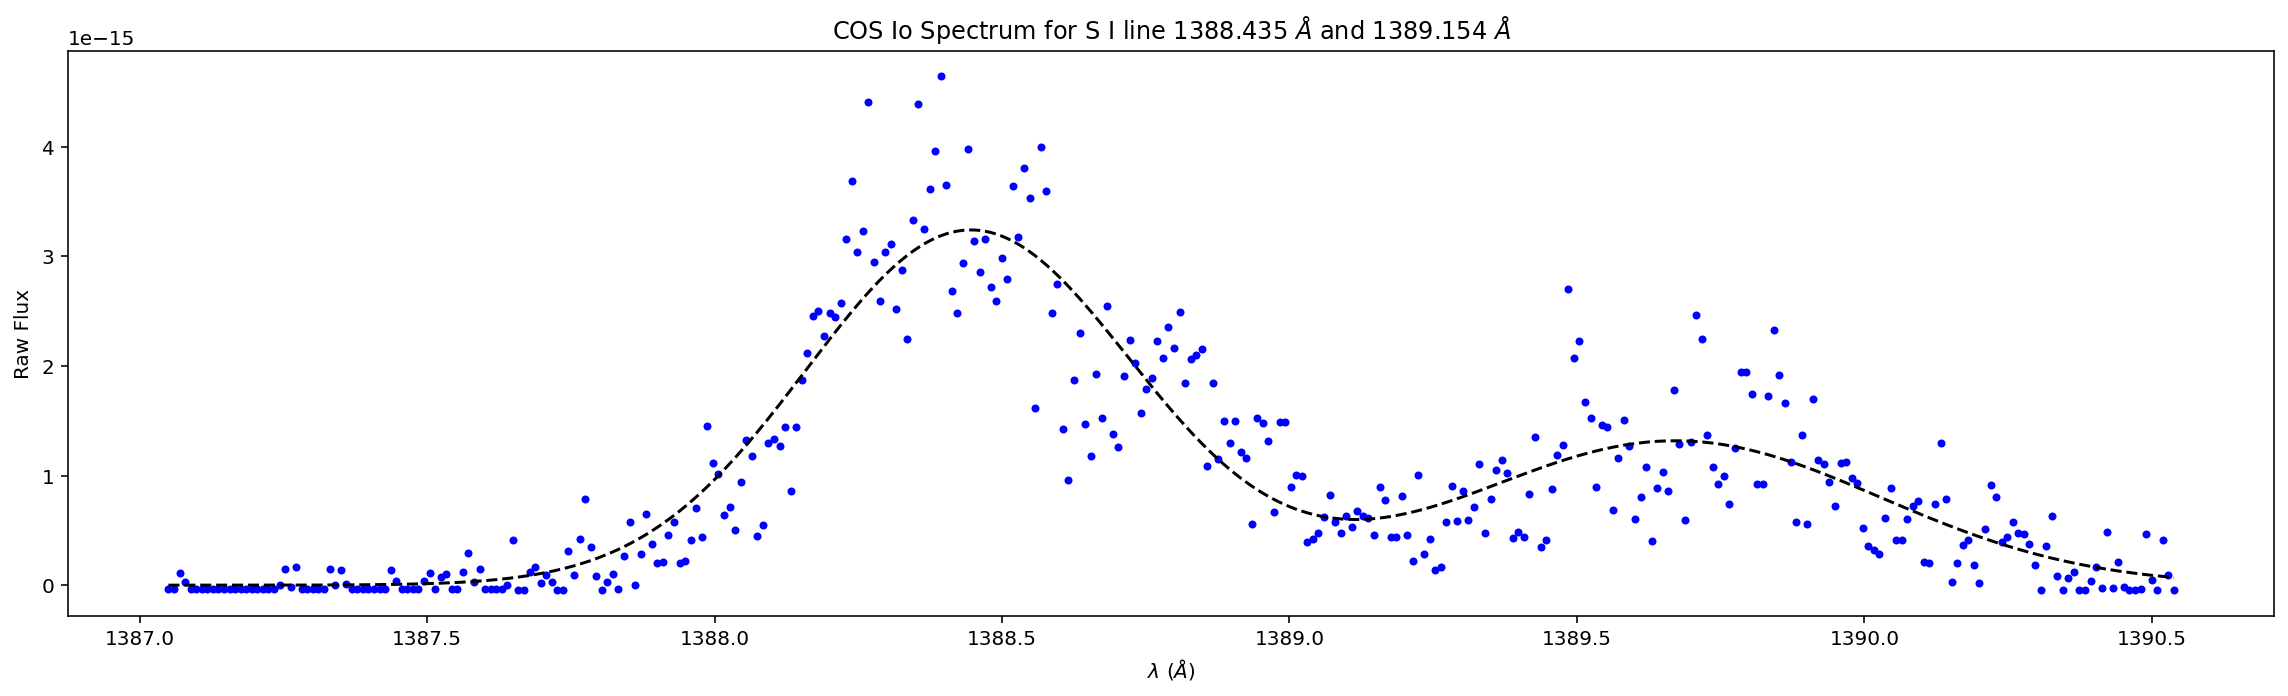

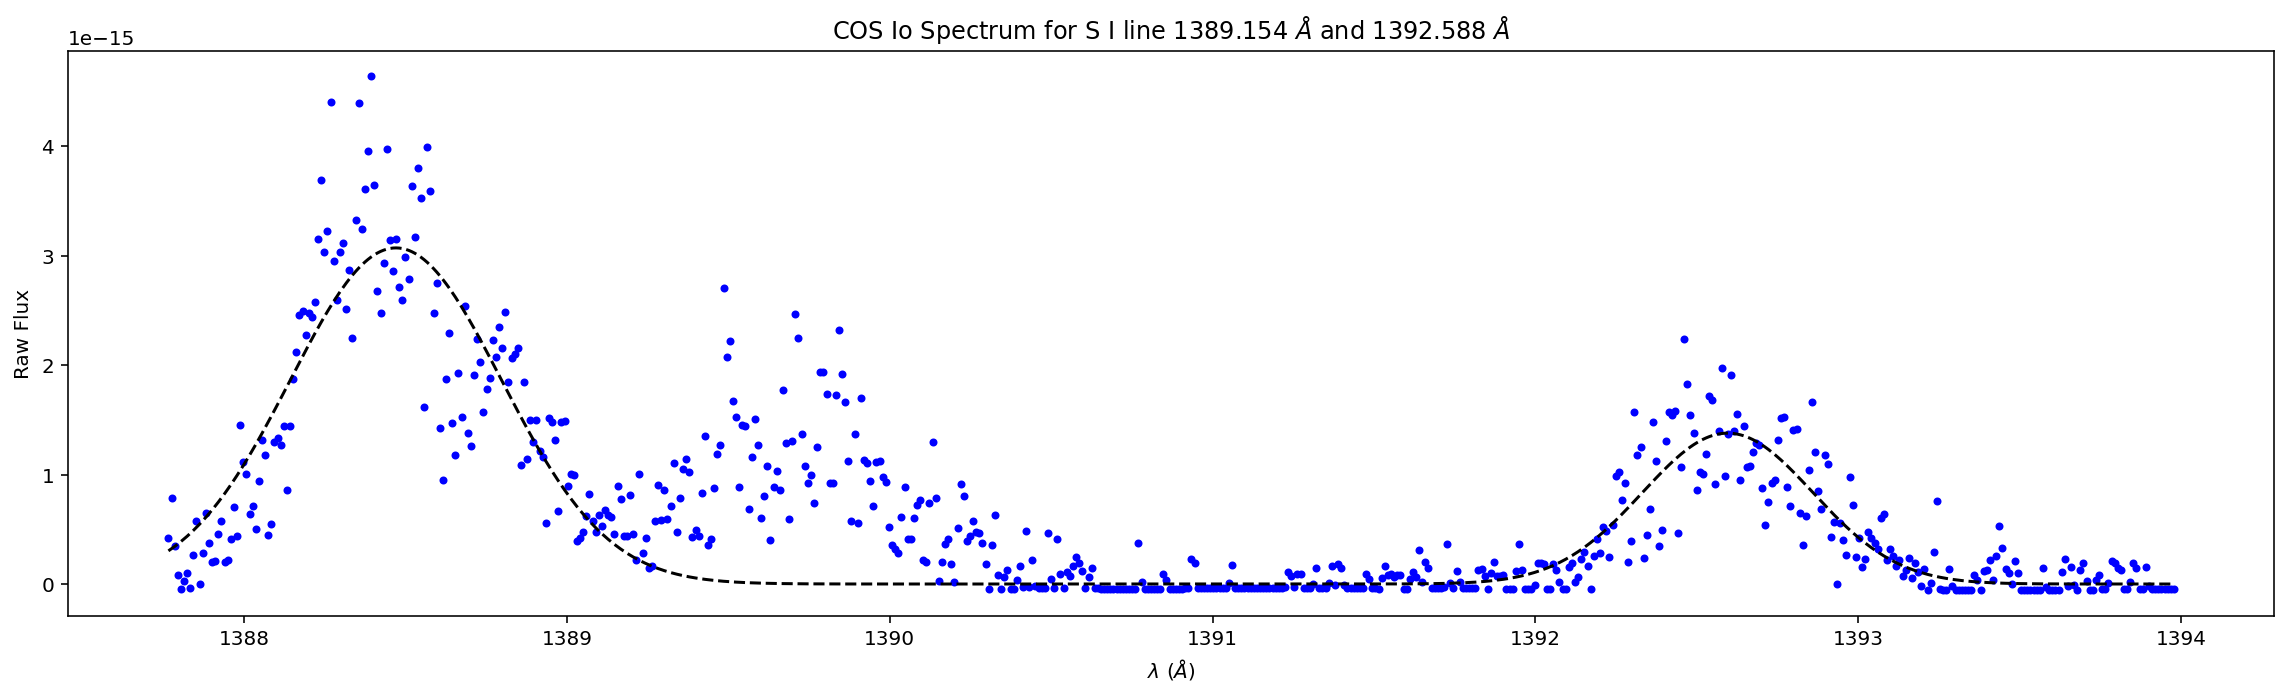

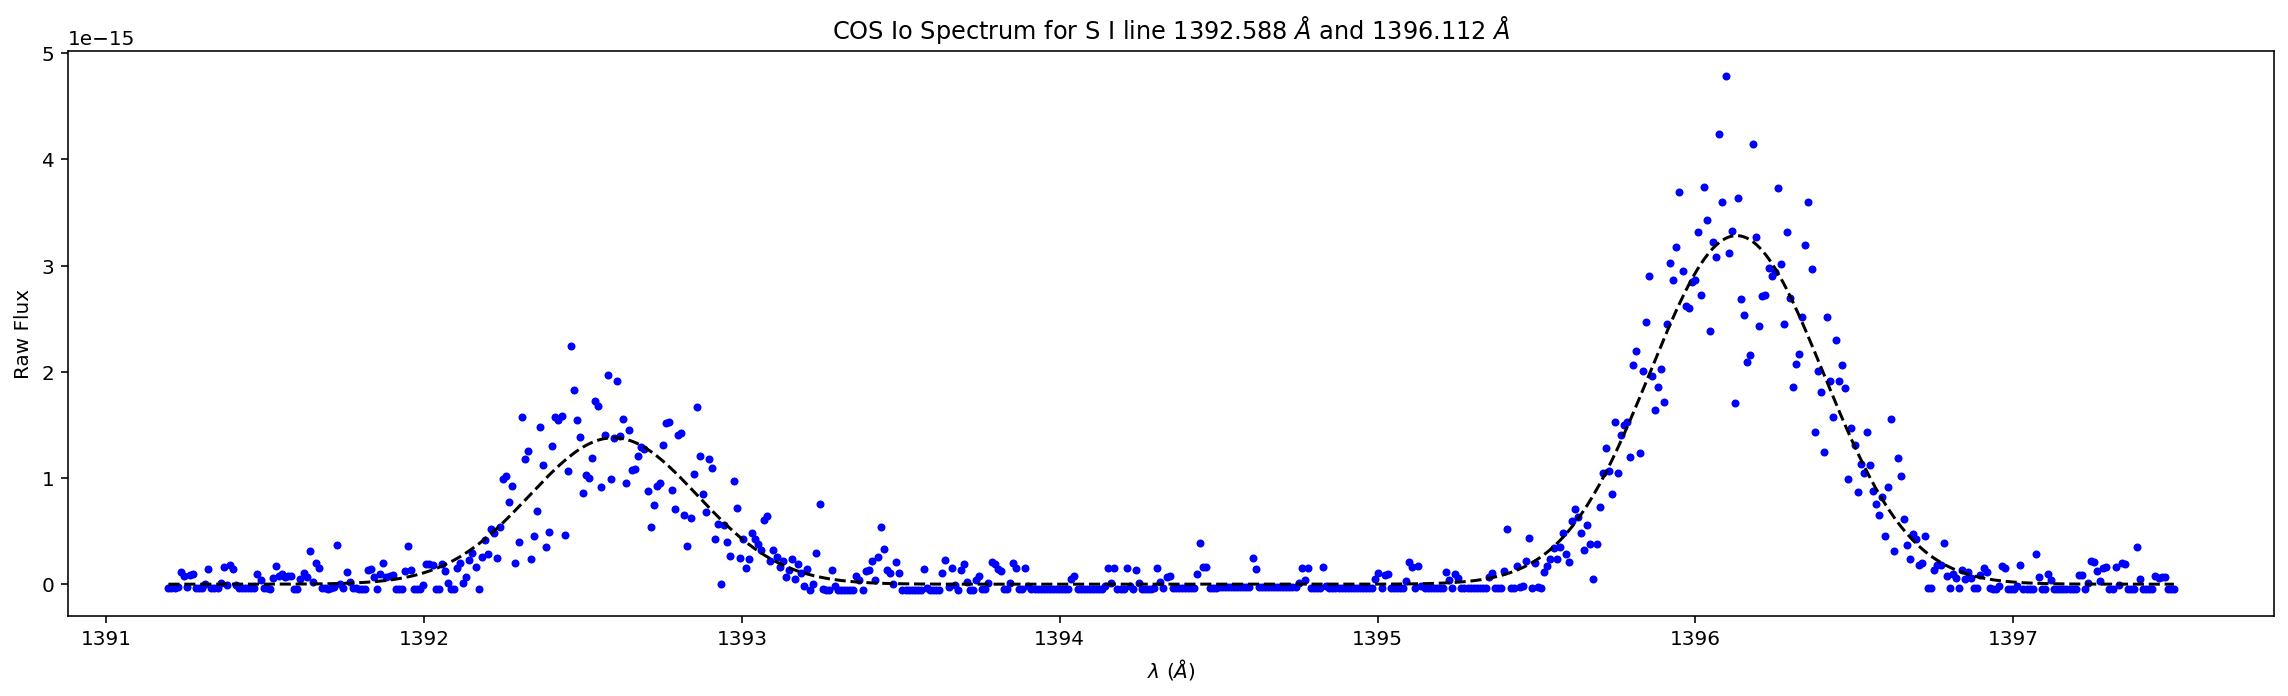

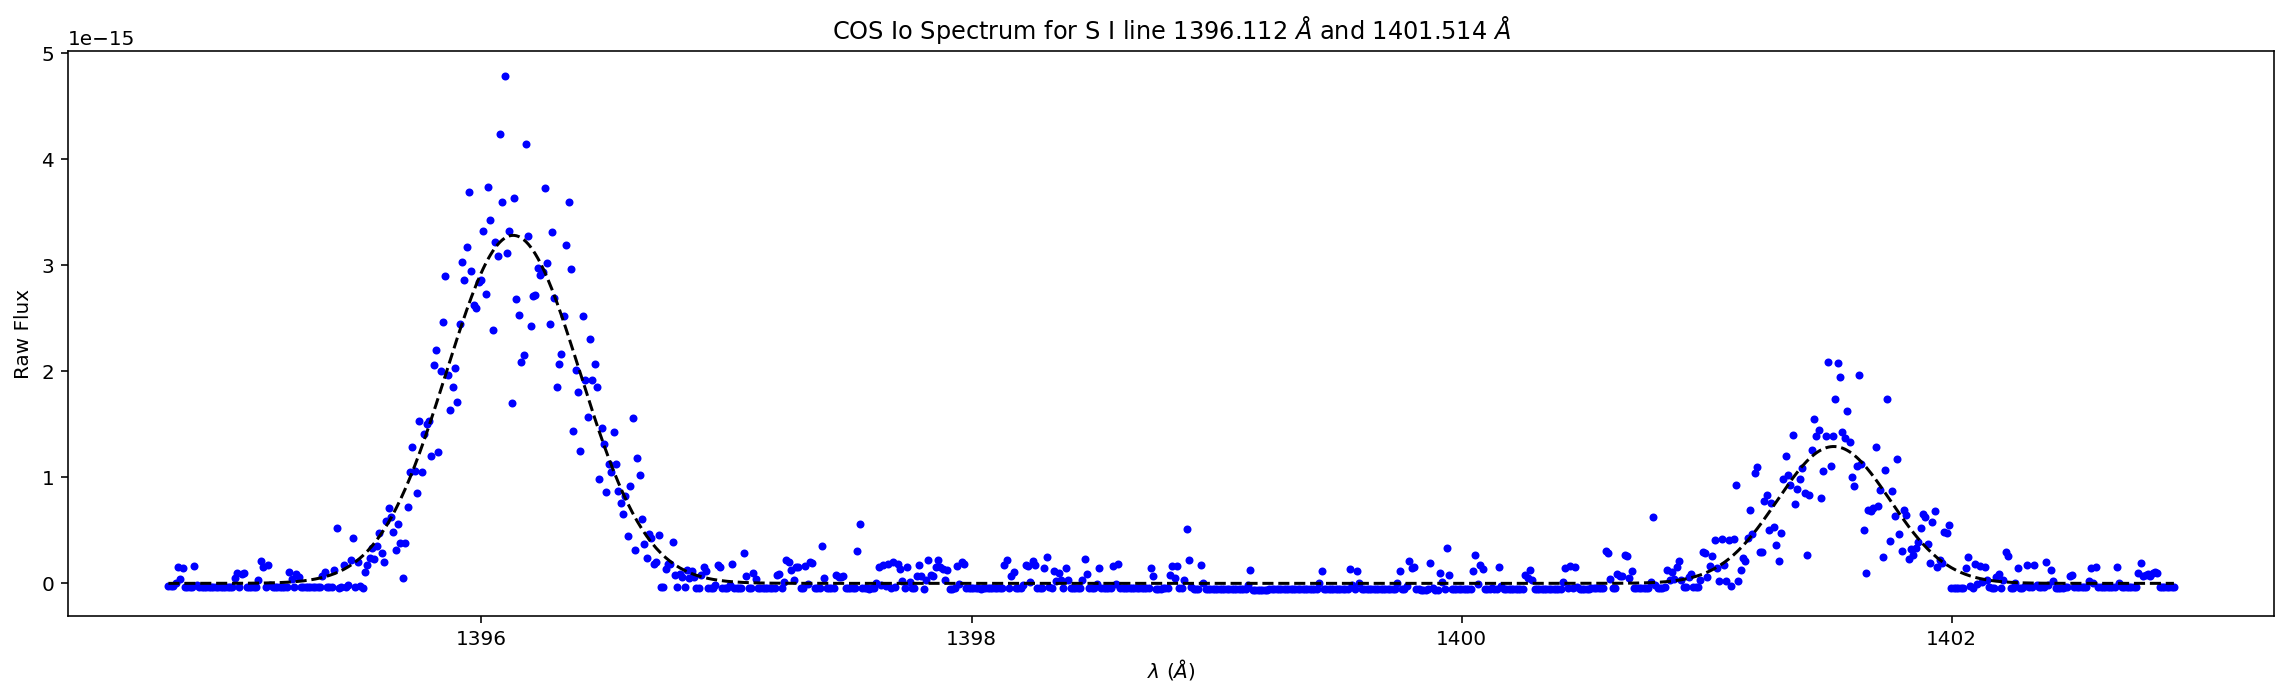

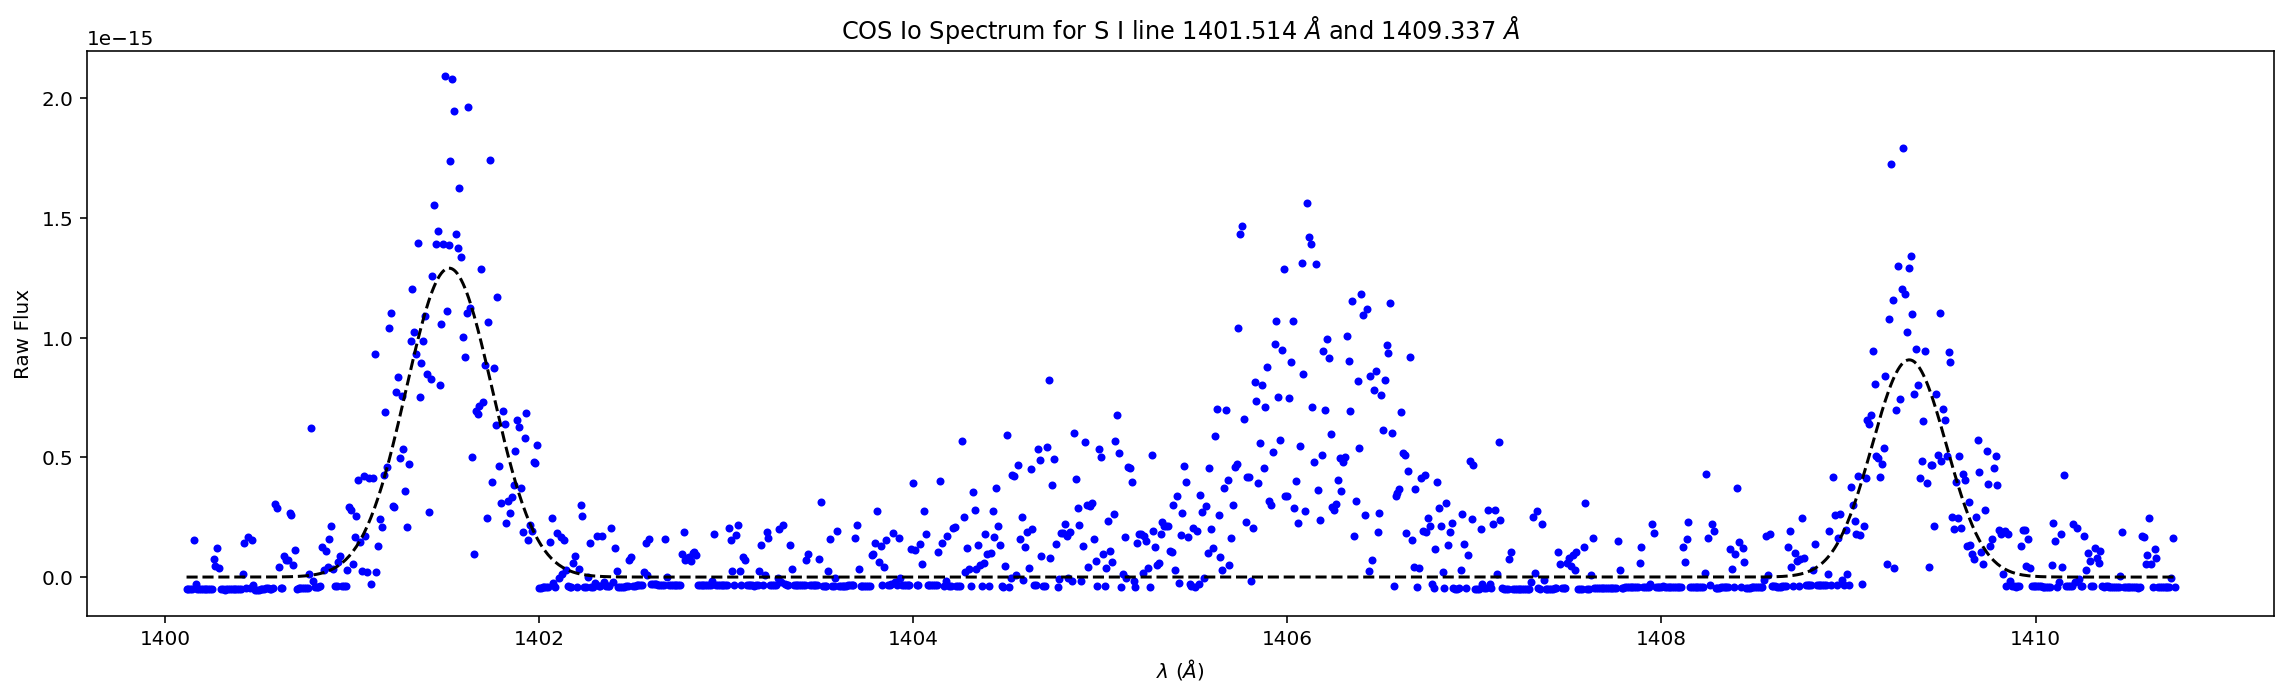

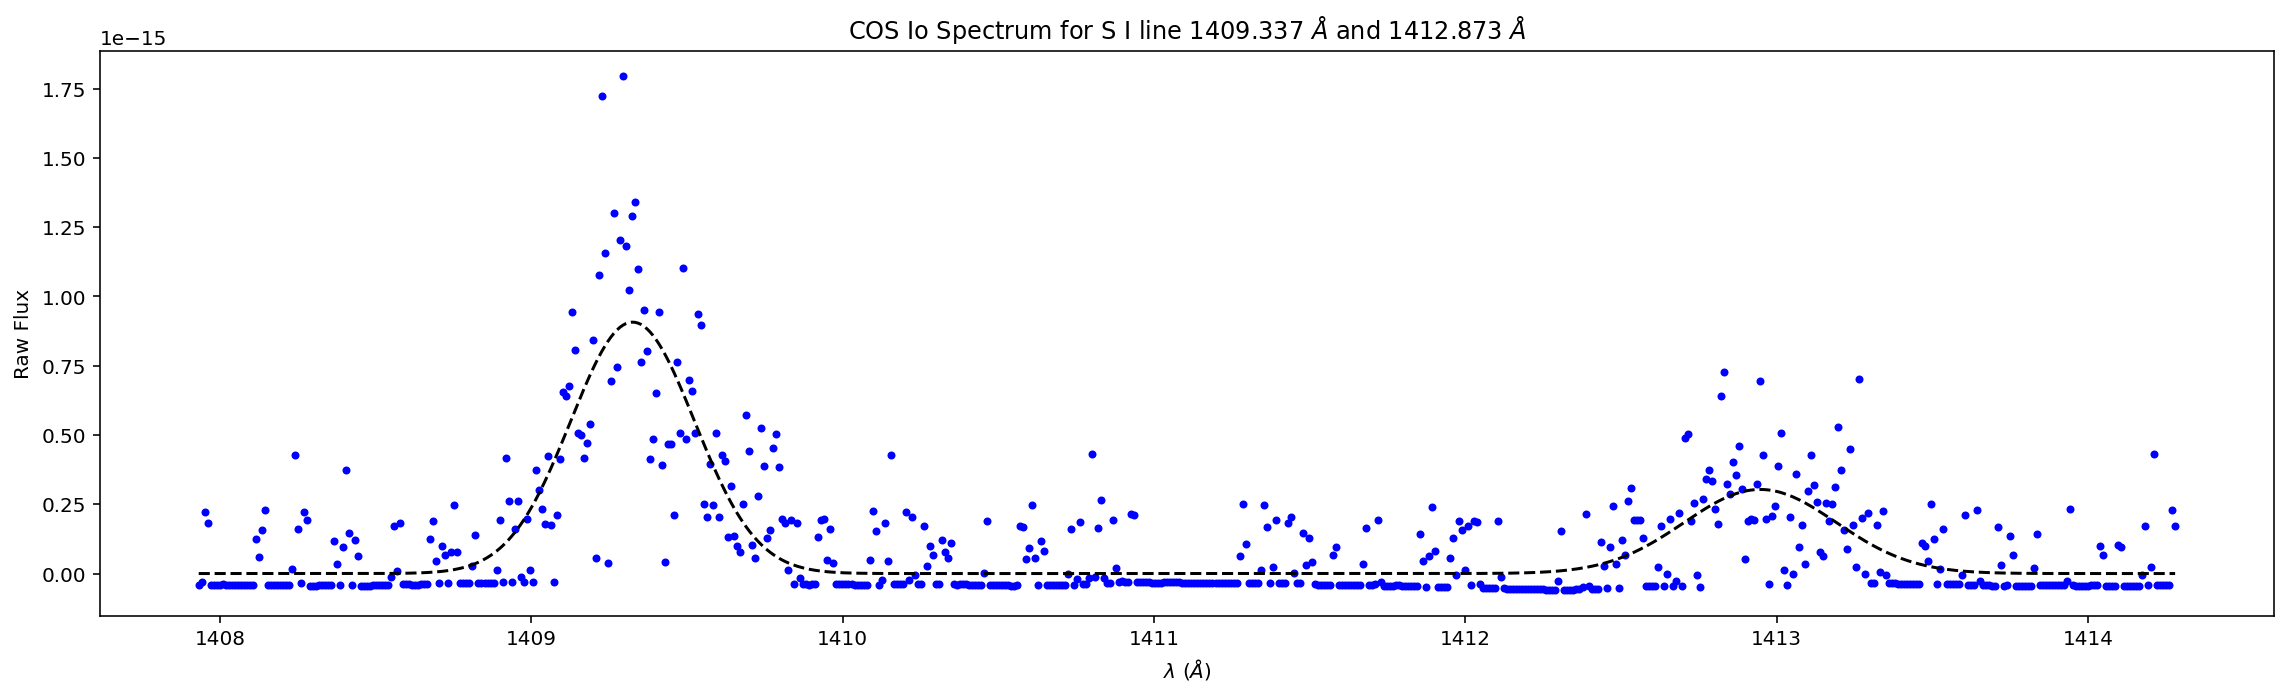

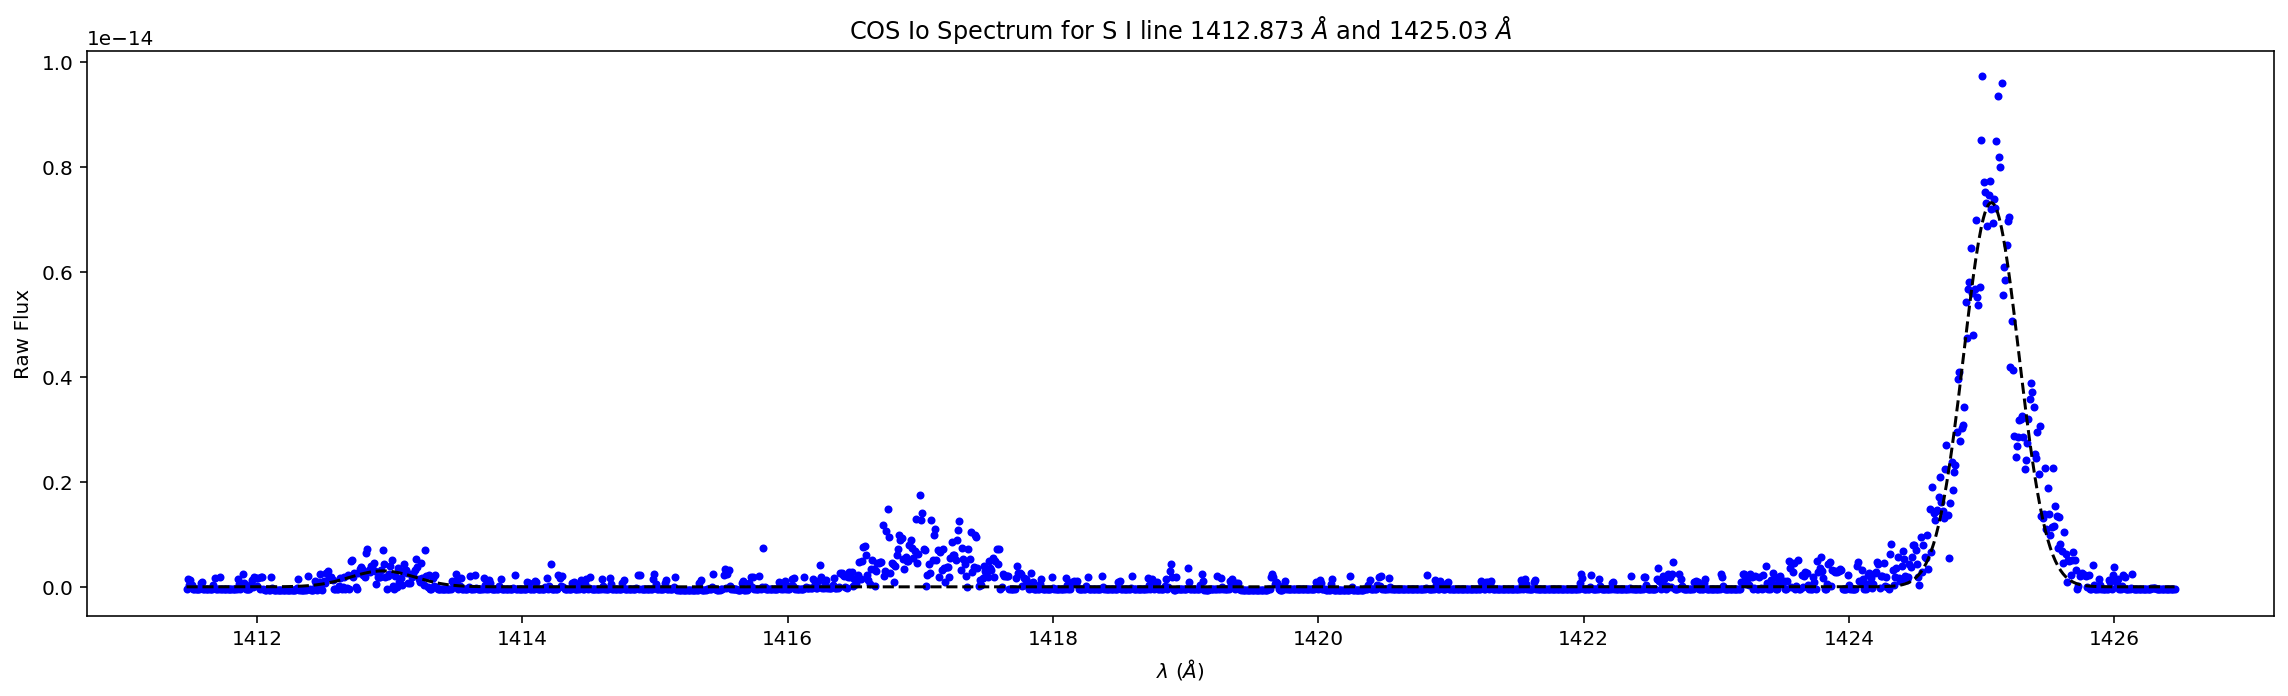

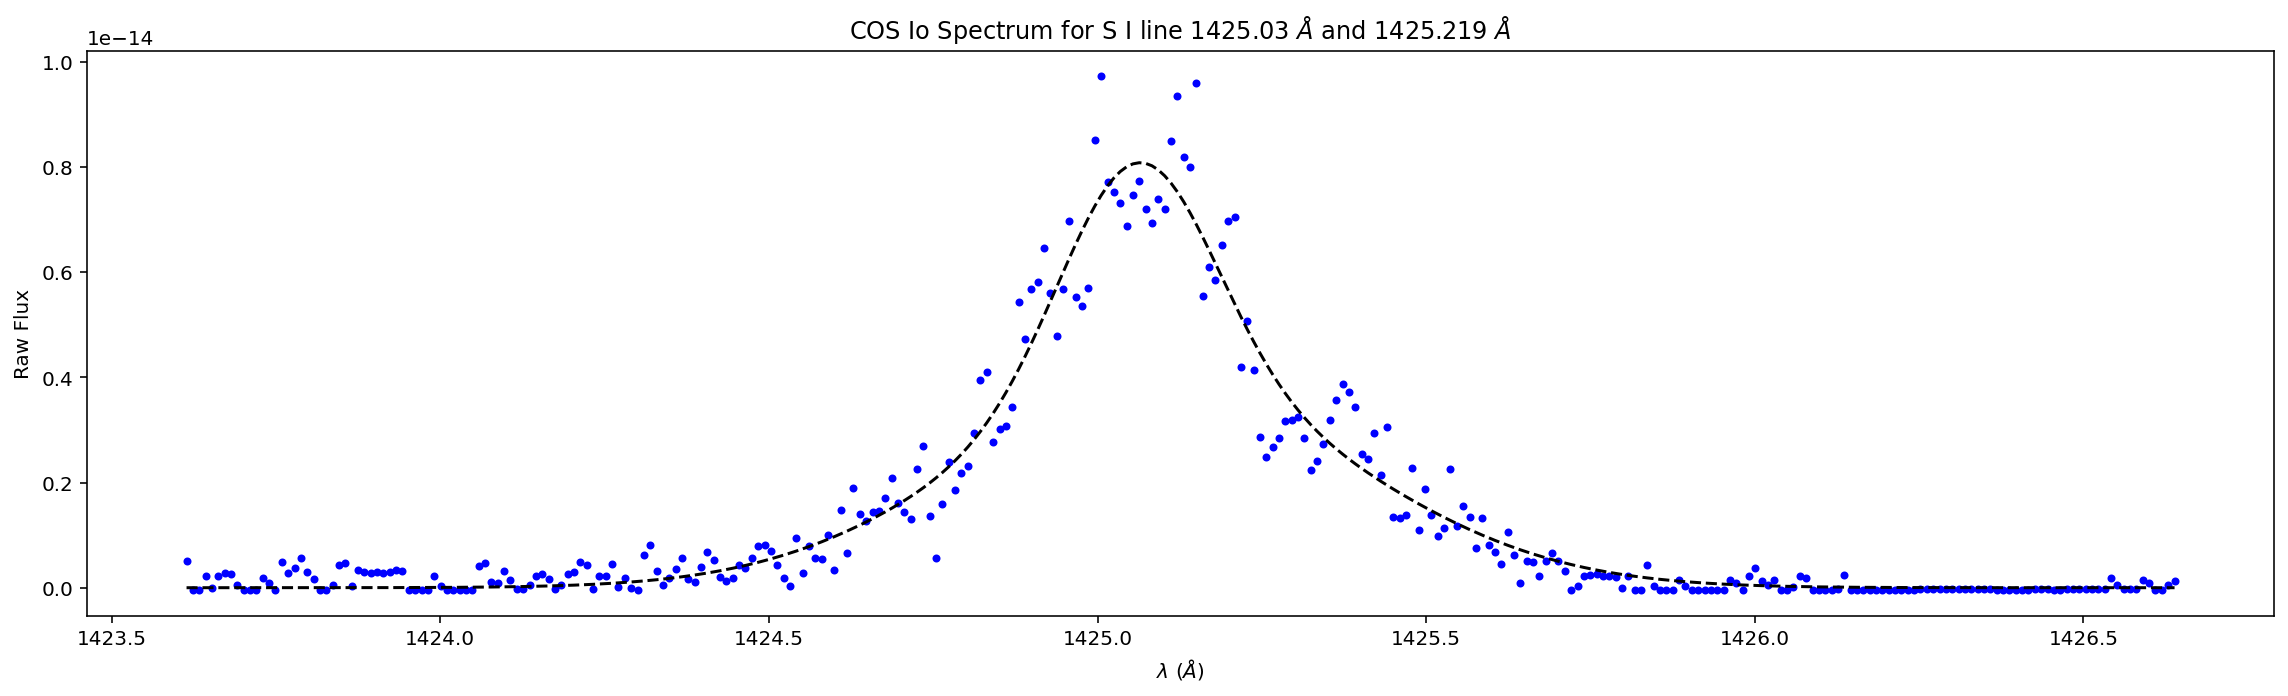

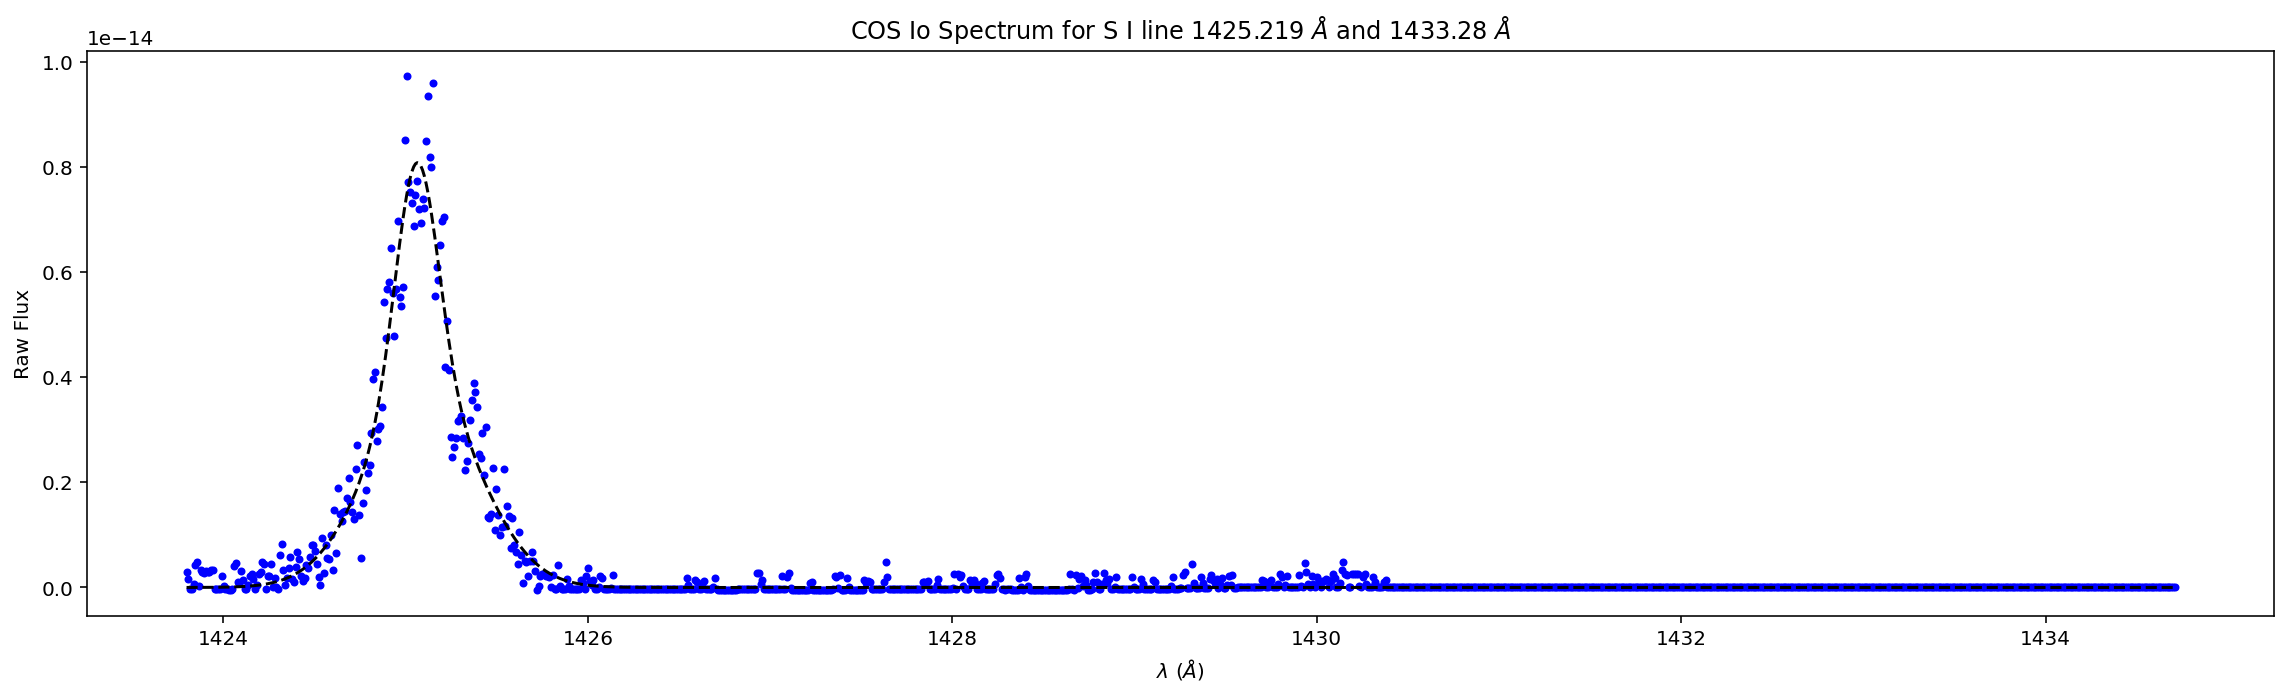

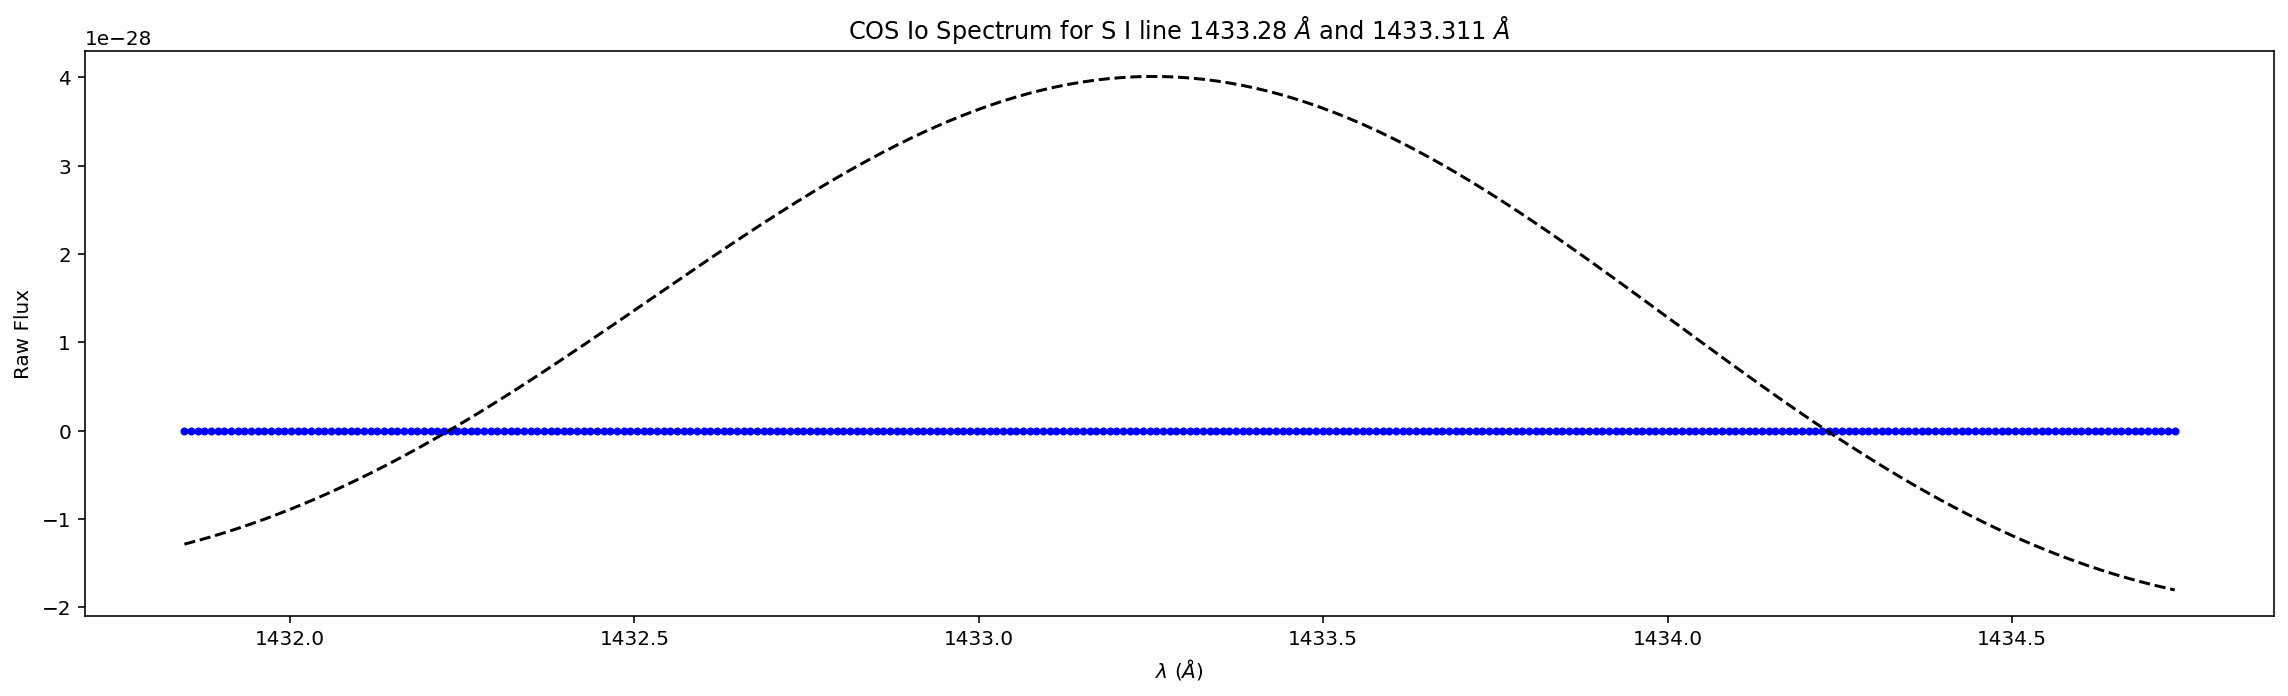

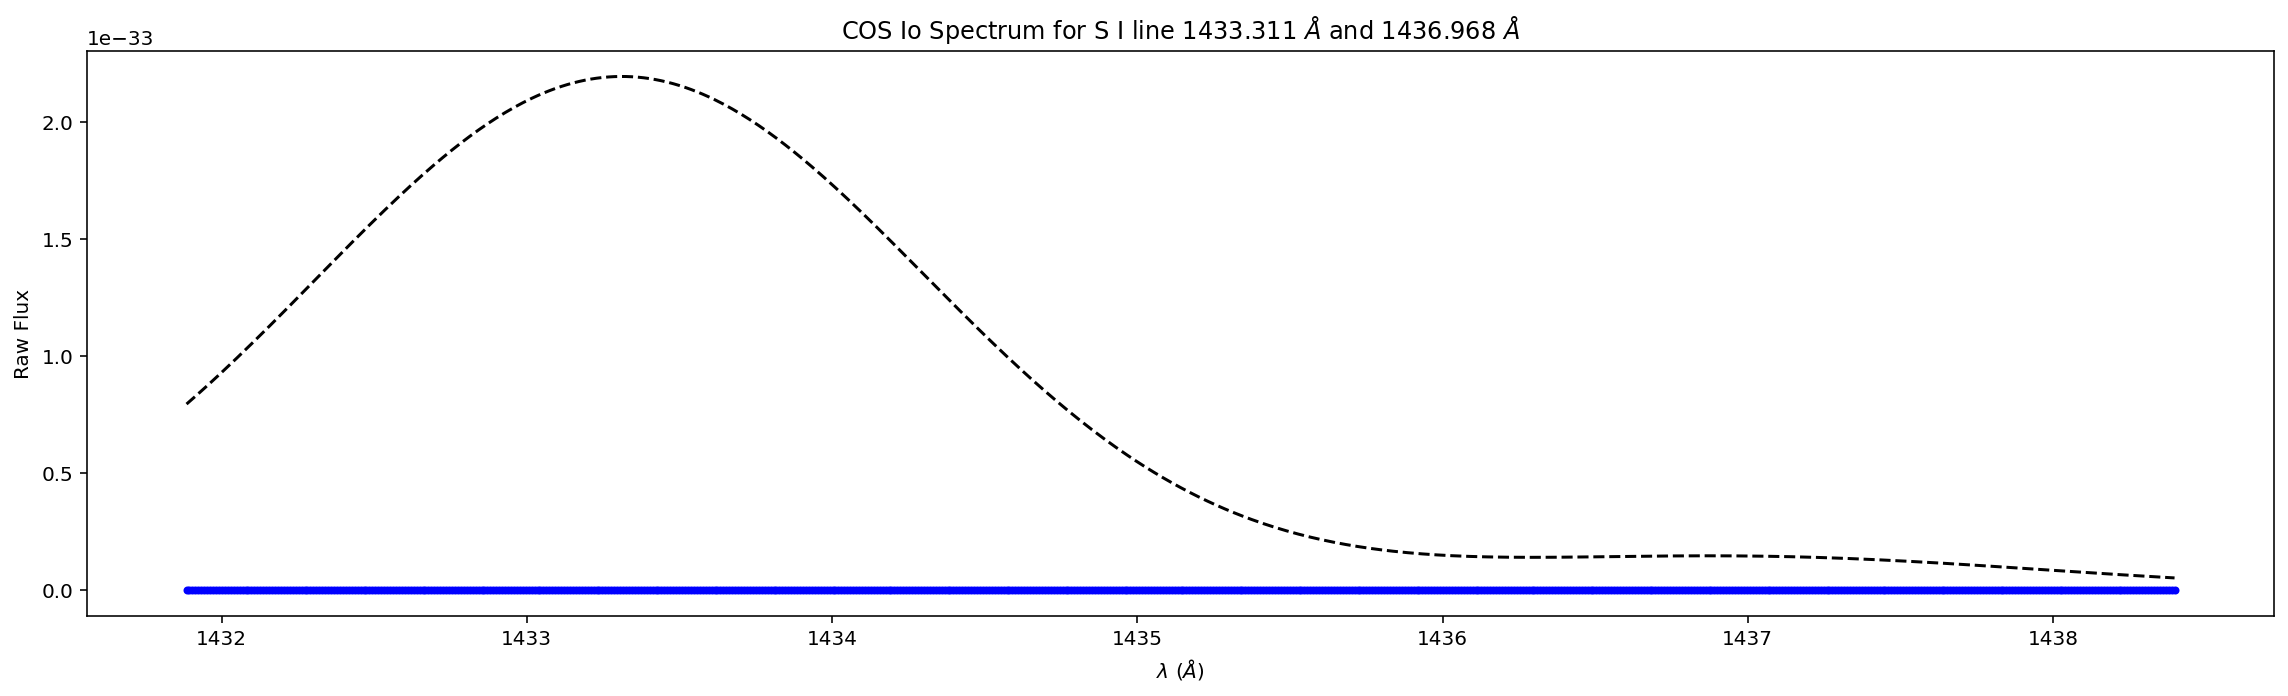

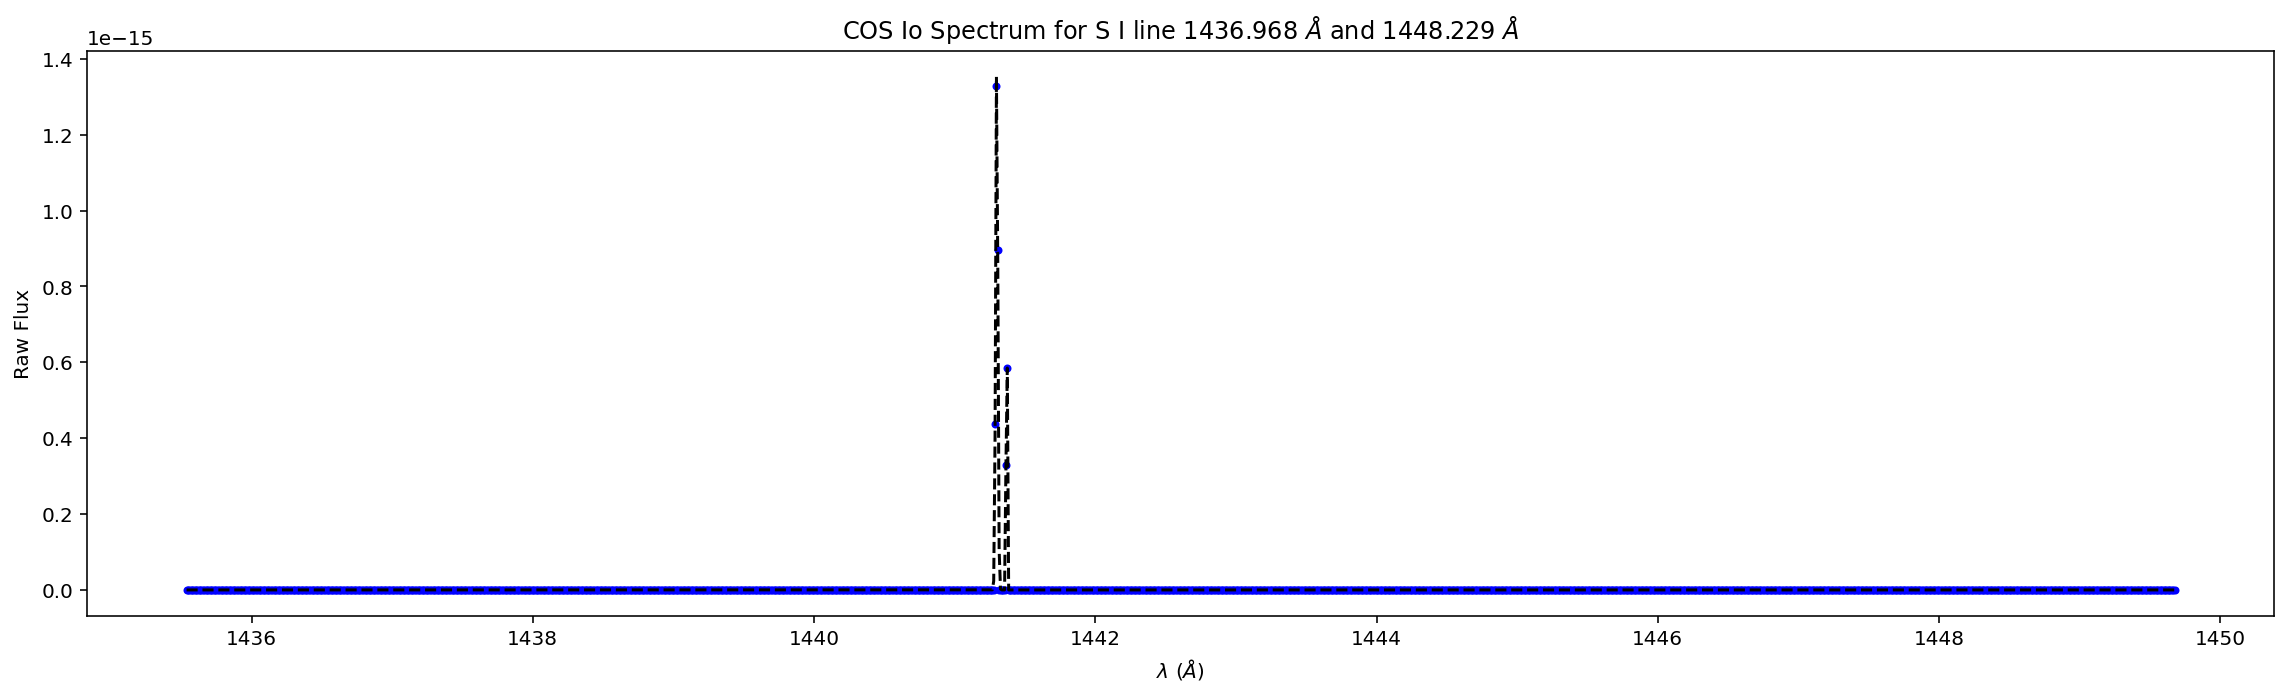

In [7]:
for index in tqdm(range(0, len(wavelength_list))):
    #len(wavelength_list) for whole list
    
    line_1 = wavelength_list[index]
    line_2 = wavelength_list[index+1]
    try:
        left_bound = 0.999*line_1
        right_bound = 1.001*line_2

        sub_region = (evt_data['WAVELENGTH'] > left_bound) & (evt_data['WAVELENGTH'] < right_bound) #only take values within this area
        wl = evt_data['WAVELENGTH'][sub_region]
        flux = evt_data['FLUX'][sub_region]
        unc = 0.1*flux #placeholder uncertainty
        wl_array = wl.data
        flux_array = flux.data

        amp1 = 1*10**-15
        sigma1 = 1
        cen1 = line_1

        amp2 = 1*10**-15
        sigma2 = 1
        cen2 = line_2

        popt_2gauss, pcov_2gauss = scipy.optimize.curve_fit(_2gaussian, wl_array, flux_array, p0=[amp1, cen1, sigma1, amp2, cen2, sigma2])
        perr_2gauss = np.sqrt(np.diag(pcov_2gauss))

        pars_1 = popt_2gauss[0:3]
        pars_2 = popt_2gauss[3:6]
        gauss_peak_1 = _1gaussian(wl_array, *pars_1)
        gauss_peak_2 = _1gaussian(wl_array, *pars_2)

        a1 = popt_2gauss[0]
        a1_err = perr_2gauss[0]
        mu1 = popt_2gauss[1]
        mu1_err = perr_2gauss[1]
        w1 = popt_2gauss[2]
        w1_err = perr_2gauss[2]

        a2 = popt_2gauss[3]
        a2_err = perr_2gauss[3]
        mu2 = popt_2gauss[4]
        mu2_err = perr_2gauss[4]
        w2 = popt_2gauss[5]
        w2_err = perr_2gauss[5]
        
        plt.figure(figsize=(16, 5))
        plt.plot(wl_array,flux_array,'b.')
        plt.plot(wl_array, _2gaussian(wl_array, *popt_2gauss), 'k--')
        plt.xlabel('$\lambda$ ($\AA$)');
        plt.ylabel('Raw Flux')
        plt.title("COS Io Spectrum for S I line {} $\AA$ and {} $\AA$".format(line_1,line_2))
        plt.tight_layout()
        save_place = '/Users/jojoa/GitHub/io_brightness/data/figures/multi_fit/'
        plt.savefig(save_place+"gauss_mult_fit_{}_{}.jpg".format(line_1,line_2), format="jpg",dpi=1000)

        brightness_1 = ((2*np.pi)**.5)*(a1*w1)
        brightness_2 = ((2*np.pi)**.5)*(a2*w2)
        #print("The brightness of S I at {} Angstrom is {}.".format(line,brightness))

        gauss_width_1 = w1
        gauss_width_unc_1 = w1_err
        obs_line_center_1 = mu1
        obs_line_center_unc_1 = mu1_err
        gauss_amp_1 = a1
        gauss_amp_unc_1 = a1_err
        
        gauss_width_2 = w2
        gauss_width_unc_2 = w2_err
        obs_line_center_2 = mu2
        obs_line_center_unc_2 = mu2_err
        gauss_amp_2 = a2
        gauss_amp_unc_2 = a2_err

        temp = {'int_wv_1':line_1, 'obs_line_center_1':obs_line_center_1, 'obs_line_center_unc_1':obs_line_center_unc_1, 
                'gaussian_width_1':gauss_width_1, 'gaussian_width_unc_1':gauss_width_unc_1, 'brightness_1':brightness_1, 
                'int_wv_2':line_2, 'obs_line_center_2':obs_line_center_2, 'obs_line_center_unc_2':obs_line_center_unc_2, 
                'gaussian_width_2':gauss_width_2, 'gaussian_width_unc_2':gauss_width_unc_2, 'brightness_2':brightness_2}

        df_results = df_results.append(temp, ignore_index=True)
        if (index % 10) == 0:
                    #print(index, fn[-49:])
                    df_results.to_csv('../data/mult_gauss_fit/io_results_june_8.csv',index=False)
                    
    except:
        print("Fail:", line_1, line_2)
        problem_files[index] = line_1, line_2
        prob_data = list(problem_files.items())
        problem_array = np.array(prob_data)

Now that we have run the loop, let us save the file for later use.

In [14]:
prob_data = list(problem_files.items())
problem_array = np.array(prob_data)
problem_array

array([[   2.   , 1211.38 ],
       [   3.   , 1212.795],
       [  18.   , 1269.209],
       [  20.   , 1277.199]])